In [1]:
import dirichletcal
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.calibration import CalibratedClassifierCV
import numpy as np
import pandas as pd
import pickle
import math
import optuna
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn import preprocessing
from NFLUtils import NFLUtils
nfl_utils = NFLUtils()
from MLBUtils import MLBUtils
mlb_utils = MLBUtils()

%matplotlib inline

import logging
# Set up logging
logging.basicConfig(level=logging.INFO)
# Set pandas display option to show all columns
pd.set_option('display.max_columns', None)

# XGBoost 
from xgboost import XGBClassifier, XGBRegressor
from sklearn.metrics import log_loss
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, KFold, StratifiedKFold, cross_val_score, cross_val_predict
import seaborn as sns # confusion matrix

from dirichletcal.calib.fulldirichlet import FullDirichletCalibrator

# Set device to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

import jax
jax.config.update("jax_platform_name", "cpu")

In [2]:
def set_all_seeds(seed=42):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Load CSV


In [3]:
df = pd.read_csv("./ttennisData/TTCupSliding50.csv", index_col=False, low_memory=False)

# Remove the performance set
test_performance_size = 900
test_performance_df = df[df.shape[0]-test_performance_size:]
df = df[:df.shape[0]-test_performance_size]

print(df.shape)
df.info()

(72500, 21)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72500 entries, 0 to 72499
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Unnamed: 0        72500 non-null  int64  
 1   Date              72500 non-null  int64  
 2   Player1           72500 non-null  int64  
 3   Player2           72500 non-null  int64  
 4   Sets_P1           72500 non-null  float64
 5   Sets_P2           72500 non-null  float64
 6   No_Odds           72500 non-null  int64  
 7   Total_P1          72500 non-null  float64
 8   Total_P2          72500 non-null  float64
 9   Total_Score       72500 non-null  int64  
 10  Total_Allowed_P1  72500 non-null  float64
 11  Total_Allowed_P2  72500 non-null  float64
 12  Over_74           72500 non-null  bool   
 13  Odds_P1           72500 non-null  float64
 14  Odds_P2           72500 non-null  float64
 15  pythagorean_P1    72500 non-null  float64
 16  pythagorean_P2    72500 non-

In [4]:

# Load data
x_col = [
    'Sets_P1',
    'Sets_P2',
    'Total_P1',
    'Total_P2',
    'Total_Allowed_P1',
    'Total_Allowed_P2',
    'pythagorean_P1',
    'pythagorean_P2',
    'D_Sets',
    'D_Odds',
    'No_Odds',
    'D_Total',
    'D_Total_Allowed'
]

y_col = ['Over_74']
x = df[x_col]
y = df[y_col]

perf_conts_df = test_performance_df[x_col]
perf_y_df = test_performance_df[y_col]


# Create an array of continuous values

Numpy array 'conts' containing stack of each continuous column

In [5]:
conts = np.stack([x[col].values for col in list(x.columns)], 1)
y_col = np.stack([y[col].values for col in list(y.columns)], 1)

perf_conts = np.stack([perf_conts_df[col].values for col in list(perf_conts_df.columns)], 1)
perf_y_col = np.stack([perf_y_df[col].values for col in list(perf_y_df.columns)], 1)

conts_train = conts
y_train = y_col

In [6]:
def convert_probas(probas, local_y_col):
    """
    Using y_col, this converts 2d array of probas into a format that works with the backtest calculation.
    That is, 
    
    probas: 2d array with first element being predicted visitor odds & other being predicted home odds
    y_col: ['H_Won', 'H_start_odds', 'V_start_odds', 'Home_Team_Id', 'Visitor_Team_Id', 'combined']
    """
    # Convert to decimal odds, apply 5% vig estimate
    local_y_col[:,1] = (1 / local_y_col[:,1]) / 1.05
    local_y_col[:,2] = (1 / local_y_col[:,2]) / 1.05
    # probas[:,1] = (1 / probas[:,1])
    # probas[:,0] = (1 / probas[:,0])
    override_req = True
    
    # Set to 0 if < the model's implied probability
    bet_res = []
    for i in range(len(probas)):
        if (probas[i,1] > local_y_col[i,1] or override_req == True) and probas[i,1] > probas[i,0]:
            bet_res.append(probas[i,1]) # Convert back to decimal odds
        elif (probas[i,0] > local_y_col[i,2] or override_req == True) and probas[i,0] > probas[i,1]:
            bet_res.append((-1*probas[i,0])) # Convert back to decimal odds
        else:
            print(f"{probas[i,:]} local ycol = {local_y_col[i,:]}")
            bet_res.append(0)
    return np.array(bet_res)

### Old approach (not based on calibration)

In [7]:
def objective(trial, override_params=None):
    """
    When doing optuna training: trial is defined, override_params left as None
    when recreating model using best parameters (override_params): trial is None, override_params are defined
    """
    is_training = trial != None
    # --- Suggest hyperparameters ---
    if is_training:
        params = {
            'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.3, log=True),
            'max_depth': trial.suggest_int('max_depth', 2, 6),
            'n_estimators': trial.suggest_int('n_estimators', 50, 500),
            'subsample': trial.suggest_float('subsample', 0.6, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
            'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
            'reg_lambda': trial.suggest_float('reg_lambda', 0.1, 12, log=True),
            'reg_alpha': trial.suggest_float('reg_alpha', 1e-6, 1.0, log=True),  # Add L1 reg
            'gamma': trial.suggest_float('gamma', 0, 1.0),  # Add min split loss
        }
    else:
        params=override_params
    
    x_train_obj, x_test_obj, y_train_obj, y_test_obj = train_test_split(conts_train, y_train, random_state=1, test_size=0.3)
    classifier = XGBClassifier(
        objective='binary:logistic',
        eval_metric='error',
        **{k: v for k, v in params.items()}
        # **{k: v for k, v in params.items() if k != 'reg_lambda'}
    )
    # cv = StratifiedKFold(n_splits=5, shuffle=False)
    # scores = cross_val_score(classifier, x_train_obj, y_train_obj, cv=cv, scoring='neg_log_loss')
    # preds = cross_val_predict(classifier, x_train_obj, y_train_obj, cv=cv, method='predict_proba')
    classifier.fit(x_train_obj, y_train_obj)
    cla_scores_train = classifier.predict_proba(x_train_obj) # FullDirichletCalibrator expects 2D on fit & predict 
    cla_scores_test = classifier.predict_proba(x_test_obj)
    # cal_scores_test = classifier.predict(x_test_obj)
    
    # ----- Full Dirichlet (alternative to ODIR Dirichlet) -----
    # Expects input as shape of probabilities
    calibrator = FullDirichletCalibrator(reg_lambda=params['reg_lambda'], reg_mu=None)
    calibrator.fit(cla_scores_train, y_train_obj)
    cal_scores_test = calibrator.predict_proba(cla_scores_test)
    # cla_scores_test = calibrator.predict(cla_scores_test)

    
    # print(cal)
    cal_loss = log_loss(y_test_obj, cal_scores_test)
    cla_loss = log_loss(y_test_obj, cla_scores_test)

    if is_training:
        return 0.8 * cal_loss + 0.2 * cla_loss
        # return cal_loss + cla_loss
    return classifier, calibrator
    # return cla_loss

def print_callback(study, trial):
    print(f"Trial {trial.number} finished with value: {trial.value}")
    print(f"Best trial so far: {study.best_trial.number}, value: {study.best_trial.value}")
    
    

In [8]:
study = optuna.create_study(
    direction='minimize',
    pruner=optuna.pruners.HyperbandPruner(min_resource=1, max_resource=1000)
)

study.optimize(objective, n_trials=400, callbacks=[print_callback])
print("Best trial:")
trial = study.best_trial
print("Value: ", trial.value)
print("Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

[I 2025-09-21 17:22:23,594] A new study created in memory with name: no-name-d3703070-2aa8-4ae4-a5ab-3bb03725cf05
INFO:2025-09-21 17:22:24,296:jax._src.xla_bridge:927: Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO:jax._src.xla_bridge:Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO:2025-09-21 17:22:24,301:jax._src.xla_bridge:927: Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: dlopen(libtpu.so, 0x0001): tried: 'libtpu.so' (no such file), '/System/Volumes/Preboot/Cryptexes/OSlibtpu.so' (no such file), '/Users/forbesjon2/anaconda3/envs/pytorchenv/bin/../lib/libtpu.so' (no such file), '/usr/lib/libtpu.so' (no such file, not in dyld cache), 'libtpu.so' (no such file), '/usr/local/lib/libtpu.so' (no such file), '/usr/lib/libtpu.so' (no such file, not in dyld cache)
INFO:jax._src.xla_bridge:Unable to initialize backend 'tpu': INTERNAL: Failed to

Trial 0 finished with value: 0.6919467387845268
Best trial so far: 0, value: 0.6919467387845268


[I 2025-09-21 17:22:35,006] Trial 1 finished with value: 0.6916839395280583 and parameters: {'learning_rate': 0.0012913384448790333, 'max_depth': 6, 'n_estimators': 305, 'subsample': 0.8399641031748246, 'colsample_bytree': 0.6176994616209952, 'min_child_weight': 5, 'reg_lambda': 0.016182148796916374}. Best is trial 1 with value: 0.6916839395280583.


Trial 1 finished with value: 0.6916839395280583
Best trial so far: 1, value: 0.6916839395280583


[I 2025-09-21 17:22:35,461] Trial 2 finished with value: 0.6902317638172839 and parameters: {'learning_rate': 0.0035918246200825872, 'max_depth': 3, 'n_estimators': 347, 'subsample': 0.733983664224337, 'colsample_bytree': 0.8476883017657678, 'min_child_weight': 6, 'reg_lambda': 0.00238458086728276}. Best is trial 2 with value: 0.6902317638172839.


Trial 2 finished with value: 0.6902317638172839
Best trial so far: 2, value: 0.6902317638172839


[I 2025-09-21 17:22:35,976] Trial 3 finished with value: 0.6987261245408174 and parameters: {'learning_rate': 0.09976639954629865, 'max_depth': 3, 'n_estimators': 349, 'subsample': 0.9436002583173, 'colsample_bytree': 0.6376685525948249, 'min_child_weight': 8, 'reg_lambda': 0.0001957302186001442}. Best is trial 2 with value: 0.6902317638172839.


Trial 3 finished with value: 0.6987261245408174
Best trial so far: 2, value: 0.6902317638172839


[I 2025-09-21 17:22:38,497] Trial 4 finished with value: 4.367572046947006 and parameters: {'learning_rate': 0.21617659419219978, 'max_depth': 11, 'n_estimators': 476, 'subsample': 0.6905568707227849, 'colsample_bytree': 0.8663361796003293, 'min_child_weight': 6, 'reg_lambda': 1.7160660540015188e-06}. Best is trial 2 with value: 0.6902317638172839.


Trial 4 finished with value: 4.367572046947006
Best trial so far: 2, value: 0.6902317638172839


[I 2025-09-21 17:22:38,990] Trial 5 finished with value: 0.6887139426484533 and parameters: {'learning_rate': 0.0011016958598569317, 'max_depth': 3, 'n_estimators': 355, 'subsample': 0.9735447074003706, 'colsample_bytree': 0.6029668705850596, 'min_child_weight': 7, 'reg_lambda': 5.486384725797249e-06}. Best is trial 5 with value: 0.6887139426484533.


Trial 5 finished with value: 0.6887139426484533
Best trial so far: 5, value: 0.6887139426484533


[I 2025-09-21 17:22:39,771] Trial 6 finished with value: 0.6905534590997116 and parameters: {'learning_rate': 0.018563855766897973, 'max_depth': 8, 'n_estimators': 290, 'subsample': 0.6776272978407494, 'colsample_bytree': 0.9290173517957879, 'min_child_weight': 4, 'reg_lambda': 0.009621024935720755}. Best is trial 5 with value: 0.6887139426484533.


Trial 6 finished with value: 0.6905534590997116
Best trial so far: 5, value: 0.6887139426484533


[I 2025-09-21 17:22:42,658] Trial 7 finished with value: 2.0678909278837283 and parameters: {'learning_rate': 0.04605860915699596, 'max_depth': 12, 'n_estimators': 386, 'subsample': 0.8607480737152575, 'colsample_bytree': 0.7705831358875739, 'min_child_weight': 4, 'reg_lambda': 1.0155131754187236e-06}. Best is trial 5 with value: 0.6887139426484533.


Trial 7 finished with value: 2.0678909278837283
Best trial so far: 5, value: 0.6887139426484533


[I 2025-09-21 17:22:44,087] Trial 8 finished with value: 0.7094153180500975 and parameters: {'learning_rate': 0.0010911248913659823, 'max_depth': 8, 'n_estimators': 357, 'subsample': 0.9485963858631422, 'colsample_bytree': 0.9721196535184314, 'min_child_weight': 7, 'reg_lambda': 1.0669007074893072e-06}. Best is trial 5 with value: 0.6887139426484533.


Trial 8 finished with value: 0.7094153180500975
Best trial so far: 5, value: 0.6887139426484533


[I 2025-09-21 17:22:44,484] Trial 9 finished with value: 0.6895526670802605 and parameters: {'learning_rate': 0.0716883758882413, 'max_depth': 4, 'n_estimators': 114, 'subsample': 0.6794990652112971, 'colsample_bytree': 0.6753160757680792, 'min_child_weight': 7, 'reg_lambda': 0.011651870684574833}. Best is trial 5 with value: 0.6887139426484533.


Trial 9 finished with value: 0.6895526670802605
Best trial so far: 5, value: 0.6887139426484533


[I 2025-09-21 17:22:45,002] Trial 10 finished with value: 0.6901883046436965 and parameters: {'learning_rate': 0.008586330254532286, 'max_depth': 5, 'n_estimators': 189, 'subsample': 0.9887883227054721, 'colsample_bytree': 0.7110674788898529, 'min_child_weight': 1, 'reg_lambda': 2.935871482529153e-05}. Best is trial 5 with value: 0.6887139426484533.


Trial 10 finished with value: 0.6901883046436965
Best trial so far: 5, value: 0.6887139426484533


[I 2025-09-21 17:22:45,423] Trial 11 finished with value: 0.6879044209644823 and parameters: {'learning_rate': 0.03499694007530304, 'max_depth': 2, 'n_estimators': 186, 'subsample': 0.61060737591498, 'colsample_bytree': 0.6721829061394365, 'min_child_weight': 10, 'reg_lambda': 2.852400261565774e-05}. Best is trial 11 with value: 0.6879044209644823.


Trial 11 finished with value: 0.6879044209644823
Best trial so far: 11, value: 0.6879044209644823


[I 2025-09-21 17:22:45,845] Trial 12 finished with value: 0.6879175457372478 and parameters: {'learning_rate': 0.029309002097076195, 'max_depth': 2, 'n_estimators': 204, 'subsample': 0.7752825963973266, 'colsample_bytree': 0.601982556847216, 'min_child_weight': 10, 'reg_lambda': 1.9643216010211886e-05}. Best is trial 11 with value: 0.6879044209644823.


Trial 12 finished with value: 0.6879175457372478
Best trial so far: 11, value: 0.6879044209644823


[I 2025-09-21 17:22:46,253] Trial 13 finished with value: 0.687890396097775 and parameters: {'learning_rate': 0.022042501981802097, 'max_depth': 2, 'n_estimators': 182, 'subsample': 0.6035973714928448, 'colsample_bytree': 0.6716210212391517, 'min_child_weight': 10, 'reg_lambda': 6.786668274243162e-05}. Best is trial 13 with value: 0.687890396097775.


Trial 13 finished with value: 0.687890396097775
Best trial so far: 13, value: 0.687890396097775


[I 2025-09-21 17:22:46,631] Trial 14 finished with value: 0.6882282763386395 and parameters: {'learning_rate': 0.010804138741156367, 'max_depth': 2, 'n_estimators': 194, 'subsample': 0.6008615716980045, 'colsample_bytree': 0.6826166166845692, 'min_child_weight': 10, 'reg_lambda': 0.00020963647156928538}. Best is trial 13 with value: 0.687890396097775.


Trial 14 finished with value: 0.6882282763386395
Best trial so far: 13, value: 0.687890396097775


[I 2025-09-21 17:22:47,151] Trial 15 finished with value: 0.7285565275279517 and parameters: {'learning_rate': 0.16193310263948538, 'max_depth': 5, 'n_estimators': 139, 'subsample': 0.6018440565252229, 'colsample_bytree': 0.7642128076088318, 'min_child_weight': 9, 'reg_lambda': 4.05519351629053e-05}. Best is trial 13 with value: 0.687890396097775.


Trial 15 finished with value: 0.7285565275279517
Best trial so far: 13, value: 0.687890396097775


[I 2025-09-21 17:22:47,886] Trial 16 finished with value: 0.7060121089317455 and parameters: {'learning_rate': 0.026546455708981245, 'max_depth': 7, 'n_estimators': 239, 'subsample': 0.6403621175597374, 'colsample_bytree': 0.8050812049142145, 'min_child_weight': 9, 'reg_lambda': 0.000961290654980125}. Best is trial 13 with value: 0.687890396097775.


Trial 16 finished with value: 0.7060121089317455
Best trial so far: 13, value: 0.687890396097775


[I 2025-09-21 17:22:48,795] Trial 17 finished with value: 0.7535096405719431 and parameters: {'learning_rate': 0.00910046485102654, 'max_depth': 9, 'n_estimators': 137, 'subsample': 0.7403842536319132, 'colsample_bytree': 0.6739122828703806, 'min_child_weight': 1, 'reg_lambda': 6.281919439313138e-05}. Best is trial 13 with value: 0.687890396097775.


Trial 17 finished with value: 0.7535096405719431
Best trial so far: 13, value: 0.687890396097775


[I 2025-09-21 17:22:49,176] Trial 18 finished with value: 0.6893397250767289 and parameters: {'learning_rate': 0.056833109325808796, 'max_depth': 4, 'n_estimators': 70, 'subsample': 0.646351205262361, 'colsample_bytree': 0.7160749228669947, 'min_child_weight': 9, 'reg_lambda': 6.0746135066375625e-06}. Best is trial 13 with value: 0.687890396097775.


Trial 18 finished with value: 0.6893397250767289
Best trial so far: 13, value: 0.687890396097775


[I 2025-09-21 17:22:49,546] Trial 19 finished with value: 0.6902666361592555 and parameters: {'learning_rate': 0.0048581307127115924, 'max_depth': 2, 'n_estimators': 229, 'subsample': 0.7305735119154251, 'colsample_bytree': 0.6509425421764123, 'min_child_weight': 10, 'reg_lambda': 0.0009129207773068459}. Best is trial 13 with value: 0.687890396097775.


Trial 19 finished with value: 0.6902666361592555
Best trial so far: 13, value: 0.687890396097775


[I 2025-09-21 17:22:50,020] Trial 20 finished with value: 0.6939945124939397 and parameters: {'learning_rate': 0.03115048800779797, 'max_depth': 5, 'n_estimators': 160, 'subsample': 0.6395745909414949, 'colsample_bytree': 0.7943188928927083, 'min_child_weight': 8, 'reg_lambda': 9.390902666262367e-05}. Best is trial 13 with value: 0.687890396097775.


Trial 20 finished with value: 0.6939945124939397
Best trial so far: 13, value: 0.687890396097775


[I 2025-09-21 17:22:50,434] Trial 21 finished with value: 0.6879125339165734 and parameters: {'learning_rate': 0.019021985521067444, 'max_depth': 2, 'n_estimators': 205, 'subsample': 0.7104351998856169, 'colsample_bytree': 0.6072414567473928, 'min_child_weight': 10, 'reg_lambda': 1.1813177446226658e-05}. Best is trial 13 with value: 0.687890396097775.


Trial 21 finished with value: 0.6879125339165734
Best trial so far: 13, value: 0.687890396097775


[I 2025-09-21 17:22:50,873] Trial 22 finished with value: 0.6879506022102571 and parameters: {'learning_rate': 0.015686391594591165, 'max_depth': 2, 'n_estimators': 255, 'subsample': 0.7111772310493699, 'colsample_bytree': 0.6489933486181934, 'min_child_weight': 10, 'reg_lambda': 1.1776089267893645e-05}. Best is trial 13 with value: 0.687890396097775.


Trial 22 finished with value: 0.6879506022102571
Best trial so far: 13, value: 0.687890396097775


[I 2025-09-21 17:22:51,354] Trial 23 finished with value: 0.6888514092288297 and parameters: {'learning_rate': 0.015911297147377455, 'max_depth': 4, 'n_estimators': 164, 'subsample': 0.774904376606096, 'colsample_bytree': 0.6948518136347578, 'min_child_weight': 8, 'reg_lambda': 5.2582684735647105e-06}. Best is trial 13 with value: 0.687890396097775.


Trial 23 finished with value: 0.6888514092288297
Best trial so far: 13, value: 0.687890396097775


[I 2025-09-21 17:22:51,767] Trial 24 finished with value: 0.6896901506794575 and parameters: {'learning_rate': 0.09718749561712987, 'max_depth': 3, 'n_estimators': 105, 'subsample': 0.6389388869740604, 'colsample_bytree': 0.7357690456310216, 'min_child_weight': 9, 'reg_lambda': 0.0001329855556429585}. Best is trial 13 with value: 0.687890396097775.


Trial 24 finished with value: 0.6896901506794575
Best trial so far: 13, value: 0.687890396097775


[I 2025-09-21 17:22:52,131] Trial 25 finished with value: 0.6878654816299661 and parameters: {'learning_rate': 0.04098473453865612, 'max_depth': 2, 'n_estimators': 219, 'subsample': 0.6064988820949834, 'colsample_bytree': 0.6388226615961883, 'min_child_weight': 10, 'reg_lambda': 0.0004843090538312667}. Best is trial 25 with value: 0.6878654816299661.


Trial 25 finished with value: 0.6878654816299661
Best trial so far: 25, value: 0.6878654816299661


[I 2025-09-21 17:22:52,653] Trial 26 finished with value: 0.6904603746144959 and parameters: {'learning_rate': 0.04210745822493942, 'max_depth': 4, 'n_estimators': 257, 'subsample': 0.6004460643514951, 'colsample_bytree': 0.6488174234701228, 'min_child_weight': 2, 'reg_lambda': 0.0011305078971086452}. Best is trial 25 with value: 0.6878654816299661.


Trial 26 finished with value: 0.6904603746144959
Best trial so far: 25, value: 0.6878654816299661


[I 2025-09-21 17:22:53,448] Trial 27 finished with value: 0.793070144212016 and parameters: {'learning_rate': 0.10314624361514052, 'max_depth': 6, 'n_estimators': 306, 'subsample': 0.6694266227713864, 'colsample_bytree': 0.7471507444063337, 'min_child_weight': 9, 'reg_lambda': 0.0005231295749789068}. Best is trial 25 with value: 0.6878654816299661.


Trial 27 finished with value: 0.793070144212016
Best trial so far: 25, value: 0.6878654816299661


[I 2025-09-21 17:22:53,816] Trial 28 finished with value: 0.6888476141203924 and parameters: {'learning_rate': 0.005767699690425752, 'max_depth': 3, 'n_estimators': 166, 'subsample': 0.6162866521835973, 'colsample_bytree': 0.6987241892448144, 'min_child_weight': 8, 'reg_lambda': 0.00037426079142845615}. Best is trial 25 with value: 0.6878654816299661.


Trial 28 finished with value: 0.6888476141203924
Best trial so far: 25, value: 0.6878654816299661


[I 2025-09-21 17:22:54,434] Trial 29 finished with value: 0.7043035483348566 and parameters: {'learning_rate': 0.039511999206230615, 'max_depth': 10, 'n_estimators': 105, 'subsample': 0.6561992589690915, 'colsample_bytree': 0.6333663420393933, 'min_child_weight': 10, 'reg_lambda': 0.0030021907072884076}. Best is trial 25 with value: 0.6878654816299661.


Trial 29 finished with value: 0.7043035483348566
Best trial so far: 25, value: 0.6878654816299661


[I 2025-09-21 17:22:54,776] Trial 30 finished with value: 0.6920694338235831 and parameters: {'learning_rate': 0.00206281488441771, 'max_depth': 6, 'n_estimators': 65, 'subsample': 0.8109572147502674, 'colsample_bytree': 0.6684343563547276, 'min_child_weight': 9, 'reg_lambda': 0.042329172616344675}. Best is trial 25 with value: 0.6878654816299661.


Trial 30 finished with value: 0.6920694338235831
Best trial so far: 25, value: 0.6878654816299661


[I 2025-09-21 17:22:55,205] Trial 31 finished with value: 0.6879639858783527 and parameters: {'learning_rate': 0.02030533110655065, 'max_depth': 2, 'n_estimators': 217, 'subsample': 0.6990373700368342, 'colsample_bytree': 0.6312165216425908, 'min_child_weight': 10, 'reg_lambda': 1.632975123227792e-05}. Best is trial 25 with value: 0.6878654816299661.


Trial 31 finished with value: 0.6879639858783527
Best trial so far: 25, value: 0.6878654816299661


[I 2025-09-21 17:22:55,634] Trial 32 finished with value: 0.6881206221738696 and parameters: {'learning_rate': 0.011848531719977053, 'max_depth': 2, 'n_estimators': 187, 'subsample': 0.6319236707375032, 'colsample_bytree': 0.6170567674525546, 'min_child_weight': 10, 'reg_lambda': 4.9095598902523864e-05}. Best is trial 25 with value: 0.6878654816299661.


Trial 32 finished with value: 0.6881206221738696
Best trial so far: 25, value: 0.6878654816299661


[I 2025-09-21 17:22:56,101] Trial 33 finished with value: 0.688234917906081 and parameters: {'learning_rate': 0.024205197956137074, 'max_depth': 3, 'n_estimators': 230, 'subsample': 0.6237363361150163, 'colsample_bytree': 0.6631716580751166, 'min_child_weight': 9, 'reg_lambda': 8.904926195598854e-05}. Best is trial 25 with value: 0.6878654816299661.


Trial 33 finished with value: 0.688234917906081
Best trial so far: 25, value: 0.6878654816299661


[I 2025-09-21 17:22:56,588] Trial 34 finished with value: 0.6927433299748158 and parameters: {'learning_rate': 0.0628826102751696, 'max_depth': 3, 'n_estimators': 271, 'subsample': 0.6623548484955101, 'colsample_bytree': 0.6194310095862733, 'min_child_weight': 8, 'reg_lambda': 8.704484282946095e-06}. Best is trial 25 with value: 0.6878654816299661.


Trial 34 finished with value: 0.6927433299748158
Best trial so far: 25, value: 0.6878654816299661


[I 2025-09-21 17:22:57,060] Trial 35 finished with value: 0.6882364365456685 and parameters: {'learning_rate': 0.03626420840607083, 'max_depth': 2, 'n_estimators': 316, 'subsample': 0.7546785269416487, 'colsample_bytree': 0.7171542537363103, 'min_child_weight': 5, 'reg_lambda': 2.7220048199311218e-05}. Best is trial 25 with value: 0.6878654816299661.


Trial 35 finished with value: 0.6882364365456685
Best trial so far: 25, value: 0.6878654816299661


[I 2025-09-21 17:22:57,690] Trial 36 finished with value: 0.6885171623875048 and parameters: {'learning_rate': 0.013638434490765794, 'max_depth': 3, 'n_estimators': 439, 'subsample': 0.7110477242220464, 'colsample_bytree': 0.8567381550435959, 'min_child_weight': 10, 'reg_lambda': 2.2760539782692343e-06}. Best is trial 25 with value: 0.6878654816299661.


Trial 36 finished with value: 0.6885171623875048
Best trial so far: 25, value: 0.6878654816299661


[I 2025-09-21 17:22:58,167] Trial 37 finished with value: 0.6885123629960006 and parameters: {'learning_rate': 0.006590773834972557, 'max_depth': 4, 'n_estimators': 135, 'subsample': 0.8330830564861775, 'colsample_bytree': 0.8923817778683574, 'min_child_weight': 7, 'reg_lambda': 2.9708467287358375e-06}. Best is trial 25 with value: 0.6878654816299661.


Trial 37 finished with value: 0.6885123629960006
Best trial so far: 25, value: 0.6878654816299661


[I 2025-09-21 17:22:58,543] Trial 38 finished with value: 0.6879973502781837 and parameters: {'learning_rate': 0.021333679353378904, 'max_depth': 2, 'n_estimators': 170, 'subsample': 0.6237740661768524, 'colsample_bytree': 0.6049951265657855, 'min_child_weight': 3, 'reg_lambda': 0.0002654158376790592}. Best is trial 25 with value: 0.6878654816299661.


Trial 38 finished with value: 0.6879973502781837
Best trial so far: 25, value: 0.6878654816299661


[I 2025-09-21 17:22:59,023] Trial 39 finished with value: 0.6957567207918969 and parameters: {'learning_rate': 0.2727986806258536, 'max_depth': 3, 'n_estimators': 288, 'subsample': 0.8901740169623756, 'colsample_bytree': 0.631011704471355, 'min_child_weight': 6, 'reg_lambda': 0.005623823576528505}. Best is trial 25 with value: 0.6878654816299661.


Trial 39 finished with value: 0.6957567207918969
Best trial so far: 25, value: 0.6878654816299661


[I 2025-09-21 17:22:59,560] Trial 40 finished with value: 0.6900340449539221 and parameters: {'learning_rate': 0.05208362429702207, 'max_depth': 3, 'n_estimators': 218, 'subsample': 0.693046574833795, 'colsample_bytree': 0.8293827525753493, 'min_child_weight': 8, 'reg_lambda': 0.00014744695103213276}. Best is trial 25 with value: 0.6878654816299661.


Trial 40 finished with value: 0.6900340449539221
Best trial so far: 25, value: 0.6878654816299661


[I 2025-09-21 17:23:00,168] Trial 41 finished with value: 0.6879879826738226 and parameters: {'learning_rate': 0.027666480473488943, 'max_depth': 2, 'n_estimators': 198, 'subsample': 0.7961508308397212, 'colsample_bytree': 0.604762860873892, 'min_child_weight': 10, 'reg_lambda': 1.8546796511328843e-05}. Best is trial 25 with value: 0.6878654816299661.


Trial 41 finished with value: 0.6879879826738226
Best trial so far: 25, value: 0.6878654816299661


[I 2025-09-21 17:23:00,746] Trial 42 finished with value: 0.6879591206438967 and parameters: {'learning_rate': 0.031788996539879426, 'max_depth': 2, 'n_estimators': 245, 'subsample': 0.7740160725412477, 'colsample_bytree': 0.650563382034175, 'min_child_weight': 10, 'reg_lambda': 1.5823734006852383e-05}. Best is trial 25 with value: 0.6878654816299661.


Trial 42 finished with value: 0.6879591206438967
Best trial so far: 25, value: 0.6878654816299661


[I 2025-09-21 17:23:01,425] Trial 43 finished with value: 0.702674139704315 and parameters: {'learning_rate': 0.08108788354720697, 'max_depth': 4, 'n_estimators': 208, 'subsample': 0.8917777613945516, 'colsample_bytree': 0.6013835446698989, 'min_child_weight': 9, 'reg_lambda': 3.200181806398693e-05}. Best is trial 25 with value: 0.6878654816299661.


Trial 43 finished with value: 0.702674139704315
Best trial so far: 25, value: 0.6878654816299661


[I 2025-09-21 17:23:01,937] Trial 44 finished with value: 0.6899208163142644 and parameters: {'learning_rate': 0.15165315737517907, 'max_depth': 2, 'n_estimators': 187, 'subsample': 0.6746080807559544, 'colsample_bytree': 0.6209626350024242, 'min_child_weight': 10, 'reg_lambda': 8.07904927993439e-05}. Best is trial 25 with value: 0.6878654816299661.


Trial 44 finished with value: 0.6899208163142644
Best trial so far: 25, value: 0.6878654816299661


[I 2025-09-21 17:23:02,450] Trial 45 finished with value: 0.6879659260743498 and parameters: {'learning_rate': 0.018621227990683088, 'max_depth': 3, 'n_estimators': 148, 'subsample': 0.6144355477610008, 'colsample_bytree': 0.6928528237279953, 'min_child_weight': 9, 'reg_lambda': 3.616165310997537e-06}. Best is trial 25 with value: 0.6878654816299661.


Trial 45 finished with value: 0.6879659260743498
Best trial so far: 25, value: 0.6878654816299661


[I 2025-09-21 17:23:03,178] Trial 46 finished with value: 0.7013548660956713 and parameters: {'learning_rate': 0.04577133632722414, 'max_depth': 5, 'n_estimators': 180, 'subsample': 0.853192751941169, 'colsample_bytree': 0.6627504604312396, 'min_child_weight': 10, 'reg_lambda': 7.347582951941778e-06}. Best is trial 25 with value: 0.6878654816299661.


Trial 46 finished with value: 0.7013548660956713
Best trial so far: 25, value: 0.6878654816299661


[I 2025-09-21 17:23:03,563] Trial 47 finished with value: 0.6883594633285015 and parameters: {'learning_rate': 0.024128169366353223, 'max_depth': 2, 'n_estimators': 124, 'subsample': 0.6578273969550673, 'colsample_bytree': 0.6384489320523472, 'min_child_weight': 9, 'reg_lambda': 0.000536263843236567}. Best is trial 25 with value: 0.6878654816299661.


Trial 47 finished with value: 0.6883594633285015
Best trial so far: 25, value: 0.6878654816299661


[I 2025-09-21 17:23:04,031] Trial 48 finished with value: 0.6883207504126364 and parameters: {'learning_rate': 0.008730533357773447, 'max_depth': 3, 'n_estimators': 87, 'subsample': 0.9113242327247765, 'colsample_bytree': 0.9526468092611041, 'min_child_weight': 7, 'reg_lambda': 2.4578814121789546e-05}. Best is trial 25 with value: 0.6878654816299661.


Trial 48 finished with value: 0.6883207504126364
Best trial so far: 25, value: 0.6878654816299661


[I 2025-09-21 17:23:05,875] Trial 49 finished with value: 1.0456908279640225 and parameters: {'learning_rate': 0.031703869442504494, 'max_depth': 11, 'n_estimators': 324, 'subsample': 0.7296084931702885, 'colsample_bytree': 0.6806850300224376, 'min_child_weight': 8, 'reg_lambda': 5.886315435763532e-05}. Best is trial 25 with value: 0.6878654816299661.


Trial 49 finished with value: 1.0456908279640225
Best trial so far: 25, value: 0.6878654816299661


[I 2025-09-21 17:23:06,542] Trial 50 finished with value: 0.6890645769111957 and parameters: {'learning_rate': 0.012083605361060271, 'max_depth': 4, 'n_estimators': 269, 'subsample': 0.7561551868776311, 'colsample_bytree': 0.6196284879338807, 'min_child_weight': 4, 'reg_lambda': 1.1749753205091929e-05}. Best is trial 25 with value: 0.6878654816299661.


Trial 50 finished with value: 0.6890645769111957
Best trial so far: 25, value: 0.6878654816299661


[I 2025-09-21 17:23:07,082] Trial 51 finished with value: 0.6879297236793597 and parameters: {'learning_rate': 0.016366906228430334, 'max_depth': 2, 'n_estimators': 247, 'subsample': 0.7132931248277491, 'colsample_bytree': 0.6558547776532861, 'min_child_weight': 10, 'reg_lambda': 1.3145140425262119e-05}. Best is trial 25 with value: 0.6878654816299661.


Trial 51 finished with value: 0.6879297236793597
Best trial so far: 25, value: 0.6878654816299661


[I 2025-09-21 17:23:07,607] Trial 52 finished with value: 0.6881010249714771 and parameters: {'learning_rate': 0.017078333316762957, 'max_depth': 2, 'n_estimators': 205, 'subsample': 0.8105562683586205, 'colsample_bytree': 0.6552949667017259, 'min_child_weight': 10, 'reg_lambda': 1.5331945189655642e-06}. Best is trial 25 with value: 0.6878654816299661.


Trial 52 finished with value: 0.6881010249714771
Best trial so far: 25, value: 0.6878654816299661


[I 2025-09-21 17:23:08,165] Trial 53 finished with value: 0.6878280792394496 and parameters: {'learning_rate': 0.023331025685749546, 'max_depth': 2, 'n_estimators': 233, 'subsample': 0.7044672226509177, 'colsample_bytree': 0.9977814435208067, 'min_child_weight': 10, 'reg_lambda': 1.037370756673213e-05}. Best is trial 53 with value: 0.6878280792394496.


Trial 53 finished with value: 0.6878280792394496
Best trial so far: 53, value: 0.6878280792394496


[I 2025-09-21 17:23:08,724] Trial 54 finished with value: 0.6923853384968517 and parameters: {'learning_rate': 0.06814817028451765, 'max_depth': 3, 'n_estimators': 224, 'subsample': 0.6138510038618026, 'colsample_bytree': 0.9078747736786906, 'min_child_weight': 9, 'reg_lambda': 4.930331009629221e-06}. Best is trial 53 with value: 0.6878280792394496.


Trial 54 finished with value: 0.6923853384968517
Best trial so far: 53, value: 0.6878280792394496


[I 2025-09-21 17:23:09,217] Trial 55 finished with value: 0.6879749049588222 and parameters: {'learning_rate': 0.05246330080885303, 'max_depth': 2, 'n_estimators': 157, 'subsample': 0.6868491643346789, 'colsample_bytree': 0.9952691817520115, 'min_child_weight': 9, 'reg_lambda': 3.870681445191343e-05}. Best is trial 53 with value: 0.6878280792394496.


Trial 55 finished with value: 0.6879749049588222
Best trial so far: 53, value: 0.6878280792394496


[I 2025-09-21 17:23:10,391] Trial 56 finished with value: 0.7820920549869534 and parameters: {'learning_rate': 0.033201268355162954, 'max_depth': 8, 'n_estimators': 282, 'subsample': 0.6436543380288724, 'colsample_bytree': 0.78294749921731, 'min_child_weight': 10, 'reg_lambda': 0.00012974815719964637}. Best is trial 53 with value: 0.6878280792394496.


Trial 56 finished with value: 0.7820920549869534
Best trial so far: 53, value: 0.6878280792394496


[I 2025-09-21 17:23:10,878] Trial 57 finished with value: 0.6880955813179499 and parameters: {'learning_rate': 0.024931938709949336, 'max_depth': 2, 'n_estimators': 175, 'subsample': 0.7814543293891576, 'colsample_bytree': 0.8293606131588735, 'min_child_weight': 10, 'reg_lambda': 8.681771913640738e-06}. Best is trial 53 with value: 0.6878280792394496.


Trial 57 finished with value: 0.6880955813179499
Best trial so far: 53, value: 0.6878280792394496


[I 2025-09-21 17:23:11,408] Trial 58 finished with value: 0.6890853250583457 and parameters: {'learning_rate': 0.04000623658649832, 'max_depth': 3, 'n_estimators': 205, 'subsample': 0.7539371399143122, 'colsample_bytree': 0.7583482456135877, 'min_child_weight': 9, 'reg_lambda': 2.2800404408084174e-05}. Best is trial 53 with value: 0.6878280792394496.


Trial 58 finished with value: 0.6890853250583457
Best trial so far: 53, value: 0.6878280792394496


[I 2025-09-21 17:23:12,024] Trial 59 finished with value: 0.6886489915242691 and parameters: {'learning_rate': 0.014238648729186669, 'max_depth': 4, 'n_estimators': 236, 'subsample': 0.7356779941222368, 'colsample_bytree': 0.7244138992290099, 'min_child_weight': 10, 'reg_lambda': 0.00019481892277053143}. Best is trial 53 with value: 0.6878280792394496.


Trial 59 finished with value: 0.6886489915242691
Best trial so far: 53, value: 0.6878280792394496


[I 2025-09-21 17:23:12,533] Trial 60 finished with value: 0.6882876877194326 and parameters: {'learning_rate': 0.02139955946629479, 'max_depth': 3, 'n_estimators': 261, 'subsample': 0.6004035285855573, 'colsample_bytree': 0.8825153744704473, 'min_child_weight': 9, 'reg_lambda': 0.0021548999212384723}. Best is trial 53 with value: 0.6878280792394496.


Trial 60 finished with value: 0.6882876877194326
Best trial so far: 53, value: 0.6878280792394496


[I 2025-09-21 17:23:13,435] Trial 61 finished with value: 0.7160795140632776 and parameters: {'learning_rate': 0.017860430533489933, 'max_depth': 7, 'n_estimators': 246, 'subsample': 0.7195857034059567, 'colsample_bytree': 0.7045867682567514, 'min_child_weight': 10, 'reg_lambda': 1.2451855730982749e-05}. Best is trial 53 with value: 0.6878280792394496.


Trial 61 finished with value: 0.7160795140632776
Best trial so far: 53, value: 0.6878280792394496


[I 2025-09-21 17:23:13,971] Trial 62 finished with value: 0.6879232415527369 and parameters: {'learning_rate': 0.02731769717719021, 'max_depth': 2, 'n_estimators': 213, 'subsample': 0.7010354550153395, 'colsample_bytree': 0.6403117511321837, 'min_child_weight': 10, 'reg_lambda': 4.457573016252307e-05}. Best is trial 53 with value: 0.6878280792394496.


Trial 62 finished with value: 0.6879232415527369
Best trial so far: 53, value: 0.6878280792394496


[I 2025-09-21 17:23:14,499] Trial 63 finished with value: 0.6879266425954482 and parameters: {'learning_rate': 0.028001922563498725, 'max_depth': 2, 'n_estimators': 215, 'subsample': 0.701581835642237, 'colsample_bytree': 0.6149847384588893, 'min_child_weight': 10, 'reg_lambda': 4.063202956434063e-05}. Best is trial 53 with value: 0.6878280792394496.


Trial 63 finished with value: 0.6879266425954482
Best trial so far: 53, value: 0.6878280792394496


[I 2025-09-21 17:23:15,003] Trial 64 finished with value: 0.6879679527370568 and parameters: {'learning_rate': 0.0447317603846271, 'max_depth': 2, 'n_estimators': 198, 'subsample': 0.6801381904122833, 'colsample_bytree': 0.6392873115528478, 'min_child_weight': 9, 'reg_lambda': 7.16050516477663e-05}. Best is trial 53 with value: 0.6878280792394496.


Trial 64 finished with value: 0.6879679527370568
Best trial so far: 53, value: 0.6878280792394496


[I 2025-09-21 17:23:15,410] Trial 65 finished with value: 0.6882907828379782 and parameters: {'learning_rate': 0.00996893314652205, 'max_depth': 3, 'n_estimators': 151, 'subsample': 0.6514822027913769, 'colsample_bytree': 0.6405819356904384, 'min_child_weight': 10, 'reg_lambda': 0.0003863229318450264}. Best is trial 53 with value: 0.6878280792394496.


Trial 65 finished with value: 0.6882907828379782
Best trial so far: 53, value: 0.6878280792394496


[I 2025-09-21 17:23:15,952] Trial 66 finished with value: 0.6878682254995323 and parameters: {'learning_rate': 0.03816481048952382, 'max_depth': 2, 'n_estimators': 182, 'subsample': 0.6249363128941732, 'colsample_bytree': 0.6898795689458317, 'min_child_weight': 8, 'reg_lambda': 5.048242184105827e-05}. Best is trial 53 with value: 0.6878280792394496.


Trial 66 finished with value: 0.6878682254995323
Best trial so far: 53, value: 0.6878280792394496


[I 2025-09-21 17:23:16,434] Trial 67 finished with value: 0.6886043892928072 and parameters: {'learning_rate': 0.083427396505688, 'max_depth': 2, 'n_estimators': 179, 'subsample': 0.6278234325082777, 'colsample_bytree': 0.6816675508317128, 'min_child_weight': 8, 'reg_lambda': 3.924617186331241e-06}. Best is trial 53 with value: 0.6878280792394496.


Trial 67 finished with value: 0.6886043892928072
Best trial so far: 53, value: 0.6878280792394496


[I 2025-09-21 17:23:16,917] Trial 68 finished with value: 0.6887905333202244 and parameters: {'learning_rate': 0.05591412318140584, 'max_depth': 3, 'n_estimators': 124, 'subsample': 0.6109149283750526, 'colsample_bytree': 0.7399377275846444, 'min_child_weight': 9, 'reg_lambda': 2.0457336682557797e-05}. Best is trial 53 with value: 0.6878280792394496.


Trial 68 finished with value: 0.6887905333202244
Best trial so far: 53, value: 0.6878280792394496


[I 2025-09-21 17:23:17,477] Trial 69 finished with value: 0.6885976875189753 and parameters: {'learning_rate': 0.034539604819104106, 'max_depth': 3, 'n_estimators': 232, 'subsample': 0.6324317363496224, 'colsample_bytree': 0.6906453827704067, 'min_child_weight': 6, 'reg_lambda': 0.00010807524877095017}. Best is trial 53 with value: 0.6878280792394496.


Trial 69 finished with value: 0.6885976875189753
Best trial so far: 53, value: 0.6878280792394496


[I 2025-09-21 17:23:17,865] Trial 70 finished with value: 0.6900967341825814 and parameters: {'learning_rate': 0.007448794991660986, 'max_depth': 2, 'n_estimators': 148, 'subsample': 0.6651759925925139, 'colsample_bytree': 0.6710656645108437, 'min_child_weight': 7, 'reg_lambda': 0.000747195467999079}. Best is trial 53 with value: 0.6878280792394496.


Trial 70 finished with value: 0.6900967341825814
Best trial so far: 53, value: 0.6878280792394496


[I 2025-09-21 17:23:18,353] Trial 71 finished with value: 0.6878682701431926 and parameters: {'learning_rate': 0.02256045683969383, 'max_depth': 2, 'n_estimators': 189, 'subsample': 0.6473986058839324, 'colsample_bytree': 0.6311727364219684, 'min_child_weight': 10, 'reg_lambda': 4.1393189410713786e-05}. Best is trial 53 with value: 0.6878280792394496.


Trial 71 finished with value: 0.6878682701431926
Best trial so far: 53, value: 0.6878280792394496


[I 2025-09-21 17:23:18,836] Trial 72 finished with value: 0.6879082673949658 and parameters: {'learning_rate': 0.022090464747992856, 'max_depth': 2, 'n_estimators': 189, 'subsample': 0.6101719317144887, 'colsample_bytree': 0.6234648455973006, 'min_child_weight': 10, 'reg_lambda': 3.378185069954969e-05}. Best is trial 53 with value: 0.6878280792394496.


Trial 72 finished with value: 0.6879082673949658
Best trial so far: 53, value: 0.6878280792394496


[I 2025-09-21 17:23:19,325] Trial 73 finished with value: 0.6879395497011185 and parameters: {'learning_rate': 0.022123725706379913, 'max_depth': 2, 'n_estimators': 188, 'subsample': 0.6104233966239309, 'colsample_bytree': 0.613490803974012, 'min_child_weight': 10, 'reg_lambda': 5.598548612565353e-05}. Best is trial 53 with value: 0.6878280792394496.


Trial 73 finished with value: 0.6879395497011185
Best trial so far: 53, value: 0.6878280792394496


[I 2025-09-21 17:23:19,719] Trial 74 finished with value: 0.6882385148121883 and parameters: {'learning_rate': 0.013250955866478818, 'max_depth': 2, 'n_estimators': 165, 'subsample': 0.6381451252483166, 'colsample_bytree': 0.6286930310036625, 'min_child_weight': 9, 'reg_lambda': 0.00020966692500837405}. Best is trial 53 with value: 0.6878280792394496.


Trial 74 finished with value: 0.6882385148121883
Best trial so far: 53, value: 0.6878280792394496


[I 2025-09-21 17:23:20,254] Trial 75 finished with value: 0.6885801480119594 and parameters: {'learning_rate': 0.03705986425213117, 'max_depth': 3, 'n_estimators': 196, 'subsample': 0.6258490544055755, 'colsample_bytree': 0.6608574163133886, 'min_child_weight': 10, 'reg_lambda': 3.150315528123946e-05}. Best is trial 53 with value: 0.6878280792394496.


Trial 75 finished with value: 0.6885801480119594
Best trial so far: 53, value: 0.6878280792394496


[I 2025-09-21 17:23:21,664] Trial 76 finished with value: 0.8649676809351965 and parameters: {'learning_rate': 0.020175287121665535, 'max_depth': 12, 'n_estimators': 174, 'subsample': 0.6500491205827883, 'colsample_bytree': 0.668753851814593, 'min_child_weight': 8, 'reg_lambda': 1.011648422538246e-05}. Best is trial 53 with value: 0.6878280792394496.


Trial 76 finished with value: 0.8649676809351965
Best trial so far: 53, value: 0.6878280792394496


[I 2025-09-21 17:23:22,045] Trial 77 finished with value: 0.6882741976670993 and parameters: {'learning_rate': 0.047377987104858216, 'max_depth': 2, 'n_estimators': 132, 'subsample': 0.6190743475250075, 'colsample_bytree': 0.6269548433057913, 'min_child_weight': 10, 'reg_lambda': 0.0014260353686839713}. Best is trial 53 with value: 0.6878280792394496.


Trial 77 finished with value: 0.6882741976670993
Best trial so far: 53, value: 0.6878280792394496


[I 2025-09-21 17:23:22,753] Trial 78 finished with value: 0.6881811760332865 and parameters: {'learning_rate': 0.0025608637132325017, 'max_depth': 3, 'n_estimators': 400, 'subsample': 0.6005958353518164, 'colsample_bytree': 0.6885317109281527, 'min_child_weight': 9, 'reg_lambda': 7.09224149722318e-06}. Best is trial 53 with value: 0.6878280792394496.


Trial 78 finished with value: 0.6881811760332865
Best trial so far: 53, value: 0.6878280792394496


[I 2025-09-21 17:23:23,258] Trial 79 finished with value: 0.6879702693052026 and parameters: {'learning_rate': 0.023484672125717258, 'max_depth': 2, 'n_estimators': 187, 'subsample': 0.6393031057071157, 'colsample_bytree': 0.70805914613812, 'min_child_weight': 10, 'reg_lambda': 1.6158746561526006e-05}. Best is trial 53 with value: 0.6878280792394496.


Trial 79 finished with value: 0.6879702693052026
Best trial so far: 53, value: 0.6878280792394496


[I 2025-09-21 17:23:23,936] Trial 80 finished with value: 0.6920807122618609 and parameters: {'learning_rate': 0.015017402571378945, 'max_depth': 5, 'n_estimators': 228, 'subsample': 0.6702904596603363, 'colsample_bytree': 0.9338731622193865, 'min_child_weight': 9, 'reg_lambda': 3.144398503075392e-05}. Best is trial 53 with value: 0.6878280792394496.


Trial 80 finished with value: 0.6920807122618609
Best trial so far: 53, value: 0.6878280792394496


[I 2025-09-21 17:23:24,371] Trial 81 finished with value: 0.6912645665991551 and parameters: {'learning_rate': 0.029216568556588576, 'max_depth': 2, 'n_estimators': 220, 'subsample': 0.6096829809824255, 'colsample_bytree': 0.6087879357660586, 'min_child_weight': 10, 'reg_lambda': 0.0882048476818787}. Best is trial 53 with value: 0.6878280792394496.


Trial 81 finished with value: 0.6912645665991551
Best trial so far: 53, value: 0.6878280792394496


[I 2025-09-21 17:23:24,880] Trial 82 finished with value: 0.6879551199990518 and parameters: {'learning_rate': 0.039096692960638085, 'max_depth': 2, 'n_estimators': 202, 'subsample': 0.6295313448753824, 'colsample_bytree': 0.6481020027973174, 'min_child_weight': 10, 'reg_lambda': 2.32621728650207e-05}. Best is trial 53 with value: 0.6878280792394496.


Trial 82 finished with value: 0.6879551199990518
Best trial so far: 53, value: 0.6878280792394496


[I 2025-09-21 17:23:25,635] Trial 83 finished with value: 0.6893289272483225 and parameters: {'learning_rate': 0.019208512459957337, 'max_depth': 3, 'n_estimators': 499, 'subsample': 0.6553181762486856, 'colsample_bytree': 0.6254700006594752, 'min_child_weight': 10, 'reg_lambda': 5.9691334115616076e-05}. Best is trial 53 with value: 0.6878280792394496.


Trial 83 finished with value: 0.6893289272483225
Best trial so far: 53, value: 0.6878280792394496


[I 2025-09-21 17:23:25,978] Trial 84 finished with value: 0.6883187760745872 and parameters: {'learning_rate': 0.031217464744867734, 'max_depth': 2, 'n_estimators': 50, 'subsample': 0.6204479330081442, 'colsample_bytree': 0.6003517104502462, 'min_child_weight': 9, 'reg_lambda': 0.0001007651690628637}. Best is trial 53 with value: 0.6878280792394496.


Trial 84 finished with value: 0.6883187760745872
Best trial so far: 53, value: 0.6878280792394496


[I 2025-09-21 17:23:26,493] Trial 85 finished with value: 0.6881552349194912 and parameters: {'learning_rate': 0.025787177560233916, 'max_depth': 3, 'n_estimators': 159, 'subsample': 0.6331448352193431, 'colsample_bytree': 0.646263367215555, 'min_child_weight': 10, 'reg_lambda': 1.4111373091935351e-05}. Best is trial 53 with value: 0.6878280792394496.


Trial 85 finished with value: 0.6881552349194912
Best trial so far: 53, value: 0.6878280792394496


[I 2025-09-21 17:23:27,115] Trial 86 finished with value: 0.6896723392550825 and parameters: {'learning_rate': 0.001329673494752866, 'max_depth': 4, 'n_estimators': 254, 'subsample': 0.6459822246565118, 'colsample_bytree': 0.6114579301219094, 'min_child_weight': 10, 'reg_lambda': 0.00016865935050682643}. Best is trial 53 with value: 0.6878280792394496.


Trial 86 finished with value: 0.6896723392550825
Best trial so far: 53, value: 0.6878280792394496


[I 2025-09-21 17:23:27,658] Trial 87 finished with value: 0.688400450248089 and parameters: {'learning_rate': 0.01113696994431725, 'max_depth': 2, 'n_estimators': 183, 'subsample': 0.611080994134099, 'colsample_bytree': 0.8072172438647538, 'min_child_weight': 9, 'reg_lambda': 0.0002924738203467333}. Best is trial 53 with value: 0.6878280792394496.


Trial 87 finished with value: 0.688400450248089
Best trial so far: 53, value: 0.6878280792394496


[I 2025-09-21 17:23:28,464] Trial 88 finished with value: 0.7314122402155069 and parameters: {'learning_rate': 0.05872446677337782, 'max_depth': 6, 'n_estimators': 210, 'subsample': 0.6857835914379385, 'colsample_bytree': 0.6771351230741129, 'min_child_weight': 10, 'reg_lambda': 3.875232654071725e-05}. Best is trial 53 with value: 0.6878280792394496.


Trial 88 finished with value: 0.7314122402155069
Best trial so far: 53, value: 0.6878280792394496


[I 2025-09-21 17:23:29,012] Trial 89 finished with value: 0.6879434827028812 and parameters: {'learning_rate': 0.03557316295572209, 'max_depth': 2, 'n_estimators': 240, 'subsample': 0.661713068545593, 'colsample_bytree': 0.6324245156999524, 'min_child_weight': 9, 'reg_lambda': 1.9868671979955506e-05}. Best is trial 53 with value: 0.6878280792394496.


Trial 89 finished with value: 0.6879434827028812
Best trial so far: 53, value: 0.6878280792394496


[I 2025-09-21 17:23:30,077] Trial 90 finished with value: 0.872023449154394 and parameters: {'learning_rate': 0.04765669907436287, 'max_depth': 9, 'n_estimators': 171, 'subsample': 0.6225983983622617, 'colsample_bytree': 0.6586268210121596, 'min_child_weight': 5, 'reg_lambda': 5.749939183524691e-06}. Best is trial 53 with value: 0.6878280792394496.


Trial 90 finished with value: 0.872023449154394
Best trial so far: 53, value: 0.6878280792394496


[I 2025-09-21 17:23:30,615] Trial 91 finished with value: 0.6879469682474854 and parameters: {'learning_rate': 0.028219121337224932, 'max_depth': 2, 'n_estimators': 212, 'subsample': 0.7474349498642586, 'colsample_bytree': 0.6383705479310453, 'min_child_weight': 10, 'reg_lambda': 4.9162770355904184e-05}. Best is trial 53 with value: 0.6878280792394496.


Trial 91 finished with value: 0.6879469682474854
Best trial so far: 53, value: 0.6878280792394496


[I 2025-09-21 17:23:31,155] Trial 92 finished with value: 0.6879323741710301 and parameters: {'learning_rate': 0.025667192763031012, 'max_depth': 2, 'n_estimators': 193, 'subsample': 0.7029733234977823, 'colsample_bytree': 0.6256108910338991, 'min_child_weight': 10, 'reg_lambda': 3.800716675971537e-05}. Best is trial 53 with value: 0.6878280792394496.


Trial 92 finished with value: 0.6879323741710301
Best trial so far: 53, value: 0.6878280792394496


[I 2025-09-21 17:23:31,701] Trial 93 finished with value: 0.6879227293758408 and parameters: {'learning_rate': 0.01768923231416929, 'max_depth': 2, 'n_estimators': 222, 'subsample': 0.728459797920549, 'colsample_bytree': 0.6168481841402315, 'min_child_weight': 10, 'reg_lambda': 6.736572175004764e-05}. Best is trial 53 with value: 0.6878280792394496.


Trial 93 finished with value: 0.6879227293758408
Best trial so far: 53, value: 0.6878280792394496


[I 2025-09-21 17:23:32,317] Trial 94 finished with value: 0.6880409775578138 and parameters: {'learning_rate': 0.01709364193728947, 'max_depth': 3, 'n_estimators': 222, 'subsample': 0.7435161836579068, 'colsample_bytree': 0.6093339718618426, 'min_child_weight': 10, 'reg_lambda': 7.654361653428557e-05}. Best is trial 53 with value: 0.6878280792394496.


Trial 94 finished with value: 0.6880409775578138
Best trial so far: 53, value: 0.6878280792394496


[I 2025-09-21 17:23:32,845] Trial 95 finished with value: 0.6881490264810977 and parameters: {'learning_rate': 0.01308174803357797, 'max_depth': 2, 'n_estimators': 198, 'subsample': 0.7660355047984575, 'colsample_bytree': 0.6205404690996789, 'min_child_weight': 10, 'reg_lambda': 2.7581679368182342e-05}. Best is trial 53 with value: 0.6878280792394496.


Trial 95 finished with value: 0.6881490264810977
Best trial so far: 53, value: 0.6878280792394496


[I 2025-09-21 17:23:33,305] Trial 96 finished with value: 0.6878820702709225 and parameters: {'learning_rate': 0.02189825511202659, 'max_depth': 2, 'n_estimators': 226, 'subsample': 0.7179545602104345, 'colsample_bytree': 0.6001136337782472, 'min_child_weight': 9, 'reg_lambda': 0.00011263304903056618}. Best is trial 53 with value: 0.6878280792394496.


Trial 96 finished with value: 0.6878820702709225
Best trial so far: 53, value: 0.6878280792394496


[I 2025-09-21 17:23:33,948] Trial 97 finished with value: 0.6882363229429476 and parameters: {'learning_rate': 0.021511917474080718, 'max_depth': 3, 'n_estimators': 254, 'subsample': 0.7213362124065588, 'colsample_bytree': 0.6014309938742489, 'min_child_weight': 9, 'reg_lambda': 0.00012631919830308539}. Best is trial 53 with value: 0.6878280792394496.


Trial 97 finished with value: 0.6882363229429476
Best trial so far: 53, value: 0.6878280792394496


[I 2025-09-21 17:23:34,549] Trial 98 finished with value: 0.6882990878290517 and parameters: {'learning_rate': 0.04011987962855911, 'max_depth': 2, 'n_estimators': 298, 'subsample': 0.796249060627097, 'colsample_bytree': 0.7217898227182107, 'min_child_weight': 2, 'reg_lambda': 9.51283951004371e-06}. Best is trial 53 with value: 0.6878280792394496.


Trial 98 finished with value: 0.6882990878290517
Best trial so far: 53, value: 0.6878280792394496


[I 2025-09-21 17:23:35,532] Trial 99 finished with value: 0.7415924382655231 and parameters: {'learning_rate': 0.03128188521645356, 'max_depth': 7, 'n_estimators': 268, 'subsample': 0.6077341461375757, 'colsample_bytree': 0.6469941439481061, 'min_child_weight': 9, 'reg_lambda': 9.037469833115533e-05}. Best is trial 53 with value: 0.6878280792394496.


Trial 99 finished with value: 0.7415924382655231
Best trial so far: 53, value: 0.6878280792394496


[I 2025-09-21 17:23:35,996] Trial 100 finished with value: 0.6911093804499172 and parameters: {'learning_rate': 0.02309858694665784, 'max_depth': 2, 'n_estimators': 235, 'subsample': 0.6810748558918471, 'colsample_bytree': 0.6685261295241663, 'min_child_weight': 8, 'reg_lambda': 0.04099832781706192}. Best is trial 53 with value: 0.6878280792394496.


Trial 100 finished with value: 0.6911093804499172
Best trial so far: 53, value: 0.6878280792394496


[I 2025-09-21 17:23:36,585] Trial 101 finished with value: 0.6879555299105123 and parameters: {'learning_rate': 0.0188927553448827, 'max_depth': 2, 'n_estimators': 226, 'subsample': 0.7274204621429866, 'colsample_bytree': 0.6151703214822508, 'min_child_weight': 10, 'reg_lambda': 6.83031255940251e-05}. Best is trial 53 with value: 0.6878280792394496.


Trial 101 finished with value: 0.6879555299105123
Best trial so far: 53, value: 0.6878280792394496


[I 2025-09-21 17:23:37,044] Trial 102 finished with value: 0.6883855452249934 and parameters: {'learning_rate': 0.016061630370957695, 'max_depth': 2, 'n_estimators': 180, 'subsample': 0.8301031760103388, 'colsample_bytree': 0.6206569721293075, 'min_child_weight': 10, 'reg_lambda': 0.00048805107041306045}. Best is trial 53 with value: 0.6878280792394496.


Trial 102 finished with value: 0.6883855452249934
Best trial so far: 53, value: 0.6878280792394496


[I 2025-09-21 17:23:37,605] Trial 103 finished with value: 0.6881980640540273 and parameters: {'learning_rate': 0.01481948988750203, 'max_depth': 2, 'n_estimators': 207, 'subsample': 0.9994253736565698, 'colsample_bytree': 0.6091060873703666, 'min_child_weight': 10, 'reg_lambda': 5.0176738190900593e-05}. Best is trial 53 with value: 0.6878280792394496.


Trial 103 finished with value: 0.6881980640540273
Best trial so far: 53, value: 0.6878280792394496


[I 2025-09-21 17:23:38,208] Trial 104 finished with value: 0.6881177242962158 and parameters: {'learning_rate': 0.020048089826830064, 'max_depth': 3, 'n_estimators': 192, 'subsample': 0.7373105717440076, 'colsample_bytree': 0.6318495702377296, 'min_child_weight': 10, 'reg_lambda': 1.649739579497168e-05}. Best is trial 53 with value: 0.6878280792394496.


Trial 104 finished with value: 0.6881177242962158
Best trial so far: 53, value: 0.6878280792394496


[I 2025-09-21 17:23:38,762] Trial 105 finished with value: 0.6880097679942183 and parameters: {'learning_rate': 0.02466356263732073, 'max_depth': 2, 'n_estimators': 143, 'subsample': 0.7858311130893834, 'colsample_bytree': 0.6002729886333371, 'min_child_weight': 9, 'reg_lambda': 2.567711509848839e-05}. Best is trial 53 with value: 0.6878280792394496.


Trial 105 finished with value: 0.6880097679942183
Best trial so far: 53, value: 0.6878280792394496


[I 2025-09-21 17:23:39,326] Trial 106 finished with value: 0.6879650122177785 and parameters: {'learning_rate': 0.028742644145447905, 'max_depth': 3, 'n_estimators': 164, 'subsample': 0.7093184449133223, 'colsample_bytree': 0.9908876281879286, 'min_child_weight': 10, 'reg_lambda': 0.0002250966367544512}. Best is trial 53 with value: 0.6878280792394496.


Trial 106 finished with value: 0.6879650122177785
Best trial so far: 53, value: 0.6878280792394496


[I 2025-09-21 17:23:39,830] Trial 107 finished with value: 0.6879718531619858 and parameters: {'learning_rate': 0.03364330705779015, 'max_depth': 2, 'n_estimators': 243, 'subsample': 0.6943488498596805, 'colsample_bytree': 0.6440284663827008, 'min_child_weight': 10, 'reg_lambda': 0.00010700411711737636}. Best is trial 53 with value: 0.6878280792394496.


Trial 107 finished with value: 0.6879718531619858
Best trial so far: 53, value: 0.6878280792394496


[I 2025-09-21 17:23:40,401] Trial 108 finished with value: 0.6879355130965501 and parameters: {'learning_rate': 0.01842444232191168, 'max_depth': 3, 'n_estimators': 156, 'subsample': 0.7621500043357928, 'colsample_bytree': 0.6541976253114429, 'min_child_weight': 4, 'reg_lambda': 6.832292866706507e-05}. Best is trial 53 with value: 0.6878280792394496.


Trial 108 finished with value: 0.6879355130965501
Best trial so far: 53, value: 0.6878280792394496


[I 2025-09-21 17:23:40,995] Trial 109 finished with value: 0.6880047532428076 and parameters: {'learning_rate': 0.04304657643123581, 'max_depth': 2, 'n_estimators': 203, 'subsample': 0.6031431826716009, 'colsample_bytree': 0.6230785273148295, 'min_child_weight': 9, 'reg_lambda': 3.4026895337420214e-05}. Best is trial 53 with value: 0.6878280792394496.


Trial 109 finished with value: 0.6880047532428076
Best trial so far: 53, value: 0.6878280792394496


[I 2025-09-21 17:23:41,667] Trial 110 finished with value: 0.6878936760910963 and parameters: {'learning_rate': 0.01248524314307304, 'max_depth': 3, 'n_estimators': 220, 'subsample': 0.7219708126964518, 'colsample_bytree': 0.6358741593504023, 'min_child_weight': 10, 'reg_lambda': 0.0001464063732223318}. Best is trial 53 with value: 0.6878280792394496.


Trial 110 finished with value: 0.6878936760910963
Best trial so far: 53, value: 0.6878280792394496


[I 2025-09-21 17:23:42,174] Trial 111 finished with value: 0.688057726747904 and parameters: {'learning_rate': 0.012674014776508818, 'max_depth': 2, 'n_estimators': 221, 'subsample': 0.7214712799086818, 'colsample_bytree': 0.6360934167912774, 'min_child_weight': 10, 'reg_lambda': 0.00015538001185696267}. Best is trial 53 with value: 0.6878280792394496.


Trial 111 finished with value: 0.688057726747904
Best trial so far: 53, value: 0.6878280792394496


[I 2025-09-21 17:23:42,677] Trial 112 finished with value: 0.6878479801160438 and parameters: {'learning_rate': 0.02198650043872087, 'max_depth': 2, 'n_estimators': 212, 'subsample': 0.7123990379509534, 'colsample_bytree': 0.6148015605452389, 'min_child_weight': 10, 'reg_lambda': 0.00012325514802679168}. Best is trial 53 with value: 0.6878280792394496.


Trial 112 finished with value: 0.6878479801160438
Best trial so far: 53, value: 0.6878280792394496


[I 2025-09-21 17:23:43,157] Trial 113 finished with value: 0.6889669211405249 and parameters: {'learning_rate': 0.009332584568439318, 'max_depth': 2, 'n_estimators': 170, 'subsample': 0.7153520698059465, 'colsample_bytree': 0.6082550229545006, 'min_child_weight': 10, 'reg_lambda': 0.0004071087961047626}. Best is trial 53 with value: 0.6878280792394496.


Trial 113 finished with value: 0.6889669211405249
Best trial so far: 53, value: 0.6878280792394496


[I 2025-09-21 17:23:43,786] Trial 114 finished with value: 0.6879726469416758 and parameters: {'learning_rate': 0.02135640833759163, 'max_depth': 3, 'n_estimators': 210, 'subsample': 0.7076047163596837, 'colsample_bytree': 0.700466659209571, 'min_child_weight': 10, 'reg_lambda': 0.0002626999483377963}. Best is trial 53 with value: 0.6878280792394496.


Trial 114 finished with value: 0.6879726469416758
Best trial so far: 53, value: 0.6878280792394496


[I 2025-09-21 17:23:44,264] Trial 115 finished with value: 0.6881741006866728 and parameters: {'learning_rate': 0.010916901562992298, 'max_depth': 2, 'n_estimators': 188, 'subsample': 0.6186866895611759, 'colsample_bytree': 0.6621194092147449, 'min_child_weight': 10, 'reg_lambda': 0.00011302412278820176}. Best is trial 53 with value: 0.6878280792394496.


Trial 115 finished with value: 0.6881741006866728
Best trial so far: 53, value: 0.6878280792394496


[I 2025-09-21 17:23:44,795] Trial 116 finished with value: 0.6878264474993101 and parameters: {'learning_rate': 0.023542082850833854, 'max_depth': 3, 'n_estimators': 233, 'subsample': 0.6368957552714473, 'colsample_bytree': 0.6336991473276903, 'min_child_weight': 9, 'reg_lambda': 0.0007535240929941096}. Best is trial 116 with value: 0.6878264474993101.


Trial 116 finished with value: 0.6878264474993101
Best trial so far: 116, value: 0.6878264474993101


[I 2025-09-21 17:23:45,531] Trial 117 finished with value: 0.6877756698538869 and parameters: {'learning_rate': 0.01480299531227846, 'max_depth': 4, 'n_estimators': 260, 'subsample': 0.636404404977122, 'colsample_bytree': 0.6335205901079164, 'min_child_weight': 9, 'reg_lambda': 0.0007544887952914021}. Best is trial 117 with value: 0.6877756698538869.


Trial 117 finished with value: 0.6877756698538869
Best trial so far: 117, value: 0.6877756698538869


[I 2025-09-21 17:23:46,506] Trial 118 finished with value: 0.6877249067666784 and parameters: {'learning_rate': 0.014407069232794258, 'max_depth': 4, 'n_estimators': 258, 'subsample': 0.6351685914075017, 'colsample_bytree': 0.685049553784174, 'min_child_weight': 9, 'reg_lambda': 0.0006777191018802728}. Best is trial 118 with value: 0.6877249067666784.


Trial 118 finished with value: 0.6877249067666784
Best trial so far: 118, value: 0.6877249067666784


[I 2025-09-21 17:23:47,218] Trial 119 finished with value: 0.6878183132223342 and parameters: {'learning_rate': 0.014508923689370975, 'max_depth': 4, 'n_estimators': 282, 'subsample': 0.640125104443552, 'colsample_bytree': 0.6787747948695136, 'min_child_weight': 8, 'reg_lambda': 0.0008482652464894077}. Best is trial 118 with value: 0.6877249067666784.


Trial 119 finished with value: 0.6878183132223342
Best trial so far: 118, value: 0.6877249067666784


[I 2025-09-21 17:23:47,851] Trial 120 finished with value: 0.6879333905697887 and parameters: {'learning_rate': 0.007393851605572437, 'max_depth': 4, 'n_estimators': 277, 'subsample': 0.6443895419494661, 'colsample_bytree': 0.6854781911725991, 'min_child_weight': 8, 'reg_lambda': 0.0007776056810483491}. Best is trial 118 with value: 0.6877249067666784.


Trial 120 finished with value: 0.6879333905697887
Best trial so far: 118, value: 0.6877249067666784


[I 2025-09-21 17:23:48,618] Trial 121 finished with value: 0.6878032435728559 and parameters: {'learning_rate': 0.014056646084471889, 'max_depth': 4, 'n_estimators': 263, 'subsample': 0.6364978021550434, 'colsample_bytree': 0.6706507366349355, 'min_child_weight': 8, 'reg_lambda': 0.0006673095689865308}. Best is trial 118 with value: 0.6877249067666784.


Trial 121 finished with value: 0.6878032435728559
Best trial so far: 118, value: 0.6877249067666784


[I 2025-09-21 17:23:49,393] Trial 122 finished with value: 0.6877897825979031 and parameters: {'learning_rate': 0.00988623212866257, 'max_depth': 5, 'n_estimators': 282, 'subsample': 0.6348799411460848, 'colsample_bytree': 0.678656728731243, 'min_child_weight': 7, 'reg_lambda': 0.0011994025023005883}. Best is trial 118 with value: 0.6877249067666784.


Trial 122 finished with value: 0.6877897825979031
Best trial so far: 118, value: 0.6877249067666784


[I 2025-09-21 17:23:50,286] Trial 123 finished with value: 0.6884329484840568 and parameters: {'learning_rate': 0.015058714104504855, 'max_depth': 5, 'n_estimators': 318, 'subsample': 0.6366397632438063, 'colsample_bytree': 0.678519693766281, 'min_child_weight': 8, 'reg_lambda': 0.0014869457482510904}. Best is trial 118 with value: 0.6877249067666784.


Trial 123 finished with value: 0.6884329484840568
Best trial so far: 118, value: 0.6877249067666784


[I 2025-09-21 17:23:51,035] Trial 124 finished with value: 0.6879215267064838 and parameters: {'learning_rate': 0.007641281769084627, 'max_depth': 4, 'n_estimators': 284, 'subsample': 0.6704547694486231, 'colsample_bytree': 0.6985290181128362, 'min_child_weight': 8, 'reg_lambda': 0.0006157074970282072}. Best is trial 118 with value: 0.6877249067666784.


Trial 124 finished with value: 0.6879215267064838
Best trial so far: 118, value: 0.6877249067666784


[I 2025-09-21 17:23:51,857] Trial 125 finished with value: 0.6879867087907191 and parameters: {'learning_rate': 0.009914908806482657, 'max_depth': 5, 'n_estimators': 297, 'subsample': 0.651223432963434, 'colsample_bytree': 0.710786768645733, 'min_child_weight': 7, 'reg_lambda': 0.002407064946019088}. Best is trial 118 with value: 0.6877249067666784.


Trial 125 finished with value: 0.6879867087907191
Best trial so far: 118, value: 0.6877249067666784


[I 2025-09-21 17:23:52,593] Trial 126 finished with value: 0.688770513954352 and parameters: {'learning_rate': 0.005151091598640738, 'max_depth': 4, 'n_estimators': 260, 'subsample': 0.6291950322582922, 'colsample_bytree': 0.6727458904759381, 'min_child_weight': 7, 'reg_lambda': 0.0010902755693014661}. Best is trial 118 with value: 0.6877249067666784.


Trial 126 finished with value: 0.688770513954352
Best trial so far: 118, value: 0.6877249067666784


[I 2025-09-21 17:23:53,432] Trial 127 finished with value: 0.6878532149314922 and parameters: {'learning_rate': 0.014040691680900831, 'max_depth': 4, 'n_estimators': 336, 'subsample': 0.658995849334477, 'colsample_bytree': 0.6843907493033657, 'min_child_weight': 8, 'reg_lambda': 0.0014662852923348927}. Best is trial 118 with value: 0.6877249067666784.


Trial 127 finished with value: 0.6878532149314922
Best trial so far: 118, value: 0.6877249067666784


[I 2025-09-21 17:23:54,265] Trial 128 finished with value: 0.6879422239584132 and parameters: {'learning_rate': 0.01383769748414858, 'max_depth': 4, 'n_estimators': 344, 'subsample': 0.6633036550190686, 'colsample_bytree': 0.6831530666542432, 'min_child_weight': 8, 'reg_lambda': 0.0015200765622823825}. Best is trial 118 with value: 0.6877249067666784.


Trial 128 finished with value: 0.6879422239584132
Best trial so far: 118, value: 0.6877249067666784


[I 2025-09-21 17:23:55,035] Trial 129 finished with value: 0.6890199271271648 and parameters: {'learning_rate': 0.011053344051647443, 'max_depth': 4, 'n_estimators': 263, 'subsample': 0.6534319149363397, 'colsample_bytree': 0.6943070265942513, 'min_child_weight': 7, 'reg_lambda': 0.00392589884783679}. Best is trial 118 with value: 0.6877249067666784.


Trial 129 finished with value: 0.6890199271271648
Best trial so far: 118, value: 0.6877249067666784


[I 2025-09-21 17:23:56,145] Trial 130 finished with value: 0.6884268691059825 and parameters: {'learning_rate': 0.008401030290029077, 'max_depth': 5, 'n_estimators': 331, 'subsample': 0.6407461661560736, 'colsample_bytree': 0.728120743129022, 'min_child_weight': 8, 'reg_lambda': 0.0006515091310450175}. Best is trial 118 with value: 0.6877249067666784.


Trial 130 finished with value: 0.6884268691059825
Best trial so far: 118, value: 0.6877249067666784


[I 2025-09-21 17:23:57,215] Trial 131 finished with value: 0.6879024124334296 and parameters: {'learning_rate': 0.015375695732356056, 'max_depth': 4, 'n_estimators': 375, 'subsample': 0.6242459172166092, 'colsample_bytree': 0.6884907760821912, 'min_child_weight': 8, 'reg_lambda': 0.0010193837365860814}. Best is trial 118 with value: 0.6877249067666784.


Trial 131 finished with value: 0.6879024124334296
Best trial so far: 118, value: 0.6877249067666784


[I 2025-09-21 17:23:58,257] Trial 132 finished with value: 0.6883206219460822 and parameters: {'learning_rate': 0.012053006589800222, 'max_depth': 5, 'n_estimators': 275, 'subsample': 0.6447138367960165, 'colsample_bytree': 0.6636967600363864, 'min_child_weight': 8, 'reg_lambda': 0.000785787788519873}. Best is trial 118 with value: 0.6877249067666784.


Trial 132 finished with value: 0.6883206219460822
Best trial so far: 118, value: 0.6877249067666784


[I 2025-09-21 17:23:59,215] Trial 133 finished with value: 0.6878153473248138 and parameters: {'learning_rate': 0.010110605471085199, 'max_depth': 4, 'n_estimators': 248, 'subsample': 0.632625154252524, 'colsample_bytree': 0.6528442765645849, 'min_child_weight': 8, 'reg_lambda': 0.0003662689454634749}. Best is trial 118 with value: 0.6877249067666784.


Trial 133 finished with value: 0.6878153473248138
Best trial so far: 118, value: 0.6877249067666784


[I 2025-09-21 17:24:00,267] Trial 134 finished with value: 0.6883737806309672 and parameters: {'learning_rate': 0.0165072303735627, 'max_depth': 4, 'n_estimators': 307, 'subsample': 0.6320541418069343, 'colsample_bytree': 0.6750743618221199, 'min_child_weight': 8, 'reg_lambda': 0.0004502052824847536}. Best is trial 118 with value: 0.6877249067666784.


Trial 134 finished with value: 0.6883737806309672
Best trial so far: 118, value: 0.6877249067666784


[I 2025-09-21 17:24:01,303] Trial 135 finished with value: 0.6878636471233942 and parameters: {'learning_rate': 0.010629487021225301, 'max_depth': 4, 'n_estimators': 249, 'subsample': 0.6604832995319403, 'colsample_bytree': 0.6552811868915078, 'min_child_weight': 7, 'reg_lambda': 0.0003428664678638524}. Best is trial 118 with value: 0.6877249067666784.


Trial 135 finished with value: 0.6878636471233942
Best trial so far: 118, value: 0.6877249067666784


[I 2025-09-21 17:24:02,486] Trial 136 finished with value: 0.6887600529970737 and parameters: {'learning_rate': 0.01004061436073968, 'max_depth': 5, 'n_estimators': 250, 'subsample': 0.6572011247673889, 'colsample_bytree': 0.6575196490201503, 'min_child_weight': 6, 'reg_lambda': 0.0003346777791144814}. Best is trial 118 with value: 0.6877249067666784.


Trial 136 finished with value: 0.6887600529970737
Best trial so far: 118, value: 0.6877249067666784


[I 2025-09-21 17:24:03,457] Trial 137 finished with value: 0.6885433981665826 and parameters: {'learning_rate': 0.008210349143488461, 'max_depth': 4, 'n_estimators': 294, 'subsample': 0.6780301277632632, 'colsample_bytree': 0.6521988359740606, 'min_child_weight': 7, 'reg_lambda': 0.0020872055062904774}. Best is trial 118 with value: 0.6877249067666784.


Trial 137 finished with value: 0.6885433981665826
Best trial so far: 118, value: 0.6877249067666784


[I 2025-09-21 17:24:04,539] Trial 138 finished with value: 0.6878654625363243 and parameters: {'learning_rate': 0.013530075060038045, 'max_depth': 4, 'n_estimators': 265, 'subsample': 0.6671220575208581, 'colsample_bytree': 0.6490593989166911, 'min_child_weight': 7, 'reg_lambda': 0.0013109883405058218}. Best is trial 118 with value: 0.6877249067666784.


Trial 138 finished with value: 0.6878654625363243
Best trial so far: 118, value: 0.6877249067666784


[I 2025-09-21 17:24:05,573] Trial 139 finished with value: 0.6884809628064177 and parameters: {'learning_rate': 0.006628136367081395, 'max_depth': 4, 'n_estimators': 269, 'subsample': 0.666495974197102, 'colsample_bytree': 0.6647418855897325, 'min_child_weight': 7, 'reg_lambda': 0.001277027645406866}. Best is trial 118 with value: 0.6877249067666784.


Trial 139 finished with value: 0.6884809628064177
Best trial so far: 118, value: 0.6877249067666784


[I 2025-09-21 17:24:06,681] Trial 140 finished with value: 0.6880401902403641 and parameters: {'learning_rate': 0.011405141135928895, 'max_depth': 4, 'n_estimators': 287, 'subsample': 0.6388732375987275, 'colsample_bytree': 0.6489478885894027, 'min_child_weight': 7, 'reg_lambda': 0.0018480258742918688}. Best is trial 118 with value: 0.6877249067666784.


Trial 140 finished with value: 0.6880401902403641
Best trial so far: 118, value: 0.6877249067666784


[I 2025-09-21 17:24:07,880] Trial 141 finished with value: 0.6879241867811368 and parameters: {'learning_rate': 0.014181179698510446, 'max_depth': 4, 'n_estimators': 240, 'subsample': 0.6468083495301806, 'colsample_bytree': 0.6426908947741864, 'min_child_weight': 6, 'reg_lambda': 0.0005723577625516563}. Best is trial 118 with value: 0.6877249067666784.


Trial 141 finished with value: 0.6879241867811368
Best trial so far: 118, value: 0.6877249067666784


[I 2025-09-21 17:24:09,007] Trial 142 finished with value: 0.6876994572119506 and parameters: {'learning_rate': 0.013173397729727412, 'max_depth': 4, 'n_estimators': 251, 'subsample': 0.6337988715874149, 'colsample_bytree': 0.6701323292434119, 'min_child_weight': 8, 'reg_lambda': 0.0009899846104135415}. Best is trial 142 with value: 0.6876994572119506.


Trial 142 finished with value: 0.6876994572119506
Best trial so far: 142, value: 0.6876994572119506


[I 2025-09-21 17:24:10,172] Trial 143 finished with value: 0.6879278173520597 and parameters: {'learning_rate': 0.00917706656310853, 'max_depth': 4, 'n_estimators': 249, 'subsample': 0.6603500195885694, 'colsample_bytree': 0.6721495604337676, 'min_child_weight': 8, 'reg_lambda': 0.0008962210640883598}. Best is trial 142 with value: 0.6876994572119506.


Trial 143 finished with value: 0.6879278173520597
Best trial so far: 142, value: 0.6876994572119506


[I 2025-09-21 17:24:11,777] Trial 144 finished with value: 0.6878368562905569 and parameters: {'learning_rate': 0.010217910722696557, 'max_depth': 5, 'n_estimators': 259, 'subsample': 0.6180745296317812, 'colsample_bytree': 0.6826566275645158, 'min_child_weight': 7, 'reg_lambda': 0.0009147779117506235}. Best is trial 142 with value: 0.6876994572119506.


Trial 144 finished with value: 0.6878368562905569
Best trial so far: 142, value: 0.6876994572119506


[I 2025-09-21 17:24:13,272] Trial 145 finished with value: 0.6882012810043358 and parameters: {'learning_rate': 0.010237557705087452, 'max_depth': 5, 'n_estimators': 259, 'subsample': 0.6171135205781269, 'colsample_bytree': 0.6592982853073723, 'min_child_weight': 7, 'reg_lambda': 0.002903143609503462}. Best is trial 142 with value: 0.6876994572119506.


Trial 145 finished with value: 0.6882012810043358
Best trial so far: 142, value: 0.6876994572119506


[I 2025-09-21 17:24:14,686] Trial 146 finished with value: 0.6877507938373923 and parameters: {'learning_rate': 0.01326820204058012, 'max_depth': 4, 'n_estimators': 267, 'subsample': 0.633758220839691, 'colsample_bytree': 0.6791461361387242, 'min_child_weight': 7, 'reg_lambda': 0.0008707053694249125}. Best is trial 142 with value: 0.6876994572119506.


Trial 146 finished with value: 0.6877507938373923
Best trial so far: 142, value: 0.6876994572119506


[I 2025-09-21 17:24:16,878] Trial 147 finished with value: 0.6908269219205586 and parameters: {'learning_rate': 0.01319943235773416, 'max_depth': 6, 'n_estimators': 276, 'subsample': 0.635372721941151, 'colsample_bytree': 0.6800064029352302, 'min_child_weight': 7, 'reg_lambda': 0.0009312517648514956}. Best is trial 142 with value: 0.6876994572119506.


Trial 147 finished with value: 0.6908269219205586
Best trial so far: 142, value: 0.6876994572119506


[I 2025-09-21 17:24:18,722] Trial 148 finished with value: 0.687932080490882 and parameters: {'learning_rate': 0.012292663302473906, 'max_depth': 4, 'n_estimators': 264, 'subsample': 0.6712837158299332, 'colsample_bytree': 0.6659564950543325, 'min_child_weight': 7, 'reg_lambda': 0.0012230737183572765}. Best is trial 142 with value: 0.6876994572119506.


Trial 148 finished with value: 0.687932080490882
Best trial so far: 142, value: 0.6876994572119506


[I 2025-09-21 17:24:20,962] Trial 149 finished with value: 0.6879581252099074 and parameters: {'learning_rate': 0.010895739977083652, 'max_depth': 4, 'n_estimators': 307, 'subsample': 0.6562268448880405, 'colsample_bytree': 0.7142986077994515, 'min_child_weight': 7, 'reg_lambda': 0.000726041617828639}. Best is trial 142 with value: 0.6876994572119506.


Trial 149 finished with value: 0.6879581252099074
Best trial so far: 142, value: 0.6876994572119506


[I 2025-09-21 17:24:24,683] Trial 150 finished with value: 0.6957270136953008 and parameters: {'learning_rate': 0.01598082545116966, 'max_depth': 6, 'n_estimators': 281, 'subsample': 0.62801877302848, 'colsample_bytree': 0.7034177017779174, 'min_child_weight': 6, 'reg_lambda': 0.0005023551242698362}. Best is trial 142 with value: 0.6876994572119506.


Trial 150 finished with value: 0.6957270136953008
Best trial so far: 142, value: 0.6876994572119506


[I 2025-09-21 17:24:28,288] Trial 151 finished with value: 0.687873191789524 and parameters: {'learning_rate': 0.013359401930721855, 'max_depth': 5, 'n_estimators': 253, 'subsample': 0.6156542243941487, 'colsample_bytree': 0.6519388400303798, 'min_child_weight': 8, 'reg_lambda': 0.0017869275786694607}. Best is trial 142 with value: 0.6876994572119506.


Trial 151 finished with value: 0.687873191789524
Best trial so far: 142, value: 0.6876994572119506


[I 2025-09-21 17:24:31,318] Trial 152 finished with value: 0.6878100289496963 and parameters: {'learning_rate': 0.009112008838477051, 'max_depth': 4, 'n_estimators': 235, 'subsample': 0.6364674342879144, 'colsample_bytree': 0.6829296186277091, 'min_child_weight': 7, 'reg_lambda': 0.0006183621592933304}. Best is trial 142 with value: 0.6876994572119506.


Trial 152 finished with value: 0.6878100289496963
Best trial so far: 142, value: 0.6876994572119506


[I 2025-09-21 17:24:34,438] Trial 153 finished with value: 0.6879844107389659 and parameters: {'learning_rate': 0.009707823567324336, 'max_depth': 4, 'n_estimators': 241, 'subsample': 0.6348845117701993, 'colsample_bytree': 0.6840916154402745, 'min_child_weight': 7, 'reg_lambda': 0.0010727674821028317}. Best is trial 142 with value: 0.6876994572119506.


Trial 153 finished with value: 0.6879844107389659
Best trial so far: 142, value: 0.6876994572119506


[I 2025-09-21 17:24:38,312] Trial 154 finished with value: 0.6878787330612474 and parameters: {'learning_rate': 0.008511930230742346, 'max_depth': 4, 'n_estimators': 234, 'subsample': 0.6485230729360302, 'colsample_bytree': 0.6977332013315088, 'min_child_weight': 7, 'reg_lambda': 0.00033979324172310726}. Best is trial 142 with value: 0.6876994572119506.


Trial 154 finished with value: 0.6878787330612474
Best trial so far: 142, value: 0.6876994572119506


[I 2025-09-21 17:24:41,042] Trial 155 finished with value: 0.6879124149233843 and parameters: {'learning_rate': 0.007149855716570954, 'max_depth': 4, 'n_estimators': 265, 'subsample': 0.6425769878076082, 'colsample_bytree': 0.6718891828150572, 'min_child_weight': 7, 'reg_lambda': 0.0006225514828127938}. Best is trial 142 with value: 0.6876994572119506.


Trial 155 finished with value: 0.6879124149233843
Best trial so far: 142, value: 0.6876994572119506


[I 2025-09-21 17:24:44,474] Trial 156 finished with value: 0.688585727292978 and parameters: {'learning_rate': 0.014265607901267555, 'max_depth': 5, 'n_estimators': 247, 'subsample': 0.627663402543702, 'colsample_bytree': 0.6909448853151505, 'min_child_weight': 8, 'reg_lambda': 0.0008426067596443466}. Best is trial 142 with value: 0.6876994572119506.


Trial 156 finished with value: 0.688585727292978
Best trial so far: 142, value: 0.6876994572119506


[I 2025-09-21 17:24:47,245] Trial 157 finished with value: 0.687895475949071 and parameters: {'learning_rate': 0.011238153029290432, 'max_depth': 4, 'n_estimators': 274, 'subsample': 0.6529836800486467, 'colsample_bytree': 0.6775292842552981, 'min_child_weight': 8, 'reg_lambda': 0.0013272935625932409}. Best is trial 142 with value: 0.6876994572119506.


Trial 157 finished with value: 0.687895475949071
Best trial so far: 142, value: 0.6876994572119506


[I 2025-09-21 17:24:49,524] Trial 158 finished with value: 0.6883843482751598 and parameters: {'learning_rate': 0.01680239836403081, 'max_depth': 4, 'n_estimators': 258, 'subsample': 0.6359182849423385, 'colsample_bytree': 0.9133670684583176, 'min_child_weight': 7, 'reg_lambda': 0.0004063077746162959}. Best is trial 142 with value: 0.6876994572119506.


Trial 158 finished with value: 0.6883843482751598
Best trial so far: 142, value: 0.6876994572119506


[I 2025-09-21 17:24:52,116] Trial 159 finished with value: 0.6879769973254675 and parameters: {'learning_rate': 0.006479313123627935, 'max_depth': 5, 'n_estimators': 234, 'subsample': 0.9395397689794858, 'colsample_bytree': 0.6673183092514212, 'min_child_weight': 6, 'reg_lambda': 0.0006627086901309175}. Best is trial 142 with value: 0.6876994572119506.


Trial 159 finished with value: 0.6879769973254675
Best trial so far: 142, value: 0.6876994572119506


[I 2025-09-21 17:24:54,169] Trial 160 finished with value: 0.6881905463251936 and parameters: {'learning_rate': 0.008692661047975562, 'max_depth': 4, 'n_estimators': 288, 'subsample': 0.6237161689934334, 'colsample_bytree': 0.9675214107195967, 'min_child_weight': 8, 'reg_lambda': 0.0017617261526856884}. Best is trial 142 with value: 0.6876994572119506.


Trial 160 finished with value: 0.6881905463251936
Best trial so far: 142, value: 0.6876994572119506


[I 2025-09-21 17:24:55,994] Trial 161 finished with value: 0.6877372198773131 and parameters: {'learning_rate': 0.012064029362114188, 'max_depth': 4, 'n_estimators': 247, 'subsample': 0.6160863939734658, 'colsample_bytree': 0.6590138126951111, 'min_child_weight': 7, 'reg_lambda': 0.0005172450208965511}. Best is trial 142 with value: 0.6876994572119506.


Trial 161 finished with value: 0.6877372198773131
Best trial so far: 142, value: 0.6876994572119506


[I 2025-09-21 17:24:57,244] Trial 162 finished with value: 0.687832623222639 and parameters: {'learning_rate': 0.012075559659749048, 'max_depth': 4, 'n_estimators': 250, 'subsample': 0.6193395318519878, 'colsample_bytree': 0.6565539982624206, 'min_child_weight': 7, 'reg_lambda': 0.0010080090241322667}. Best is trial 142 with value: 0.6876994572119506.


Trial 162 finished with value: 0.687832623222639
Best trial so far: 142, value: 0.6876994572119506


[I 2025-09-21 17:24:58,564] Trial 163 finished with value: 0.6877886002309259 and parameters: {'learning_rate': 0.011617756053315244, 'max_depth': 4, 'n_estimators': 248, 'subsample': 0.6182071687802735, 'colsample_bytree': 0.6798393243600541, 'min_child_weight': 7, 'reg_lambda': 0.0005317801866257775}. Best is trial 142 with value: 0.6876994572119506.


Trial 163 finished with value: 0.6877886002309259
Best trial so far: 142, value: 0.6876994572119506


[I 2025-09-21 17:24:59,878] Trial 164 finished with value: 0.6878005622644312 and parameters: {'learning_rate': 0.012109199989174157, 'max_depth': 4, 'n_estimators': 239, 'subsample': 0.6188453456151396, 'colsample_bytree': 0.6851708119393356, 'min_child_weight': 7, 'reg_lambda': 0.0005260222946194404}. Best is trial 142 with value: 0.6876994572119506.


Trial 164 finished with value: 0.6878005622644312
Best trial so far: 142, value: 0.6876994572119506


[I 2025-09-21 17:25:01,101] Trial 165 finished with value: 0.6877663823416653 and parameters: {'learning_rate': 0.009390068116604422, 'max_depth': 4, 'n_estimators': 239, 'subsample': 0.6155487644614469, 'colsample_bytree': 0.6962306970677371, 'min_child_weight': 6, 'reg_lambda': 0.0004883375694559823}. Best is trial 142 with value: 0.6876994572119506.


Trial 165 finished with value: 0.6877663823416653
Best trial so far: 142, value: 0.6876994572119506


[I 2025-09-21 17:25:02,130] Trial 166 finished with value: 0.6877980437915953 and parameters: {'learning_rate': 0.012005910027120351, 'max_depth': 4, 'n_estimators': 237, 'subsample': 0.6169961559032471, 'colsample_bytree': 0.6953350196183936, 'min_child_weight': 6, 'reg_lambda': 0.000538876509127289}. Best is trial 142 with value: 0.6876994572119506.


Trial 166 finished with value: 0.6877980437915953
Best trial so far: 142, value: 0.6876994572119506


[I 2025-09-21 17:25:03,179] Trial 167 finished with value: 0.6878598280424011 and parameters: {'learning_rate': 0.01240295356438259, 'max_depth': 4, 'n_estimators': 245, 'subsample': 0.6088809787898448, 'colsample_bytree': 0.7086807424617847, 'min_child_weight': 6, 'reg_lambda': 0.000515773952963858}. Best is trial 142 with value: 0.6876994572119506.


Trial 167 finished with value: 0.6878598280424011
Best trial so far: 142, value: 0.6876994572119506


[I 2025-09-21 17:25:04,162] Trial 168 finished with value: 0.6880150534174012 and parameters: {'learning_rate': 0.011687203006844957, 'max_depth': 4, 'n_estimators': 235, 'subsample': 0.6152559406951217, 'colsample_bytree': 0.6952398891667174, 'min_child_weight': 6, 'reg_lambda': 0.00024761895315681467}. Best is trial 142 with value: 0.6876994572119506.


Trial 168 finished with value: 0.6880150534174012
Best trial so far: 142, value: 0.6876994572119506


[I 2025-09-21 17:25:05,078] Trial 169 finished with value: 0.687780566928316 and parameters: {'learning_rate': 0.009198530244571563, 'max_depth': 4, 'n_estimators': 231, 'subsample': 0.6000140409914783, 'colsample_bytree': 0.6749596943251389, 'min_child_weight': 6, 'reg_lambda': 0.00045811524355605324}. Best is trial 142 with value: 0.6876994572119506.


Trial 169 finished with value: 0.687780566928316
Best trial so far: 142, value: 0.6876994572119506


[I 2025-09-21 17:25:05,943] Trial 170 finished with value: 0.6877793020901566 and parameters: {'learning_rate': 0.009145762348108545, 'max_depth': 4, 'n_estimators': 229, 'subsample': 0.6021798756289536, 'colsample_bytree': 0.6751848725753349, 'min_child_weight': 6, 'reg_lambda': 0.00043508632015216194}. Best is trial 142 with value: 0.6876994572119506.


Trial 170 finished with value: 0.6877793020901566
Best trial so far: 142, value: 0.6876994572119506


[I 2025-09-21 17:25:06,913] Trial 171 finished with value: 0.6878325365574093 and parameters: {'learning_rate': 0.007966834160292393, 'max_depth': 4, 'n_estimators': 228, 'subsample': 0.6082732318526367, 'colsample_bytree': 0.6710272890715325, 'min_child_weight': 6, 'reg_lambda': 0.0004161694632994789}. Best is trial 142 with value: 0.6876994572119506.


Trial 171 finished with value: 0.6878325365574093
Best trial so far: 142, value: 0.6876994572119506


[I 2025-09-21 17:25:07,733] Trial 172 finished with value: 0.6877465861083375 and parameters: {'learning_rate': 0.009399191654435248, 'max_depth': 4, 'n_estimators': 234, 'subsample': 0.6013254870010709, 'colsample_bytree': 0.6900638993118092, 'min_child_weight': 5, 'reg_lambda': 0.00048667722685459335}. Best is trial 142 with value: 0.6876994572119506.


Trial 172 finished with value: 0.6877465861083375
Best trial so far: 142, value: 0.6876994572119506


[I 2025-09-21 17:25:08,446] Trial 173 finished with value: 0.6877692488267081 and parameters: {'learning_rate': 0.009134158650704393, 'max_depth': 4, 'n_estimators': 240, 'subsample': 0.6082416333192596, 'colsample_bytree': 0.6918712157839811, 'min_child_weight': 5, 'reg_lambda': 0.0005589007668394377}. Best is trial 142 with value: 0.6876994572119506.


Trial 173 finished with value: 0.6877692488267081
Best trial so far: 142, value: 0.6876994572119506


[I 2025-09-21 17:25:09,130] Trial 174 finished with value: 0.6878066013541266 and parameters: {'learning_rate': 0.009473756951134747, 'max_depth': 4, 'n_estimators': 242, 'subsample': 0.6042199857559645, 'colsample_bytree': 0.7016382575585064, 'min_child_weight': 5, 'reg_lambda': 0.0005488484426047239}. Best is trial 142 with value: 0.6876994572119506.


Trial 174 finished with value: 0.6878066013541266
Best trial so far: 142, value: 0.6876994572119506


[I 2025-09-21 17:25:09,817] Trial 175 finished with value: 0.6877859382466384 and parameters: {'learning_rate': 0.008931474761755407, 'max_depth': 4, 'n_estimators': 242, 'subsample': 0.6020133485689713, 'colsample_bytree': 0.6898250211941321, 'min_child_weight': 5, 'reg_lambda': 0.0005460221304728437}. Best is trial 142 with value: 0.6876994572119506.


Trial 175 finished with value: 0.6877859382466384
Best trial so far: 142, value: 0.6876994572119506


[I 2025-09-21 17:25:10,462] Trial 176 finished with value: 0.688112468195657 and parameters: {'learning_rate': 0.005889781573192004, 'max_depth': 4, 'n_estimators': 236, 'subsample': 0.6010255266472103, 'colsample_bytree': 0.70432447989217, 'min_child_weight': 5, 'reg_lambda': 0.0005184281285948402}. Best is trial 142 with value: 0.6876994572119506.


Trial 176 finished with value: 0.688112468195657
Best trial so far: 142, value: 0.6876994572119506


[I 2025-09-21 17:25:11,173] Trial 177 finished with value: 0.6878710387962947 and parameters: {'learning_rate': 0.009055937308654286, 'max_depth': 4, 'n_estimators': 238, 'subsample': 0.6006896152260881, 'colsample_bytree': 0.6945486952901408, 'min_child_weight': 5, 'reg_lambda': 0.00028256144721023333}. Best is trial 142 with value: 0.6876994572119506.


Trial 177 finished with value: 0.6878710387962947
Best trial so far: 142, value: 0.6876994572119506


[I 2025-09-21 17:25:11,771] Trial 178 finished with value: 0.687799549669994 and parameters: {'learning_rate': 0.009329059741245111, 'max_depth': 4, 'n_estimators': 242, 'subsample': 0.6091951274432014, 'colsample_bytree': 0.7164889134974104, 'min_child_weight': 5, 'reg_lambda': 0.0005999512958184579}. Best is trial 142 with value: 0.6876994572119506.


Trial 178 finished with value: 0.687799549669994
Best trial so far: 142, value: 0.6876994572119506


[I 2025-09-21 17:25:13,672] Trial 179 finished with value: 0.6878420154111259 and parameters: {'learning_rate': 0.007294293155141313, 'max_depth': 4, 'n_estimators': 255, 'subsample': 0.6090183264399239, 'colsample_bytree': 0.7171598709467957, 'min_child_weight': 5, 'reg_lambda': 0.000449972261907064}. Best is trial 142 with value: 0.6876994572119506.


Trial 179 finished with value: 0.6878420154111259
Best trial so far: 142, value: 0.6876994572119506


[I 2025-09-21 17:25:14,549] Trial 180 finished with value: 0.6883040509251241 and parameters: {'learning_rate': 0.008195486625807661, 'max_depth': 5, 'n_estimators': 269, 'subsample': 0.6054803878664134, 'colsample_bytree': 0.701071563870553, 'min_child_weight': 4, 'reg_lambda': 0.0005579901134781474}. Best is trial 142 with value: 0.6876994572119506.


Trial 180 finished with value: 0.6883040509251241
Best trial so far: 142, value: 0.6876994572119506


[I 2025-09-21 17:25:15,163] Trial 181 finished with value: 0.687857119374545 and parameters: {'learning_rate': 0.00895666702831061, 'max_depth': 4, 'n_estimators': 242, 'subsample': 0.6115206474153235, 'colsample_bytree': 0.6859973390339509, 'min_child_weight': 5, 'reg_lambda': 0.0006331346113855492}. Best is trial 142 with value: 0.6876994572119506.


Trial 181 finished with value: 0.687857119374545
Best trial so far: 142, value: 0.6876994572119506


[I 2025-09-21 17:25:15,804] Trial 182 finished with value: 0.6878595447291744 and parameters: {'learning_rate': 0.009057181757736768, 'max_depth': 4, 'n_estimators': 226, 'subsample': 0.6011041530995046, 'colsample_bytree': 0.6906000886921465, 'min_child_weight': 5, 'reg_lambda': 0.0006666102761955359}. Best is trial 142 with value: 0.6876994572119506.


Trial 182 finished with value: 0.6878595447291744
Best trial so far: 142, value: 0.6876994572119506


[I 2025-09-21 17:25:16,479] Trial 183 finished with value: 0.6879671877479844 and parameters: {'learning_rate': 0.006552180019921347, 'max_depth': 4, 'n_estimators': 243, 'subsample': 0.6212561238673758, 'colsample_bytree': 0.7101562042606705, 'min_child_weight': 5, 'reg_lambda': 0.000492231759405248}. Best is trial 142 with value: 0.6876994572119506.


Trial 183 finished with value: 0.6879671877479844
Best trial so far: 142, value: 0.6876994572119506


[I 2025-09-21 17:25:17,238] Trial 184 finished with value: 0.6877812163365167 and parameters: {'learning_rate': 0.009635195712996104, 'max_depth': 4, 'n_estimators': 254, 'subsample': 0.6163804415994156, 'colsample_bytree': 0.6979433212578281, 'min_child_weight': 5, 'reg_lambda': 0.0003461557954102143}. Best is trial 142 with value: 0.6876994572119506.


Trial 184 finished with value: 0.6877812163365167
Best trial so far: 142, value: 0.6876994572119506


[I 2025-09-21 17:25:18,007] Trial 185 finished with value: 0.6879274399572223 and parameters: {'learning_rate': 0.010620162704820085, 'max_depth': 4, 'n_estimators': 257, 'subsample': 0.6108166116659006, 'colsample_bytree': 0.698253813654448, 'min_child_weight': 5, 'reg_lambda': 0.0003124958659322985}. Best is trial 142 with value: 0.6876994572119506.


Trial 185 finished with value: 0.6879274399572223
Best trial so far: 142, value: 0.6876994572119506


[I 2025-09-21 17:25:18,810] Trial 186 finished with value: 0.6878029050247956 and parameters: {'learning_rate': 0.007867183417332084, 'max_depth': 4, 'n_estimators': 269, 'subsample': 0.6160882390771113, 'colsample_bytree': 0.6903631773472458, 'min_child_weight': 5, 'reg_lambda': 0.00042085865123384325}. Best is trial 142 with value: 0.6876994572119506.


Trial 186 finished with value: 0.6878029050247956
Best trial so far: 142, value: 0.6876994572119506


[I 2025-09-21 17:25:19,627] Trial 187 finished with value: 0.6878881791476968 and parameters: {'learning_rate': 0.005722105494505607, 'max_depth': 4, 'n_estimators': 273, 'subsample': 0.616588289868248, 'colsample_bytree': 0.6912261120214178, 'min_child_weight': 5, 'reg_lambda': 0.00039910690210483553}. Best is trial 142 with value: 0.6876994572119506.


Trial 187 finished with value: 0.6878881791476968
Best trial so far: 142, value: 0.6876994572119506


[I 2025-09-21 17:25:20,453] Trial 188 finished with value: 0.6883367963509619 and parameters: {'learning_rate': 0.007052450541787312, 'max_depth': 5, 'n_estimators': 254, 'subsample': 0.6231120321165264, 'colsample_bytree': 0.6721227449462621, 'min_child_weight': 6, 'reg_lambda': 0.0003067432299858968}. Best is trial 142 with value: 0.6876994572119506.


Trial 188 finished with value: 0.6883367963509619
Best trial so far: 142, value: 0.6876994572119506


[I 2025-09-21 17:25:21,161] Trial 189 finished with value: 0.687749241814489 and parameters: {'learning_rate': 0.011212692053239224, 'max_depth': 4, 'n_estimators': 266, 'subsample': 0.6265070922440596, 'colsample_bytree': 0.67562956657867, 'min_child_weight': 5, 'reg_lambda': 0.0007830161808529715}. Best is trial 142 with value: 0.6876994572119506.


Trial 189 finished with value: 0.687749241814489
Best trial so far: 142, value: 0.6876994572119506


[I 2025-09-21 17:25:21,868] Trial 190 finished with value: 0.6879220953535099 and parameters: {'learning_rate': 0.008254500032127701, 'max_depth': 4, 'n_estimators': 218, 'subsample': 0.6157730084729568, 'colsample_bytree': 0.6776474714428015, 'min_child_weight': 5, 'reg_lambda': 0.0002136715158898479}. Best is trial 142 with value: 0.6876994572119506.


Trial 190 finished with value: 0.6879220953535099
Best trial so far: 142, value: 0.6876994572119506


[I 2025-09-21 17:25:22,486] Trial 191 finished with value: 0.6877040454663894 and parameters: {'learning_rate': 0.011503868945257918, 'max_depth': 4, 'n_estimators': 268, 'subsample': 0.625966187573713, 'colsample_bytree': 0.6892251898094647, 'min_child_weight': 5, 'reg_lambda': 0.0007407616307334247}. Best is trial 142 with value: 0.6876994572119506.


Trial 191 finished with value: 0.6877040454663894
Best trial so far: 142, value: 0.6876994572119506


[I 2025-09-21 17:25:23,173] Trial 192 finished with value: 0.6878249877424714 and parameters: {'learning_rate': 0.01150583965494416, 'max_depth': 4, 'n_estimators': 270, 'subsample': 0.6255401017663547, 'colsample_bytree': 0.6902480709292887, 'min_child_weight': 5, 'reg_lambda': 0.0004157923303331951}. Best is trial 142 with value: 0.6876994572119506.


Trial 192 finished with value: 0.6878249877424714
Best trial so far: 142, value: 0.6876994572119506


[I 2025-09-21 17:25:23,788] Trial 193 finished with value: 0.6878207175615786 and parameters: {'learning_rate': 0.010066242381275192, 'max_depth': 4, 'n_estimators': 255, 'subsample': 0.6126350058382629, 'colsample_bytree': 0.7199315253344735, 'min_child_weight': 4, 'reg_lambda': 0.0009131164524810971}. Best is trial 142 with value: 0.6876994572119506.


Trial 193 finished with value: 0.6878207175615786
Best trial so far: 142, value: 0.6876994572119506


[I 2025-09-21 17:25:24,427] Trial 194 finished with value: 0.687864968177829 and parameters: {'learning_rate': 0.007925765217176639, 'max_depth': 4, 'n_estimators': 280, 'subsample': 0.6002427591919689, 'colsample_bytree': 0.6842412202910153, 'min_child_weight': 5, 'reg_lambda': 0.0007693952161686715}. Best is trial 142 with value: 0.6876994572119506.


Trial 194 finished with value: 0.687864968177829
Best trial so far: 142, value: 0.6876994572119506


[I 2025-09-21 17:25:25,092] Trial 195 finished with value: 0.6877702123946193 and parameters: {'learning_rate': 0.011318222110731411, 'max_depth': 4, 'n_estimators': 226, 'subsample': 0.6267781158512372, 'colsample_bytree': 0.6954556685114962, 'min_child_weight': 5, 'reg_lambda': 0.000472269755382603}. Best is trial 142 with value: 0.6876994572119506.


Trial 195 finished with value: 0.6877702123946193
Best trial so far: 142, value: 0.6876994572119506


[I 2025-09-21 17:25:25,744] Trial 196 finished with value: 0.6877375438374338 and parameters: {'learning_rate': 0.012222655583749485, 'max_depth': 4, 'n_estimators': 226, 'subsample': 0.6253314217113332, 'colsample_bytree': 0.7294747133858531, 'min_child_weight': 4, 'reg_lambda': 0.0005130702595694425}. Best is trial 142 with value: 0.6876994572119506.


Trial 196 finished with value: 0.6877375438374338
Best trial so far: 142, value: 0.6876994572119506


[I 2025-09-21 17:25:26,320] Trial 197 finished with value: 0.6877938887974541 and parameters: {'learning_rate': 0.010705616088691432, 'max_depth': 4, 'n_estimators': 230, 'subsample': 0.6234790291987253, 'colsample_bytree': 0.7086556251530198, 'min_child_weight': 4, 'reg_lambda': 0.0007545335504339955}. Best is trial 142 with value: 0.6876994572119506.


Trial 197 finished with value: 0.6877938887974541
Best trial so far: 142, value: 0.6876994572119506


[I 2025-09-21 17:25:27,061] Trial 198 finished with value: 0.6880130157810833 and parameters: {'learning_rate': 0.011041194825352518, 'max_depth': 5, 'n_estimators': 228, 'subsample': 0.6262326973797891, 'colsample_bytree': 0.7042378491164979, 'min_child_weight': 3, 'reg_lambda': 0.0007689139019647548}. Best is trial 142 with value: 0.6876994572119506.


Trial 198 finished with value: 0.6880130157810833
Best trial so far: 142, value: 0.6876994572119506


[I 2025-09-21 17:25:27,641] Trial 199 finished with value: 0.6878949978387773 and parameters: {'learning_rate': 0.012566326877170766, 'max_depth': 4, 'n_estimators': 216, 'subsample': 0.6303737962349423, 'colsample_bytree': 0.7388256440396327, 'min_child_weight': 4, 'reg_lambda': 0.0011170808901991975}. Best is trial 142 with value: 0.6876994572119506.


Trial 199 finished with value: 0.6878949978387773
Best trial so far: 142, value: 0.6876994572119506


[I 2025-09-21 17:25:28,319] Trial 200 finished with value: 0.6879075290013144 and parameters: {'learning_rate': 0.010406572220581637, 'max_depth': 4, 'n_estimators': 226, 'subsample': 0.6245908339163025, 'colsample_bytree': 0.7528680708608202, 'min_child_weight': 4, 'reg_lambda': 0.0003154896513066427}. Best is trial 142 with value: 0.6876994572119506.


Trial 200 finished with value: 0.6879075290013144
Best trial so far: 142, value: 0.6876994572119506


[I 2025-09-21 17:25:28,949] Trial 201 finished with value: 0.6878379855889171 and parameters: {'learning_rate': 0.009856169324441368, 'max_depth': 4, 'n_estimators': 246, 'subsample': 0.6107127027344129, 'colsample_bytree': 0.7325925893868107, 'min_child_weight': 5, 'reg_lambda': 0.0006055428639089347}. Best is trial 142 with value: 0.6876994572119506.


Trial 201 finished with value: 0.6878379855889171
Best trial so far: 142, value: 0.6876994572119506


[I 2025-09-21 17:25:29,527] Trial 202 finished with value: 0.6877861594469568 and parameters: {'learning_rate': 0.01131578799804174, 'max_depth': 4, 'n_estimators': 230, 'subsample': 0.6088453926268527, 'colsample_bytree': 0.716303483088394, 'min_child_weight': 6, 'reg_lambda': 0.0007587287835059889}. Best is trial 142 with value: 0.6876994572119506.


Trial 202 finished with value: 0.6877861594469568
Best trial so far: 142, value: 0.6876994572119506


[I 2025-09-21 17:25:30,101] Trial 203 finished with value: 0.6877587640324534 and parameters: {'learning_rate': 0.011499800636051135, 'max_depth': 4, 'n_estimators': 221, 'subsample': 0.6265122493422814, 'colsample_bytree': 0.7101803106736142, 'min_child_weight': 6, 'reg_lambda': 0.0008239613070726334}. Best is trial 142 with value: 0.6876994572119506.


Trial 203 finished with value: 0.6877587640324534
Best trial so far: 142, value: 0.6876994572119506


[I 2025-09-21 17:25:30,676] Trial 204 finished with value: 0.6879222957851474 and parameters: {'learning_rate': 0.011002137088225325, 'max_depth': 4, 'n_estimators': 219, 'subsample': 0.6298769689135579, 'colsample_bytree': 0.7257820422827074, 'min_child_weight': 6, 'reg_lambda': 0.000878959260058363}. Best is trial 142 with value: 0.6876994572119506.


Trial 204 finished with value: 0.6879222957851474
Best trial so far: 142, value: 0.6876994572119506


[I 2025-09-21 17:25:31,285] Trial 205 finished with value: 0.6877773066432324 and parameters: {'learning_rate': 0.013096437518116701, 'max_depth': 4, 'n_estimators': 229, 'subsample': 0.624083466041055, 'colsample_bytree': 0.7099633818391822, 'min_child_weight': 4, 'reg_lambda': 0.0011345856139394939}. Best is trial 142 with value: 0.6876994572119506.


Trial 205 finished with value: 0.6877773066432324
Best trial so far: 142, value: 0.6876994572119506


[I 2025-09-21 17:25:31,939] Trial 206 finished with value: 0.6878278749849585 and parameters: {'learning_rate': 0.012663453640697065, 'max_depth': 4, 'n_estimators': 226, 'subsample': 0.6060178475189055, 'colsample_bytree': 0.7723608299646527, 'min_child_weight': 6, 'reg_lambda': 0.001073294585195547}. Best is trial 142 with value: 0.6876994572119506.


Trial 206 finished with value: 0.6878278749849585
Best trial so far: 142, value: 0.6876994572119506


[I 2025-09-21 17:25:32,601] Trial 207 finished with value: 0.6877686555852097 and parameters: {'learning_rate': 0.015377635541764674, 'max_depth': 4, 'n_estimators': 252, 'subsample': 0.6294097757917704, 'colsample_bytree': 0.7141817337767076, 'min_child_weight': 6, 'reg_lambda': 0.0011478165154716455}. Best is trial 142 with value: 0.6876994572119506.


Trial 207 finished with value: 0.6877686555852097
Best trial so far: 142, value: 0.6876994572119506


[I 2025-09-21 17:25:33,420] Trial 208 finished with value: 0.6881663612539357 and parameters: {'learning_rate': 0.01505341411706367, 'max_depth': 4, 'n_estimators': 253, 'subsample': 0.6213097723176559, 'colsample_bytree': 0.7149121782176101, 'min_child_weight': 6, 'reg_lambda': 0.00037881604635735803}. Best is trial 142 with value: 0.6876994572119506.


Trial 208 finished with value: 0.6881663612539357
Best trial so far: 142, value: 0.6876994572119506


[I 2025-09-21 17:25:34,012] Trial 209 finished with value: 0.6877558825278066 and parameters: {'learning_rate': 0.013784172212098213, 'max_depth': 4, 'n_estimators': 212, 'subsample': 0.629282995354909, 'colsample_bytree': 0.7077572438934379, 'min_child_weight': 6, 'reg_lambda': 0.0007662598851875025}. Best is trial 142 with value: 0.6876994572119506.


Trial 209 finished with value: 0.6877558825278066
Best trial so far: 142, value: 0.6876994572119506


[I 2025-09-21 17:25:34,601] Trial 210 finished with value: 0.6878214392525084 and parameters: {'learning_rate': 0.013531169247875932, 'max_depth': 4, 'n_estimators': 215, 'subsample': 0.6306481478421062, 'colsample_bytree': 0.7246241292010964, 'min_child_weight': 6, 'reg_lambda': 0.0009490735323961471}. Best is trial 142 with value: 0.6876994572119506.


Trial 210 finished with value: 0.6878214392525084
Best trial so far: 142, value: 0.6876994572119506


[I 2025-09-21 17:25:35,163] Trial 211 finished with value: 0.6877717085232623 and parameters: {'learning_rate': 0.015578253160736646, 'max_depth': 4, 'n_estimators': 206, 'subsample': 0.6137699597264232, 'colsample_bytree': 0.7077732755794953, 'min_child_weight': 6, 'reg_lambda': 0.0007723470566600326}. Best is trial 142 with value: 0.6876994572119506.


Trial 211 finished with value: 0.6877717085232623
Best trial so far: 142, value: 0.6876994572119506


[I 2025-09-21 17:25:35,732] Trial 212 finished with value: 0.6878638958432537 and parameters: {'learning_rate': 0.016738946214060888, 'max_depth': 4, 'n_estimators': 208, 'subsample': 0.6085369601417812, 'colsample_bytree': 0.7096356971381848, 'min_child_weight': 6, 'reg_lambda': 0.0007212574468067735}. Best is trial 142 with value: 0.6876994572119506.


Trial 212 finished with value: 0.6878638958432537
Best trial so far: 142, value: 0.6876994572119506


[I 2025-09-21 17:25:36,315] Trial 213 finished with value: 0.687747857923837 and parameters: {'learning_rate': 0.01588366437544901, 'max_depth': 4, 'n_estimators': 207, 'subsample': 0.6268239385437283, 'colsample_bytree': 0.7027263570800839, 'min_child_weight': 6, 'reg_lambda': 0.0007874342882906668}. Best is trial 142 with value: 0.6876994572119506.


Trial 213 finished with value: 0.687747857923837
Best trial so far: 142, value: 0.6876994572119506


[I 2025-09-21 17:25:36,887] Trial 214 finished with value: 0.6878183708414661 and parameters: {'learning_rate': 0.018389324503816, 'max_depth': 4, 'n_estimators': 199, 'subsample': 0.6000601128410563, 'colsample_bytree': 0.7040211976880332, 'min_child_weight': 6, 'reg_lambda': 0.0011305996347549872}. Best is trial 142 with value: 0.6876994572119506.


Trial 214 finished with value: 0.6878183708414661
Best trial so far: 142, value: 0.6876994572119506


[I 2025-09-21 17:25:37,395] Trial 215 finished with value: 0.6879752721209795 and parameters: {'learning_rate': 0.015560762192744316, 'max_depth': 3, 'n_estimators': 210, 'subsample': 0.6419863016219182, 'colsample_bytree': 0.7002540623577888, 'min_child_weight': 6, 'reg_lambda': 0.0008831006550989398}. Best is trial 142 with value: 0.6876994572119506.


Trial 215 finished with value: 0.6879752721209795
Best trial so far: 142, value: 0.6876994572119506


[I 2025-09-21 17:25:38,059] Trial 216 finished with value: 0.6879712799544849 and parameters: {'learning_rate': 0.014615297702450602, 'max_depth': 4, 'n_estimators': 222, 'subsample': 0.6291856449605066, 'colsample_bytree': 0.7093500693491079, 'min_child_weight': 6, 'reg_lambda': 0.0004627414445878724}. Best is trial 142 with value: 0.6876994572119506.


Trial 216 finished with value: 0.6879712799544849
Best trial so far: 142, value: 0.6876994572119506


[I 2025-09-21 17:25:38,608] Trial 217 finished with value: 0.6879582747608389 and parameters: {'learning_rate': 0.013477075157472722, 'max_depth': 4, 'n_estimators': 205, 'subsample': 0.623732296159877, 'colsample_bytree': 0.6957664058901236, 'min_child_weight': 3, 'reg_lambda': 0.001484232140830693}. Best is trial 142 with value: 0.6876994572119506.


Trial 217 finished with value: 0.6879582747608389
Best trial so far: 142, value: 0.6876994572119506


[I 2025-09-21 17:25:39,327] Trial 218 finished with value: 0.6879649058486514 and parameters: {'learning_rate': 0.016232689226585776, 'max_depth': 4, 'n_estimators': 264, 'subsample': 0.6156445140705993, 'colsample_bytree': 0.6982241987860673, 'min_child_weight': 5, 'reg_lambda': 0.0006118123201415771}. Best is trial 142 with value: 0.6876994572119506.


Trial 218 finished with value: 0.6879649058486514
Best trial so far: 142, value: 0.6876994572119506


[I 2025-09-21 17:25:39,901] Trial 219 finished with value: 0.6878219849220135 and parameters: {'learning_rate': 0.013108270510474399, 'max_depth': 4, 'n_estimators': 216, 'subsample': 0.629885310404557, 'colsample_bytree': 0.7307259637694654, 'min_child_weight': 6, 'reg_lambda': 0.0007265546833712068}. Best is trial 142 with value: 0.6876994572119506.


Trial 219 finished with value: 0.6878219849220135
Best trial so far: 142, value: 0.6876994572119506


[I 2025-09-21 17:25:40,426] Trial 220 finished with value: 0.6877758420313208 and parameters: {'learning_rate': 0.018146817508318893, 'max_depth': 3, 'n_estimators': 232, 'subsample': 0.6424039681410524, 'colsample_bytree': 0.7209647277834142, 'min_child_weight': 5, 'reg_lambda': 0.00046621781317452386}. Best is trial 142 with value: 0.6876994572119506.


Trial 220 finished with value: 0.6877758420313208
Best trial so far: 142, value: 0.6876994572119506


[I 2025-09-21 17:25:40,943] Trial 221 finished with value: 0.6878078816460501 and parameters: {'learning_rate': 0.018696139451361827, 'max_depth': 3, 'n_estimators': 233, 'subsample': 0.644710340798443, 'colsample_bytree': 0.7207730304668379, 'min_child_weight': 5, 'reg_lambda': 0.00044745555399304185}. Best is trial 142 with value: 0.6876994572119506.


Trial 221 finished with value: 0.6878078816460501
Best trial so far: 142, value: 0.6876994572119506


[I 2025-09-21 17:25:41,598] Trial 222 finished with value: 0.6882012274796327 and parameters: {'learning_rate': 0.01728048891394136, 'max_depth': 4, 'n_estimators': 222, 'subsample': 0.6219354886345998, 'colsample_bytree': 0.7047778644523246, 'min_child_weight': 5, 'reg_lambda': 0.0003662350434818808}. Best is trial 142 with value: 0.6876994572119506.


Trial 222 finished with value: 0.6882012274796327
Best trial so far: 142, value: 0.6876994572119506


[I 2025-09-21 17:25:42,188] Trial 223 finished with value: 0.6879439197614537 and parameters: {'learning_rate': 0.014831848207481279, 'max_depth': 4, 'n_estimators': 246, 'subsample': 0.8695267454104012, 'colsample_bytree': 0.7111093182054058, 'min_child_weight': 4, 'reg_lambda': 0.001002022401170556}. Best is trial 142 with value: 0.6876994572119506.


Trial 223 finished with value: 0.6879439197614537
Best trial so far: 142, value: 0.6876994572119506


[I 2025-09-21 17:25:42,791] Trial 224 finished with value: 0.6890142740484716 and parameters: {'learning_rate': 0.00388757953224245, 'max_depth': 3, 'n_estimators': 258, 'subsample': 0.6339439677587486, 'colsample_bytree': 0.6934441155646904, 'min_child_weight': 5, 'reg_lambda': 0.000474988042539664}. Best is trial 142 with value: 0.6876994572119506.


Trial 224 finished with value: 0.6890142740484716
Best trial so far: 142, value: 0.6876994572119506


[I 2025-09-21 17:25:43,558] Trial 225 finished with value: 0.6885387945562149 and parameters: {'learning_rate': 0.012663805403758043, 'max_depth': 5, 'n_estimators': 234, 'subsample': 0.6138429293959563, 'colsample_bytree': 0.6881239417920831, 'min_child_weight': 6, 'reg_lambda': 0.0006207013355019144}. Best is trial 142 with value: 0.6876994572119506.


Trial 225 finished with value: 0.6885387945562149
Best trial so far: 142, value: 0.6876994572119506


[I 2025-09-21 17:25:44,227] Trial 226 finished with value: 0.6880615492646631 and parameters: {'learning_rate': 0.014642659693579823, 'max_depth': 4, 'n_estimators': 204, 'subsample': 0.6392127277897045, 'colsample_bytree': 0.7216025146675359, 'min_child_weight': 5, 'reg_lambda': 0.00025601012995287337}. Best is trial 142 with value: 0.6876994572119506.


Trial 226 finished with value: 0.6880615492646631
Best trial so far: 142, value: 0.6876994572119506


[I 2025-09-21 17:25:44,834] Trial 227 finished with value: 0.6878428294685928 and parameters: {'learning_rate': 0.01680695749824153, 'max_depth': 4, 'n_estimators': 226, 'subsample': 0.6264424431716835, 'colsample_bytree': 0.7036841142570626, 'min_child_weight': 6, 'reg_lambda': 0.000850314825161526}. Best is trial 142 with value: 0.6876994572119506.


Trial 227 finished with value: 0.6878428294685928
Best trial so far: 142, value: 0.6876994572119506


[I 2025-09-21 17:25:45,379] Trial 228 finished with value: 0.6877926496416022 and parameters: {'learning_rate': 0.012927381067349688, 'max_depth': 3, 'n_estimators': 249, 'subsample': 0.6191539042273279, 'colsample_bytree': 0.6759319291447496, 'min_child_weight': 5, 'reg_lambda': 0.0004931342196123056}. Best is trial 142 with value: 0.6876994572119506.


Trial 228 finished with value: 0.6877926496416022
Best trial so far: 142, value: 0.6876994572119506


[I 2025-09-21 17:25:46,225] Trial 229 finished with value: 0.6878489344744605 and parameters: {'learning_rate': 0.009372269742595207, 'max_depth': 4, 'n_estimators': 436, 'subsample': 0.6067962969169574, 'colsample_bytree': 0.7412411602711948, 'min_child_weight': 4, 'reg_lambda': 0.0011374221858390123}. Best is trial 142 with value: 0.6876994572119506.


Trial 229 finished with value: 0.6878489344744605
Best trial so far: 142, value: 0.6876994572119506


[I 2025-09-21 17:25:46,797] Trial 230 finished with value: 0.687737188470278 and parameters: {'learning_rate': 0.011685450110914685, 'max_depth': 4, 'n_estimators': 214, 'subsample': 0.6001370723434873, 'colsample_bytree': 0.7122064887179979, 'min_child_weight': 6, 'reg_lambda': 0.0006741984183968111}. Best is trial 142 with value: 0.6876994572119506.


Trial 230 finished with value: 0.687737188470278
Best trial so far: 142, value: 0.6876994572119506


[I 2025-09-21 17:25:47,368] Trial 231 finished with value: 0.6877510560945811 and parameters: {'learning_rate': 0.011932129921191564, 'max_depth': 4, 'n_estimators': 213, 'subsample': 0.6000113716495384, 'colsample_bytree': 0.7146369665234436, 'min_child_weight': 6, 'reg_lambda': 0.0007132052183799443}. Best is trial 142 with value: 0.6876994572119506.


Trial 231 finished with value: 0.6877510560945811
Best trial so far: 142, value: 0.6876994572119506


[I 2025-09-21 17:25:48,006] Trial 232 finished with value: 0.6877470196724959 and parameters: {'learning_rate': 0.011663262691910278, 'max_depth': 4, 'n_estimators': 212, 'subsample': 0.600468624666794, 'colsample_bytree': 0.7162462029570427, 'min_child_weight': 6, 'reg_lambda': 0.0006680435089659744}. Best is trial 142 with value: 0.6876994572119506.


Trial 232 finished with value: 0.6877470196724959
Best trial so far: 142, value: 0.6876994572119506


[I 2025-09-21 17:25:49,243] Trial 233 finished with value: 0.7097922500231486 and parameters: {'learning_rate': 0.011813671180098777, 'max_depth': 9, 'n_estimators': 199, 'subsample': 0.6014472375390959, 'colsample_bytree': 0.7265367359311148, 'min_child_weight': 6, 'reg_lambda': 0.0006874024857460589}. Best is trial 142 with value: 0.6876994572119506.


Trial 233 finished with value: 0.7097922500231486
Best trial so far: 142, value: 0.6876994572119506


[I 2025-09-21 17:25:49,817] Trial 234 finished with value: 0.6877426919614618 and parameters: {'learning_rate': 0.013907241713767225, 'max_depth': 4, 'n_estimators': 213, 'subsample': 0.6084924743313429, 'colsample_bytree': 0.7133435075903642, 'min_child_weight': 6, 'reg_lambda': 0.0008252808816121858}. Best is trial 142 with value: 0.6876994572119506.


Trial 234 finished with value: 0.6877426919614618
Best trial so far: 142, value: 0.6876994572119506


[I 2025-09-21 17:25:50,397] Trial 235 finished with value: 0.6877975594319827 and parameters: {'learning_rate': 0.014959531707572426, 'max_depth': 4, 'n_estimators': 211, 'subsample': 0.6084152197547934, 'colsample_bytree': 0.7160182373252411, 'min_child_weight': 6, 'reg_lambda': 0.0008752142174682803}. Best is trial 142 with value: 0.6876994572119506.


Trial 235 finished with value: 0.6877975594319827
Best trial so far: 142, value: 0.6876994572119506


[I 2025-09-21 17:25:51,039] Trial 236 finished with value: 0.6879873980634201 and parameters: {'learning_rate': 0.013580264850014291, 'max_depth': 4, 'n_estimators': 214, 'subsample': 0.6323175025344088, 'colsample_bytree': 0.7295319722911899, 'min_child_weight': 6, 'reg_lambda': 0.0013402213273987283}. Best is trial 142 with value: 0.6876994572119506.


Trial 236 finished with value: 0.6879873980634201
Best trial so far: 142, value: 0.6876994572119506


[I 2025-09-21 17:25:51,695] Trial 237 finished with value: 0.6876996622036037 and parameters: {'learning_rate': 0.015832165291391875, 'max_depth': 4, 'n_estimators': 194, 'subsample': 0.6155910333251039, 'colsample_bytree': 0.7129029190410167, 'min_child_weight': 6, 'reg_lambda': 0.0007851760713173069}. Best is trial 142 with value: 0.6876994572119506.


Trial 237 finished with value: 0.6876996622036037
Best trial so far: 142, value: 0.6876994572119506


[I 2025-09-21 17:25:52,318] Trial 238 finished with value: 0.6878630419431297 and parameters: {'learning_rate': 0.019284755222404963, 'max_depth': 4, 'n_estimators': 199, 'subsample': 0.6244789634274224, 'colsample_bytree': 0.7142392933033717, 'min_child_weight': 6, 'reg_lambda': 0.0010531057121593698}. Best is trial 142 with value: 0.6876994572119506.


Trial 238 finished with value: 0.6878630419431297
Best trial so far: 142, value: 0.6876994572119506


[I 2025-09-21 17:25:52,906] Trial 239 finished with value: 0.6877883569531347 and parameters: {'learning_rate': 0.016616999358883697, 'max_depth': 4, 'n_estimators': 210, 'subsample': 0.6144237025343844, 'colsample_bytree': 0.7194042536199812, 'min_child_weight': 6, 'reg_lambda': 0.0007519808335329361}. Best is trial 142 with value: 0.6876994572119506.


Trial 239 finished with value: 0.6877883569531347
Best trial so far: 142, value: 0.6876994572119506


[I 2025-09-21 17:25:53,493] Trial 240 finished with value: 0.6878180984482901 and parameters: {'learning_rate': 0.015371425097431415, 'max_depth': 4, 'n_estimators': 192, 'subsample': 0.6423683731585582, 'colsample_bytree': 0.7098680628927754, 'min_child_weight': 6, 'reg_lambda': 0.0006732178383611587}. Best is trial 142 with value: 0.6876994572119506.


Trial 240 finished with value: 0.6878180984482901
Best trial so far: 142, value: 0.6876994572119506


[I 2025-09-21 17:25:54,088] Trial 241 finished with value: 0.6877474965837347 and parameters: {'learning_rate': 0.013108227685324979, 'max_depth': 4, 'n_estimators': 219, 'subsample': 0.6127513989211925, 'colsample_bytree': 0.7334914221058823, 'min_child_weight': 6, 'reg_lambda': 0.0008753549952402764}. Best is trial 142 with value: 0.6876994572119506.


Trial 241 finished with value: 0.6877474965837347
Best trial so far: 142, value: 0.6876994572119506


[I 2025-09-21 17:25:54,694] Trial 242 finished with value: 0.6877843691228019 and parameters: {'learning_rate': 0.013494041281943935, 'max_depth': 4, 'n_estimators': 218, 'subsample': 0.6222441008018705, 'colsample_bytree': 0.7350758981073718, 'min_child_weight': 6, 'reg_lambda': 0.0008756333367805731}. Best is trial 142 with value: 0.6876994572119506.


Trial 242 finished with value: 0.6877843691228019
Best trial so far: 142, value: 0.6876994572119506


[I 2025-09-21 17:25:55,265] Trial 243 finished with value: 0.6879574628963379 and parameters: {'learning_rate': 0.012048022300083311, 'max_depth': 4, 'n_estimators': 204, 'subsample': 0.6132254334677438, 'colsample_bytree': 0.7204927692291375, 'min_child_weight': 6, 'reg_lambda': 0.001241900800293753}. Best is trial 142 with value: 0.6876994572119506.


Trial 243 finished with value: 0.6879574628963379
Best trial so far: 142, value: 0.6876994572119506


[I 2025-09-21 17:25:55,863] Trial 244 finished with value: 0.6877786700275641 and parameters: {'learning_rate': 0.013988349873643467, 'max_depth': 4, 'n_estimators': 217, 'subsample': 0.6315846483659856, 'colsample_bytree': 0.7113883909748152, 'min_child_weight': 6, 'reg_lambda': 0.0009220193455823443}. Best is trial 142 with value: 0.6876994572119506.


Trial 244 finished with value: 0.6877786700275641
Best trial so far: 142, value: 0.6876994572119506


[I 2025-09-21 17:25:56,445] Trial 245 finished with value: 0.6877301231564333 and parameters: {'learning_rate': 0.012154006729403167, 'max_depth': 4, 'n_estimators': 206, 'subsample': 0.6131344208256493, 'colsample_bytree': 0.7289620722830277, 'min_child_weight': 6, 'reg_lambda': 0.0006877006409308329}. Best is trial 142 with value: 0.6876994572119506.


Trial 245 finished with value: 0.6877301231564333
Best trial so far: 142, value: 0.6876994572119506


[I 2025-09-21 17:25:57,022] Trial 246 finished with value: 0.6877845523614957 and parameters: {'learning_rate': 0.011853458111932691, 'max_depth': 4, 'n_estimators': 202, 'subsample': 0.6119402764563366, 'colsample_bytree': 0.7353156998596548, 'min_child_weight': 6, 'reg_lambda': 0.0006417590689120719}. Best is trial 142 with value: 0.6876994572119506.


Trial 246 finished with value: 0.6877845523614957
Best trial so far: 142, value: 0.6876994572119506


[I 2025-09-21 17:25:58,365] Trial 247 finished with value: 0.7369786626161188 and parameters: {'learning_rate': 0.01611188241258838, 'max_depth': 10, 'n_estimators': 194, 'subsample': 0.6188388505401388, 'colsample_bytree': 0.7286134811874989, 'min_child_weight': 6, 'reg_lambda': 0.0007552097907655321}. Best is trial 142 with value: 0.6876994572119506.


Trial 247 finished with value: 0.7369786626161188
Best trial so far: 142, value: 0.6876994572119506


[I 2025-09-21 17:25:58,958] Trial 248 finished with value: 0.6878392719472054 and parameters: {'learning_rate': 0.011004786484719543, 'max_depth': 4, 'n_estimators': 211, 'subsample': 0.6111296554096397, 'colsample_bytree': 0.7239818321481263, 'min_child_weight': 6, 'reg_lambda': 0.0005802780836353884}. Best is trial 142 with value: 0.6876994572119506.


Trial 248 finished with value: 0.6878392719472054
Best trial so far: 142, value: 0.6876994572119506


[I 2025-09-21 17:25:59,547] Trial 249 finished with value: 0.687819969072255 and parameters: {'learning_rate': 0.018012969623875753, 'max_depth': 4, 'n_estimators': 206, 'subsample': 0.6337645061770093, 'colsample_bytree': 0.7192560300275054, 'min_child_weight': 6, 'reg_lambda': 0.0007968241100165824}. Best is trial 142 with value: 0.6876994572119506.


Trial 249 finished with value: 0.687819969072255
Best trial so far: 142, value: 0.6876994572119506


[I 2025-09-21 17:26:00,080] Trial 250 finished with value: 0.687917211106408 and parameters: {'learning_rate': 0.014701959337249854, 'max_depth': 3, 'n_estimators': 195, 'subsample': 0.6082137199523595, 'colsample_bytree': 0.7043803382905376, 'min_child_weight': 6, 'reg_lambda': 0.0006004032360808817}. Best is trial 142 with value: 0.6876994572119506.


Trial 250 finished with value: 0.687917211106408
Best trial so far: 142, value: 0.6876994572119506


[I 2025-09-21 17:26:00,747] Trial 251 finished with value: 0.6878379785901597 and parameters: {'learning_rate': 0.011940564402014717, 'max_depth': 5, 'n_estimators': 222, 'subsample': 0.619656461137579, 'colsample_bytree': 0.7313682057938888, 'min_child_weight': 6, 'reg_lambda': 0.0016197267630203458}. Best is trial 142 with value: 0.6876994572119506.


Trial 251 finished with value: 0.6878379785901597
Best trial so far: 142, value: 0.6876994572119506


[I 2025-09-21 17:26:01,357] Trial 252 finished with value: 0.6879051311838219 and parameters: {'learning_rate': 0.010889679098404857, 'max_depth': 4, 'n_estimators': 218, 'subsample': 0.6286031330547881, 'colsample_bytree': 0.747855381697469, 'min_child_weight': 6, 'reg_lambda': 0.0009485055277108932}. Best is trial 142 with value: 0.6876994572119506.


Trial 252 finished with value: 0.6879051311838219
Best trial so far: 142, value: 0.6876994572119506


[I 2025-09-21 17:26:01,916] Trial 253 finished with value: 0.687797314394359 and parameters: {'learning_rate': 0.013147428485025278, 'max_depth': 4, 'n_estimators': 186, 'subsample': 0.6142648377659677, 'colsample_bytree': 0.8183710685571555, 'min_child_weight': 6, 'reg_lambda': 0.0007323772820819308}. Best is trial 142 with value: 0.6876994572119506.


Trial 253 finished with value: 0.687797314394359
Best trial so far: 142, value: 0.6876994572119506


[I 2025-09-21 17:26:02,597] Trial 254 finished with value: 0.687847518085789 and parameters: {'learning_rate': 0.015567089222867637, 'max_depth': 4, 'n_estimators': 210, 'subsample': 0.6389139696678705, 'colsample_bytree': 0.7026024655463846, 'min_child_weight': 6, 'reg_lambda': 0.0005406167211779324}. Best is trial 142 with value: 0.6876994572119506.


Trial 254 finished with value: 0.687847518085789
Best trial so far: 142, value: 0.6876994572119506


[I 2025-09-21 17:26:03,158] Trial 255 finished with value: 0.6879263520086558 and parameters: {'learning_rate': 0.012716703224423887, 'max_depth': 4, 'n_estimators': 200, 'subsample': 0.6069384625603059, 'colsample_bytree': 0.715011246016452, 'min_child_weight': 6, 'reg_lambda': 0.0009940787113811042}. Best is trial 142 with value: 0.6876994572119506.


Trial 255 finished with value: 0.6879263520086558
Best trial so far: 142, value: 0.6876994572119506


[I 2025-09-21 17:26:03,904] Trial 256 finished with value: 0.6879697242025216 and parameters: {'learning_rate': 0.010411337867692853, 'max_depth': 5, 'n_estimators': 221, 'subsample': 0.6259198789402309, 'colsample_bytree': 0.7238003630093052, 'min_child_weight': 5, 'reg_lambda': 0.0006737953063721862}. Best is trial 142 with value: 0.6876994572119506.


Trial 256 finished with value: 0.6879697242025216
Best trial so far: 142, value: 0.6876994572119506


[I 2025-09-21 17:26:04,593] Trial 257 finished with value: 0.7122461265758002 and parameters: {'learning_rate': 0.1409286342967102, 'max_depth': 4, 'n_estimators': 238, 'subsample': 0.6177622328818396, 'colsample_bytree': 0.7426970120232219, 'min_child_weight': 6, 'reg_lambda': 0.0007914517256869403}. Best is trial 142 with value: 0.6876994572119506.


Trial 257 finished with value: 0.7122461265758002
Best trial so far: 142, value: 0.6876994572119506


[I 2025-09-21 17:26:05,214] Trial 258 finished with value: 0.6878412441487951 and parameters: {'learning_rate': 0.01419579897283958, 'max_depth': 4, 'n_estimators': 264, 'subsample': 0.6475400525619701, 'colsample_bytree': 0.6974245758197178, 'min_child_weight': 6, 'reg_lambda': 0.00125061235455381}. Best is trial 142 with value: 0.6876994572119506.


Trial 258 finished with value: 0.6878412441487951
Best trial so far: 142, value: 0.6876994572119506


[I 2025-09-21 17:26:05,886] Trial 259 finished with value: 0.6879932338818856 and parameters: {'learning_rate': 0.01746008786782322, 'max_depth': 4, 'n_estimators': 212, 'subsample': 0.6000852997314162, 'colsample_bytree': 0.7057812175976318, 'min_child_weight': 6, 'reg_lambda': 0.0005711937019419973}. Best is trial 142 with value: 0.6876994572119506.


Trial 259 finished with value: 0.6879932338818856
Best trial so far: 142, value: 0.6876994572119506


[I 2025-09-21 17:26:06,421] Trial 260 finished with value: 0.6879708717063776 and parameters: {'learning_rate': 0.011962079702813416, 'max_depth': 3, 'n_estimators': 222, 'subsample': 0.6364879235719038, 'colsample_bytree': 0.712984763831955, 'min_child_weight': 5, 'reg_lambda': 0.0004858927709813879}. Best is trial 142 with value: 0.6876994572119506.


Trial 260 finished with value: 0.6879708717063776
Best trial so far: 142, value: 0.6876994572119506


[I 2025-09-21 17:26:06,982] Trial 261 finished with value: 0.6879500854454952 and parameters: {'learning_rate': 0.01084028919079522, 'max_depth': 4, 'n_estimators': 206, 'subsample': 0.6081048081447726, 'colsample_bytree': 0.6974234809976453, 'min_child_weight': 5, 'reg_lambda': 0.0009952278978463713}. Best is trial 142 with value: 0.6876994572119506.


Trial 261 finished with value: 0.6879500854454952
Best trial so far: 142, value: 0.6876994572119506


[I 2025-09-21 17:26:07,667] Trial 262 finished with value: 0.6879629944930551 and parameters: {'learning_rate': 0.01954308352596532, 'max_depth': 4, 'n_estimators': 239, 'subsample': 0.6275182705376687, 'colsample_bytree': 0.7265199644421944, 'min_child_weight': 6, 'reg_lambda': 0.0006836466634401238}. Best is trial 142 with value: 0.6876994572119506.


Trial 262 finished with value: 0.6879629944930551
Best trial so far: 142, value: 0.6876994572119506


[I 2025-09-21 17:26:08,785] Trial 263 finished with value: 0.7036622655256951 and parameters: {'learning_rate': 0.013859486684963257, 'max_depth': 8, 'n_estimators': 227, 'subsample': 0.6177904205476654, 'colsample_bytree': 0.6870806030026796, 'min_child_weight': 6, 'reg_lambda': 0.0008602825295634563}. Best is trial 142 with value: 0.6876994572119506.


Trial 263 finished with value: 0.7036622655256951
Best trial so far: 142, value: 0.6876994572119506


[I 2025-09-21 17:26:09,960] Trial 264 finished with value: 0.6881472972955353 and parameters: {'learning_rate': 0.015553624476875404, 'max_depth': 4, 'n_estimators': 262, 'subsample': 0.6228209895459736, 'colsample_bytree': 0.7065865701328543, 'min_child_weight': 5, 'reg_lambda': 0.00038927874705857506}. Best is trial 142 with value: 0.6876994572119506.


Trial 264 finished with value: 0.6881472972955353
Best trial so far: 142, value: 0.6876994572119506


[I 2025-09-21 17:26:10,542] Trial 265 finished with value: 0.6901963597270437 and parameters: {'learning_rate': 0.012543225756354479, 'max_depth': 5, 'n_estimators': 195, 'subsample': 0.6092208233515779, 'colsample_bytree': 0.7918173398065288, 'min_child_weight': 6, 'reg_lambda': 0.01448220123961548}. Best is trial 142 with value: 0.6876994572119506.


Trial 265 finished with value: 0.6901963597270437
Best trial so far: 142, value: 0.6876994572119506


[I 2025-09-21 17:26:11,215] Trial 266 finished with value: 0.6877775679443194 and parameters: {'learning_rate': 0.011400652785255969, 'max_depth': 4, 'n_estimators': 250, 'subsample': 0.6323713419669225, 'colsample_bytree': 0.7158704854214479, 'min_child_weight': 3, 'reg_lambda': 0.000543352674998459}. Best is trial 142 with value: 0.6876994572119506.


Trial 266 finished with value: 0.6877775679443194
Best trial so far: 142, value: 0.6876994572119506


[I 2025-09-21 17:26:11,724] Trial 267 finished with value: 0.6882637070535471 and parameters: {'learning_rate': 0.014080666835630034, 'max_depth': 3, 'n_estimators': 216, 'subsample': 0.644437521185916, 'colsample_bytree': 0.7340619094360756, 'min_child_weight': 5, 'reg_lambda': 0.0012665049721968446}. Best is trial 142 with value: 0.6876994572119506.


Trial 267 finished with value: 0.6882637070535471
Best trial so far: 142, value: 0.6876994572119506


[I 2025-09-21 17:26:12,235] Trial 268 finished with value: 0.6877137692168914 and parameters: {'learning_rate': 0.01710670382170691, 'max_depth': 4, 'n_estimators': 182, 'subsample': 0.6149328181948525, 'colsample_bytree': 0.6912458918573856, 'min_child_weight': 6, 'reg_lambda': 0.0006775245552209949}. Best is trial 142 with value: 0.6876994572119506.


Trial 268 finished with value: 0.6877137692168914
Best trial so far: 142, value: 0.6876994572119506


[I 2025-09-21 17:26:12,743] Trial 269 finished with value: 0.6879620637726931 and parameters: {'learning_rate': 0.010312873105192822, 'max_depth': 4, 'n_estimators': 178, 'subsample': 0.6141803958104131, 'colsample_bytree': 0.6896657990230467, 'min_child_weight': 6, 'reg_lambda': 0.0007559131481033243}. Best is trial 142 with value: 0.6876994572119506.


Trial 269 finished with value: 0.6879620637726931
Best trial so far: 142, value: 0.6876994572119506


[I 2025-09-21 17:26:13,269] Trial 270 finished with value: 0.6877624102964485 and parameters: {'learning_rate': 0.015607354984046988, 'max_depth': 4, 'n_estimators': 193, 'subsample': 0.6063561524986194, 'colsample_bytree': 0.6967044694285958, 'min_child_weight': 6, 'reg_lambda': 0.0010120149255375592}. Best is trial 142 with value: 0.6876994572119506.


Trial 270 finished with value: 0.6877624102964485
Best trial so far: 142, value: 0.6876994572119506


[I 2025-09-21 17:26:13,801] Trial 271 finished with value: 0.6879649566162753 and parameters: {'learning_rate': 0.015664193592163277, 'max_depth': 4, 'n_estimators': 193, 'subsample': 0.6014732453813284, 'colsample_bytree': 0.6963420652262162, 'min_child_weight': 6, 'reg_lambda': 0.0016080434285907785}. Best is trial 142 with value: 0.6876994572119506.


Trial 271 finished with value: 0.6879649566162753
Best trial so far: 142, value: 0.6876994572119506


[I 2025-09-21 17:26:14,321] Trial 272 finished with value: 0.6880449124614116 and parameters: {'learning_rate': 0.012517530993428262, 'max_depth': 4, 'n_estimators': 184, 'subsample': 0.6078910898037065, 'colsample_bytree': 0.6832357123921697, 'min_child_weight': 6, 'reg_lambda': 0.0010868232930534292}. Best is trial 142 with value: 0.6876994572119506.


Trial 272 finished with value: 0.6880449124614116
Best trial so far: 142, value: 0.6876994572119506


[I 2025-09-21 17:26:14,827] Trial 273 finished with value: 0.6877750679043281 and parameters: {'learning_rate': 0.016683768505263374, 'max_depth': 4, 'n_estimators': 169, 'subsample': 0.6140621264326983, 'colsample_bytree': 0.7009176331472963, 'min_child_weight': 6, 'reg_lambda': 0.0009299447051533471}. Best is trial 142 with value: 0.6876994572119506.


Trial 273 finished with value: 0.6877750679043281
Best trial so far: 142, value: 0.6876994572119506


[I 2025-09-21 17:26:15,392] Trial 274 finished with value: 0.6878396904757692 and parameters: {'learning_rate': 0.010377997121194592, 'max_depth': 4, 'n_estimators': 186, 'subsample': 0.605854561835887, 'colsample_bytree': 0.8467471164552695, 'min_child_weight': 6, 'reg_lambda': 0.000641355907971903}. Best is trial 142 with value: 0.6876994572119506.


Trial 274 finished with value: 0.6878396904757692
Best trial so far: 142, value: 0.6876994572119506


[I 2025-09-21 17:26:15,944] Trial 275 finished with value: 0.6881567275468506 and parameters: {'learning_rate': 0.013192612999224668, 'max_depth': 4, 'n_estimators': 202, 'subsample': 0.9615527462385123, 'colsample_bytree': 0.6932525522207228, 'min_child_weight': 6, 'reg_lambda': 0.0013154589542266496}. Best is trial 142 with value: 0.6876994572119506.


Trial 275 finished with value: 0.6881567275468506
Best trial so far: 142, value: 0.6876994572119506


[I 2025-09-21 17:26:16,513] Trial 276 finished with value: 0.6878603955276419 and parameters: {'learning_rate': 0.011649039550883776, 'max_depth': 4, 'n_estimators': 206, 'subsample': 0.6005192219847754, 'colsample_bytree': 0.7076258326252315, 'min_child_weight': 6, 'reg_lambda': 0.0009315462633932628}. Best is trial 142 with value: 0.6876994572119506.


Trial 276 finished with value: 0.6878603955276419
Best trial so far: 142, value: 0.6876994572119506


[I 2025-09-21 17:26:17,048] Trial 277 finished with value: 0.687673286196855 and parameters: {'learning_rate': 0.014346433529991865, 'max_depth': 4, 'n_estimators': 191, 'subsample': 0.6164555642023003, 'colsample_bytree': 0.6820694171931665, 'min_child_weight': 6, 'reg_lambda': 0.0006161986419707761}. Best is trial 277 with value: 0.687673286196855.


Trial 277 finished with value: 0.687673286196855
Best trial so far: 277, value: 0.687673286196855


[I 2025-09-21 17:26:17,594] Trial 278 finished with value: 0.6877427027751541 and parameters: {'learning_rate': 0.014068540134496054, 'max_depth': 4, 'n_estimators': 181, 'subsample': 0.6238951757491545, 'colsample_bytree': 0.6647615929957145, 'min_child_weight': 6, 'reg_lambda': 0.0005828578777067762}. Best is trial 277 with value: 0.687673286196855.


Trial 278 finished with value: 0.6877427027751541
Best trial so far: 277, value: 0.687673286196855


[I 2025-09-21 17:26:18,138] Trial 279 finished with value: 0.687815537141828 and parameters: {'learning_rate': 0.01410515681266883, 'max_depth': 4, 'n_estimators': 177, 'subsample': 0.6197680502096653, 'colsample_bytree': 0.6712206476524525, 'min_child_weight': 6, 'reg_lambda': 0.0006126637471445798}. Best is trial 277 with value: 0.687673286196855.


Trial 279 finished with value: 0.687815537141828
Best trial so far: 277, value: 0.687673286196855


[I 2025-09-21 17:26:18,764] Trial 280 finished with value: 0.6878910022423113 and parameters: {'learning_rate': 0.019757786710525603, 'max_depth': 4, 'n_estimators': 175, 'subsample': 0.6207845821382985, 'colsample_bytree': 0.6667052008557793, 'min_child_weight': 6, 'reg_lambda': 0.0006382918825473064}. Best is trial 277 with value: 0.687673286196855.


Trial 280 finished with value: 0.6878910022423113
Best trial so far: 277, value: 0.687673286196855


[I 2025-09-21 17:26:19,354] Trial 281 finished with value: 0.6877856004212729 and parameters: {'learning_rate': 0.013121995403199896, 'max_depth': 5, 'n_estimators': 186, 'subsample': 0.600066784612925, 'colsample_bytree': 0.6794589144961216, 'min_child_weight': 6, 'reg_lambda': 0.001085753667690125}. Best is trial 277 with value: 0.687673286196855.


Trial 281 finished with value: 0.6877856004212729
Best trial so far: 277, value: 0.687673286196855


[I 2025-09-21 17:26:19,896] Trial 282 finished with value: 0.6878252809171277 and parameters: {'learning_rate': 0.017147324649837585, 'max_depth': 4, 'n_estimators': 194, 'subsample': 0.613470528993892, 'colsample_bytree': 0.6673297646592664, 'min_child_weight': 6, 'reg_lambda': 0.0008290284823205045}. Best is trial 277 with value: 0.687673286196855.


Trial 282 finished with value: 0.6878252809171277
Best trial so far: 277, value: 0.687673286196855


[I 2025-09-21 17:26:20,429] Trial 283 finished with value: 0.6883725461829704 and parameters: {'learning_rate': 0.01432472808432257, 'max_depth': 4, 'n_estimators': 183, 'subsample': 0.6080941771324836, 'colsample_bytree': 0.6614947904530672, 'min_child_weight': 6, 'reg_lambda': 0.002021425936864359}. Best is trial 277 with value: 0.687673286196855.


Trial 283 finished with value: 0.6883725461829704
Best trial so far: 277, value: 0.687673286196855


[I 2025-09-21 17:26:20,950] Trial 284 finished with value: 0.6877893376614483 and parameters: {'learning_rate': 0.01225510982626297, 'max_depth': 4, 'n_estimators': 165, 'subsample': 0.6244284722136055, 'colsample_bytree': 0.6899274230609908, 'min_child_weight': 6, 'reg_lambda': 0.0005077663179275399}. Best is trial 277 with value: 0.687673286196855.


Trial 284 finished with value: 0.6877893376614483
Best trial so far: 277, value: 0.687673286196855


[I 2025-09-21 17:26:21,631] Trial 285 finished with value: 0.6877575898767463 and parameters: {'learning_rate': 0.010155190605485729, 'max_depth': 4, 'n_estimators': 193, 'subsample': 0.6186258057467308, 'colsample_bytree': 0.6840110543785226, 'min_child_weight': 6, 'reg_lambda': 0.00038485414179887685}. Best is trial 277 with value: 0.687673286196855.


Trial 285 finished with value: 0.6877575898767463
Best trial so far: 277, value: 0.687673286196855


[I 2025-09-21 17:26:22,264] Trial 286 finished with value: 0.6879085817380082 and parameters: {'learning_rate': 0.010454340381745838, 'max_depth': 4, 'n_estimators': 177, 'subsample': 0.630121100502573, 'colsample_bytree': 0.6832557023315544, 'min_child_weight': 6, 'reg_lambda': 0.00036752885804869324}. Best is trial 277 with value: 0.687673286196855.


Trial 286 finished with value: 0.6879085817380082
Best trial so far: 277, value: 0.687673286196855


[I 2025-09-21 17:26:22,825] Trial 287 finished with value: 0.6879832036195546 and parameters: {'learning_rate': 0.015304464944921797, 'max_depth': 4, 'n_estimators': 192, 'subsample': 0.619992404949045, 'colsample_bytree': 0.6781151580998409, 'min_child_weight': 6, 'reg_lambda': 0.0015021291659041086}. Best is trial 277 with value: 0.687673286196855.


Trial 287 finished with value: 0.6879832036195546
Best trial so far: 277, value: 0.687673286196855


[I 2025-09-21 17:26:23,533] Trial 288 finished with value: 0.6879910048599109 and parameters: {'learning_rate': 0.013200601870526343, 'max_depth': 5, 'n_estimators': 192, 'subsample': 0.6166403020316867, 'colsample_bytree': 0.6629482520201683, 'min_child_weight': 6, 'reg_lambda': 0.0007079125385435347}. Best is trial 277 with value: 0.687673286196855.


Trial 288 finished with value: 0.6879910048599109
Best trial so far: 277, value: 0.687673286196855


[I 2025-09-21 17:26:24,303] Trial 289 finished with value: 0.6877773602964448 and parameters: {'learning_rate': 0.011546670737343674, 'max_depth': 4, 'n_estimators': 199, 'subsample': 0.6289840645734439, 'colsample_bytree': 0.7582080466523442, 'min_child_weight': 6, 'reg_lambda': 0.0004327553708635345}. Best is trial 277 with value: 0.687673286196855.


Trial 289 finished with value: 0.6877773602964448
Best trial so far: 277, value: 0.687673286196855


[I 2025-09-21 17:26:24,880] Trial 290 finished with value: 0.6878092830443779 and parameters: {'learning_rate': 0.017412615254852066, 'max_depth': 4, 'n_estimators': 182, 'subsample': 0.6217234268359831, 'colsample_bytree': 0.6791180474048752, 'min_child_weight': 6, 'reg_lambda': 0.0010846577668548517}. Best is trial 277 with value: 0.687673286196855.


Trial 290 finished with value: 0.6878092830443779
Best trial so far: 277, value: 0.687673286196855


[I 2025-09-21 17:26:25,554] Trial 291 finished with value: 0.6880005107456937 and parameters: {'learning_rate': 0.015238508461197479, 'max_depth': 4, 'n_estimators': 198, 'subsample': 0.6063104073967822, 'colsample_bytree': 0.6861935433222934, 'min_child_weight': 6, 'reg_lambda': 0.00030656075043061944}. Best is trial 277 with value: 0.687673286196855.


Trial 291 finished with value: 0.6880005107456937
Best trial so far: 277, value: 0.687673286196855


[I 2025-09-21 17:26:26,121] Trial 292 finished with value: 0.6879058011551038 and parameters: {'learning_rate': 0.010190041132007163, 'max_depth': 4, 'n_estimators': 209, 'subsample': 0.6133155673715568, 'colsample_bytree': 0.6711746089655698, 'min_child_weight': 6, 'reg_lambda': 0.0008368597004318863}. Best is trial 277 with value: 0.687673286196855.


Trial 292 finished with value: 0.6879058011551038
Best trial so far: 277, value: 0.687673286196855


[I 2025-09-21 17:26:26,711] Trial 293 finished with value: 0.6877679142547222 and parameters: {'learning_rate': 0.012895483899908433, 'max_depth': 4, 'n_estimators': 214, 'subsample': 0.6341959034124143, 'colsample_bytree': 0.7007572497434108, 'min_child_weight': 6, 'reg_lambda': 0.0006231007898121449}. Best is trial 277 with value: 0.687673286196855.


Trial 293 finished with value: 0.6877679142547222
Best trial so far: 277, value: 0.687673286196855


[I 2025-09-21 17:26:27,466] Trial 294 finished with value: 0.6884371525893086 and parameters: {'learning_rate': 0.012416912041230868, 'max_depth': 5, 'n_estimators': 213, 'subsample': 0.6359604963390303, 'colsample_bytree': 0.7006852023320889, 'min_child_weight': 6, 'reg_lambda': 0.0005628771317867397}. Best is trial 277 with value: 0.687673286196855.


Trial 294 finished with value: 0.6884371525893086
Best trial so far: 277, value: 0.687673286196855


[I 2025-09-21 17:26:28,129] Trial 295 finished with value: 0.6877844374374917 and parameters: {'learning_rate': 0.011279469045720768, 'max_depth': 4, 'n_estimators': 191, 'subsample': 0.6237414064805431, 'colsample_bytree': 0.686832491449216, 'min_child_weight': 6, 'reg_lambda': 0.00038825242339925615}. Best is trial 277 with value: 0.687673286196855.


Trial 295 finished with value: 0.6877844374374917
Best trial so far: 277, value: 0.687673286196855


[I 2025-09-21 17:26:28,711] Trial 296 finished with value: 0.68774923459754 and parameters: {'learning_rate': 0.013548303666258327, 'max_depth': 4, 'n_estimators': 204, 'subsample': 0.6002895771635329, 'colsample_bytree': 0.6980523532868748, 'min_child_weight': 6, 'reg_lambda': 0.0006781641147050937}. Best is trial 277 with value: 0.687673286196855.


Trial 296 finished with value: 0.68774923459754
Best trial so far: 277, value: 0.687673286196855


[I 2025-09-21 17:26:29,273] Trial 297 finished with value: 0.6877367203410831 and parameters: {'learning_rate': 0.01392112809920543, 'max_depth': 4, 'n_estimators': 186, 'subsample': 0.6004997446300774, 'colsample_bytree': 0.6768592771891965, 'min_child_weight': 6, 'reg_lambda': 0.0007385661678858245}. Best is trial 277 with value: 0.687673286196855.


Trial 297 finished with value: 0.6877367203410831
Best trial so far: 277, value: 0.687673286196855


[I 2025-09-21 17:26:29,827] Trial 298 finished with value: 0.687839144497976 and parameters: {'learning_rate': 0.014258189261085444, 'max_depth': 4, 'n_estimators': 174, 'subsample': 0.6009525701367736, 'colsample_bytree': 0.6643555782918146, 'min_child_weight': 7, 'reg_lambda': 0.0008437774557537847}. Best is trial 277 with value: 0.687673286196855.


Trial 298 finished with value: 0.687839144497976
Best trial so far: 277, value: 0.687673286196855


[I 2025-09-21 17:26:30,406] Trial 299 finished with value: 0.6878115642332129 and parameters: {'learning_rate': 0.013749359608052679, 'max_depth': 4, 'n_estimators': 186, 'subsample': 0.6063678237402603, 'colsample_bytree': 0.6779958183772868, 'min_child_weight': 6, 'reg_lambda': 0.0006663823297096693}. Best is trial 277 with value: 0.687673286196855.


Trial 299 finished with value: 0.6878115642332129
Best trial so far: 277, value: 0.687673286196855


[I 2025-09-21 17:26:30,951] Trial 300 finished with value: 0.6880602707699977 and parameters: {'learning_rate': 0.016801630138301535, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.6101529376127746, 'colsample_bytree': 0.6688276835494293, 'min_child_weight': 6, 'reg_lambda': 0.000899695064126914}. Best is trial 277 with value: 0.687673286196855.


Trial 300 finished with value: 0.6880602707699977
Best trial so far: 277, value: 0.687673286196855


[I 2025-09-21 17:26:31,522] Trial 301 finished with value: 0.6879237883998258 and parameters: {'learning_rate': 0.01204817184169036, 'max_depth': 4, 'n_estimators': 156, 'subsample': 0.6048843573720455, 'colsample_bytree': 0.7473510753045165, 'min_child_weight': 6, 'reg_lambda': 0.0007195694098743755}. Best is trial 277 with value: 0.687673286196855.


Trial 301 finished with value: 0.6879237883998258
Best trial so far: 277, value: 0.687673286196855


[I 2025-09-21 17:26:32,182] Trial 302 finished with value: 0.6877615458420369 and parameters: {'learning_rate': 0.014047725061961268, 'max_depth': 4, 'n_estimators': 183, 'subsample': 0.6006848915872007, 'colsample_bytree': 0.682921178995011, 'min_child_weight': 1, 'reg_lambda': 0.0004921589007096333}. Best is trial 277 with value: 0.687673286196855.


Trial 302 finished with value: 0.6877615458420369
Best trial so far: 277, value: 0.687673286196855


[I 2025-09-21 17:26:32,736] Trial 303 finished with value: 0.6907222177231933 and parameters: {'learning_rate': 0.0018882956127472823, 'max_depth': 4, 'n_estimators': 174, 'subsample': 0.6001692073574262, 'colsample_bytree': 0.6796975089992615, 'min_child_weight': 7, 'reg_lambda': 0.00048395437204687094}. Best is trial 277 with value: 0.687673286196855.


Trial 303 finished with value: 0.6907222177231933
Best trial so far: 277, value: 0.687673286196855


[I 2025-09-21 17:26:33,277] Trial 304 finished with value: 0.6877860098028913 and parameters: {'learning_rate': 0.012888733366505424, 'max_depth': 4, 'n_estimators': 167, 'subsample': 0.6148531070884482, 'colsample_bytree': 0.6602210159470479, 'min_child_weight': 3, 'reg_lambda': 0.0005472462969475947}. Best is trial 277 with value: 0.687673286196855.


Trial 304 finished with value: 0.6877860098028913
Best trial so far: 277, value: 0.687673286196855


[I 2025-09-21 17:26:33,900] Trial 305 finished with value: 0.6910480070944477 and parameters: {'learning_rate': 0.011557359621471181, 'max_depth': 5, 'n_estimators': 179, 'subsample': 0.6122049262493225, 'colsample_bytree': 0.6754638454681975, 'min_child_weight': 7, 'reg_lambda': 0.04483445030725177}. Best is trial 277 with value: 0.687673286196855.


Trial 305 finished with value: 0.6910480070944477
Best trial so far: 277, value: 0.687673286196855


[I 2025-09-21 17:26:36,787] Trial 306 finished with value: 0.8768512138311018 and parameters: {'learning_rate': 0.014152282191622484, 'max_depth': 11, 'n_estimators': 204, 'subsample': 0.9101990949859544, 'colsample_bytree': 0.6731470611623053, 'min_child_weight': 1, 'reg_lambda': 0.0003875776404042648}. Best is trial 277 with value: 0.687673286196855.


Trial 306 finished with value: 0.8768512138311018
Best trial so far: 277, value: 0.687673286196855


[I 2025-09-21 17:26:37,381] Trial 307 finished with value: 0.6878783188811557 and parameters: {'learning_rate': 0.010328730887009155, 'max_depth': 4, 'n_estimators': 188, 'subsample': 0.6080239092838469, 'colsample_bytree': 0.6858661931410422, 'min_child_weight': 2, 'reg_lambda': 0.0006820960831880322}. Best is trial 277 with value: 0.687673286196855.


Trial 307 finished with value: 0.6878783188811557
Best trial so far: 277, value: 0.687673286196855


[I 2025-09-21 17:26:37,933] Trial 308 finished with value: 0.6877894677463114 and parameters: {'learning_rate': 0.01941070483328396, 'max_depth': 3, 'n_estimators': 198, 'subsample': 0.61942100665129, 'colsample_bytree': 0.687321057667645, 'min_child_weight': 1, 'reg_lambda': 0.0005535923907649127}. Best is trial 277 with value: 0.687673286196855.


Trial 308 finished with value: 0.6877894677463114
Best trial so far: 277, value: 0.687673286196855


[I 2025-09-21 17:26:38,605] Trial 309 finished with value: 0.6878335212587277 and parameters: {'learning_rate': 0.013402015534536512, 'max_depth': 4, 'n_estimators': 184, 'subsample': 0.6016441169379823, 'colsample_bytree': 0.6575623191428925, 'min_child_weight': 6, 'reg_lambda': 0.0002931290582455957}. Best is trial 277 with value: 0.687673286196855.


Trial 309 finished with value: 0.6878335212587277
Best trial so far: 277, value: 0.687673286196855


[I 2025-09-21 17:26:39,365] Trial 310 finished with value: 0.6879338816659984 and parameters: {'learning_rate': 0.011388289331739063, 'max_depth': 4, 'n_estimators': 275, 'subsample': 0.6002399924273797, 'colsample_bytree': 0.7241786117690615, 'min_child_weight': 2, 'reg_lambda': 0.00042972692582016886}. Best is trial 277 with value: 0.687673286196855.


Trial 310 finished with value: 0.6879338816659984
Best trial so far: 277, value: 0.687673286196855


[I 2025-09-21 17:26:39,971] Trial 311 finished with value: 0.687680324499468 and parameters: {'learning_rate': 0.014965054742248289, 'max_depth': 4, 'n_estimators': 206, 'subsample': 0.6149432353511358, 'colsample_bytree': 0.6811763546163886, 'min_child_weight': 6, 'reg_lambda': 0.0007643251274434727}. Best is trial 277 with value: 0.687673286196855.


Trial 311 finished with value: 0.687680324499468
Best trial so far: 277, value: 0.687673286196855


[I 2025-09-21 17:26:40,572] Trial 312 finished with value: 0.6878375817460098 and parameters: {'learning_rate': 0.017513654112742447, 'max_depth': 4, 'n_estimators': 211, 'subsample': 0.6227141383587599, 'colsample_bytree': 0.6705361357859781, 'min_child_weight': 6, 'reg_lambda': 0.0008072997080808877}. Best is trial 277 with value: 0.687673286196855.


Trial 312 finished with value: 0.6878375817460098
Best trial so far: 277, value: 0.687673286196855


[I 2025-09-21 17:26:41,176] Trial 313 finished with value: 0.6877680882572337 and parameters: {'learning_rate': 0.015767121908034372, 'max_depth': 4, 'n_estimators': 204, 'subsample': 0.6156368237197607, 'colsample_bytree': 0.7372620911122043, 'min_child_weight': 6, 'reg_lambda': 0.0006842028871411057}. Best is trial 277 with value: 0.687673286196855.


Trial 313 finished with value: 0.6877680882572337
Best trial so far: 277, value: 0.687673286196855


[I 2025-09-21 17:26:41,799] Trial 314 finished with value: 0.6877807840192938 and parameters: {'learning_rate': 0.012674816348268995, 'max_depth': 4, 'n_estimators': 220, 'subsample': 0.6268848863815152, 'colsample_bytree': 0.7166406296710481, 'min_child_weight': 6, 'reg_lambda': 0.0009889001320878988}. Best is trial 277 with value: 0.687673286196855.


Trial 314 finished with value: 0.6877807840192938
Best trial so far: 277, value: 0.687673286196855


[I 2025-09-21 17:26:42,473] Trial 315 finished with value: 0.6878802893050321 and parameters: {'learning_rate': 0.009928585656644076, 'max_depth': 5, 'n_estimators': 214, 'subsample': 0.6133163882585746, 'colsample_bytree': 0.7116560665006914, 'min_child_weight': 6, 'reg_lambda': 0.0013182066939680524}. Best is trial 277 with value: 0.687673286196855.


Trial 315 finished with value: 0.6878802893050321
Best trial so far: 277, value: 0.687673286196855


[I 2025-09-21 17:26:43,081] Trial 316 finished with value: 0.6878521064797708 and parameters: {'learning_rate': 0.011163895384378527, 'max_depth': 4, 'n_estimators': 202, 'subsample': 0.6224058648231651, 'colsample_bytree': 0.6925971195264549, 'min_child_weight': 6, 'reg_lambda': 0.0007920862856158453}. Best is trial 277 with value: 0.687673286196855.


Trial 316 finished with value: 0.6878521064797708
Best trial so far: 277, value: 0.687673286196855


[I 2025-09-21 17:26:43,681] Trial 317 finished with value: 0.6878900848600888 and parameters: {'learning_rate': 0.014618382368291466, 'max_depth': 3, 'n_estimators': 220, 'subsample': 0.6325752640976672, 'colsample_bytree': 0.7027974304675864, 'min_child_weight': 6, 'reg_lambda': 0.000629972141537041}. Best is trial 277 with value: 0.687673286196855.


Trial 317 finished with value: 0.6878900848600888
Best trial so far: 277, value: 0.687673286196855


[I 2025-09-21 17:26:44,284] Trial 318 finished with value: 0.6878634802144181 and parameters: {'learning_rate': 0.012128562977545991, 'max_depth': 4, 'n_estimators': 206, 'subsample': 0.6120045933418344, 'colsample_bytree': 0.6796797550235588, 'min_child_weight': 6, 'reg_lambda': 0.0009149838058105276}. Best is trial 277 with value: 0.687673286196855.


Trial 318 finished with value: 0.6878634802144181
Best trial so far: 277, value: 0.687673286196855


[I 2025-09-21 17:26:44,980] Trial 319 finished with value: 0.687903670661381 and parameters: {'learning_rate': 0.016332834853798075, 'max_depth': 4, 'n_estimators': 213, 'subsample': 0.6413688039845219, 'colsample_bytree': 0.6920664518521712, 'min_child_weight': 6, 'reg_lambda': 0.0005896516596297036}. Best is trial 277 with value: 0.687673286196855.


Trial 319 finished with value: 0.687903670661381
Best trial so far: 277, value: 0.687673286196855


[I 2025-09-21 17:26:45,557] Trial 320 finished with value: 0.6878855327787086 and parameters: {'learning_rate': 0.020400014463473806, 'max_depth': 4, 'n_estimators': 198, 'subsample': 0.6197678883182924, 'colsample_bytree': 0.6656900401813348, 'min_child_weight': 7, 'reg_lambda': 0.0007670531038228384}. Best is trial 277 with value: 0.687673286196855.


Trial 320 finished with value: 0.6878855327787086
Best trial so far: 277, value: 0.687673286196855


[I 2025-09-21 17:26:46,195] Trial 321 finished with value: 0.6878027681124956 and parameters: {'learning_rate': 0.013829370430337407, 'max_depth': 4, 'n_estimators': 224, 'subsample': 0.6269733766661291, 'colsample_bytree': 0.7301319885831838, 'min_child_weight': 6, 'reg_lambda': 0.001161251441257071}. Best is trial 277 with value: 0.687673286196855.


Trial 321 finished with value: 0.6878027681124956
Best trial so far: 277, value: 0.687673286196855


[I 2025-09-21 17:26:46,789] Trial 322 finished with value: 0.6879254531236589 and parameters: {'learning_rate': 0.010385755089149169, 'max_depth': 4, 'n_estimators': 192, 'subsample': 0.8343434784327091, 'colsample_bytree': 0.7105221791329255, 'min_child_weight': 6, 'reg_lambda': 0.0005353031687496974}. Best is trial 277 with value: 0.687673286196855.


Trial 322 finished with value: 0.6879254531236589
Best trial so far: 277, value: 0.687673286196855


[I 2025-09-21 17:26:47,531] Trial 323 finished with value: 0.6881105978067383 and parameters: {'learning_rate': 0.012249385956546087, 'max_depth': 5, 'n_estimators': 206, 'subsample': 0.6096921310717839, 'colsample_bytree': 0.6765807525031231, 'min_child_weight': 6, 'reg_lambda': 0.0008479623211693279}. Best is trial 277 with value: 0.687673286196855.


Trial 323 finished with value: 0.6881105978067383
Best trial so far: 277, value: 0.687673286196855


[I 2025-09-21 17:26:48,288] Trial 324 finished with value: 0.6881200443018431 and parameters: {'learning_rate': 0.018557596573682795, 'max_depth': 4, 'n_estimators': 271, 'subsample': 0.6501568934857802, 'colsample_bytree': 0.7203635925598525, 'min_child_weight': 6, 'reg_lambda': 0.0006808785467417402}. Best is trial 277 with value: 0.687673286196855.


Trial 324 finished with value: 0.6881200443018431
Best trial so far: 277, value: 0.687673286196855


[I 2025-09-21 17:26:48,939] Trial 325 finished with value: 0.6878049330423026 and parameters: {'learning_rate': 0.01491980797139773, 'max_depth': 3, 'n_estimators': 219, 'subsample': 0.6181435838441773, 'colsample_bytree': 0.7039773011505189, 'min_child_weight': 7, 'reg_lambda': 0.0003551635873998886}. Best is trial 277 with value: 0.687673286196855.


Trial 325 finished with value: 0.6878049330423026
Best trial so far: 277, value: 0.687673286196855


[I 2025-09-21 17:26:49,549] Trial 326 finished with value: 0.6878576571924979 and parameters: {'learning_rate': 0.008570001061168061, 'max_depth': 4, 'n_estimators': 201, 'subsample': 0.6354206179403217, 'colsample_bytree': 0.6862605844888384, 'min_child_weight': 6, 'reg_lambda': 0.0004647438701847656}. Best is trial 277 with value: 0.687673286196855.


Trial 326 finished with value: 0.6878576571924979
Best trial so far: 277, value: 0.687673286196855


[I 2025-09-21 17:26:50,136] Trial 327 finished with value: 0.6880336554966211 and parameters: {'learning_rate': 0.012859449300321131, 'max_depth': 4, 'n_estimators': 191, 'subsample': 0.6085612853091086, 'colsample_bytree': 0.6567436268308107, 'min_child_weight': 6, 'reg_lambda': 0.0011642992029193902}. Best is trial 277 with value: 0.687673286196855.


Trial 327 finished with value: 0.6880336554966211
Best trial so far: 277, value: 0.687673286196855


[I 2025-09-21 17:26:50,761] Trial 328 finished with value: 0.6878788855665866 and parameters: {'learning_rate': 0.011292680301968127, 'max_depth': 4, 'n_estimators': 212, 'subsample': 0.6264418328222099, 'colsample_bytree': 0.6925882784614618, 'min_child_weight': 6, 'reg_lambda': 0.0009552591049681824}. Best is trial 277 with value: 0.687673286196855.


Trial 328 finished with value: 0.6878788855665866
Best trial so far: 277, value: 0.687673286196855


[I 2025-09-21 17:26:51,595] Trial 329 finished with value: 0.6881996227142493 and parameters: {'learning_rate': 0.016400654709792743, 'max_depth': 4, 'n_estimators': 284, 'subsample': 0.6135418264929707, 'colsample_bytree': 0.880025479999836, 'min_child_weight': 6, 'reg_lambda': 0.0006156308339454402}. Best is trial 277 with value: 0.687673286196855.


Trial 329 finished with value: 0.6881996227142493
Best trial so far: 277, value: 0.687673286196855


[I 2025-09-21 17:26:52,212] Trial 330 finished with value: 0.687859048702802 and parameters: {'learning_rate': 0.009683532895669844, 'max_depth': 4, 'n_estimators': 229, 'subsample': 0.6205135548395907, 'colsample_bytree': 0.6707223076352933, 'min_child_weight': 5, 'reg_lambda': 0.0007274883568653546}. Best is trial 277 with value: 0.687673286196855.


Trial 330 finished with value: 0.687859048702802
Best trial so far: 277, value: 0.687673286196855


[I 2025-09-21 17:26:52,806] Trial 331 finished with value: 0.687811075847816 and parameters: {'learning_rate': 0.013831564316666864, 'max_depth': 5, 'n_estimators': 164, 'subsample': 0.6000229392414875, 'colsample_bytree': 0.7087857767347803, 'min_child_weight': 6, 'reg_lambda': 0.0010134146668177074}. Best is trial 277 with value: 0.687673286196855.


Trial 331 finished with value: 0.687811075847816
Best trial so far: 277, value: 0.687673286196855


[I 2025-09-21 17:26:53,426] Trial 332 finished with value: 0.6884165999203357 and parameters: {'learning_rate': 0.011126447147183272, 'max_depth': 4, 'n_estimators': 195, 'subsample': 0.631889256160571, 'colsample_bytree': 0.6825669212629478, 'min_child_weight': 6, 'reg_lambda': 0.001659337525906359}. Best is trial 277 with value: 0.687673286196855.


Trial 332 finished with value: 0.6884165999203357
Best trial so far: 277, value: 0.687673286196855


[I 2025-09-21 17:26:54,177] Trial 333 finished with value: 0.6878984661115365 and parameters: {'learning_rate': 0.015069438907238041, 'max_depth': 4, 'n_estimators': 221, 'subsample': 0.6085329103996261, 'colsample_bytree': 0.7412022920513316, 'min_child_weight': 6, 'reg_lambda': 0.0004884464693870547}. Best is trial 277 with value: 0.687673286196855.


Trial 333 finished with value: 0.6878984661115365
Best trial so far: 277, value: 0.687673286196855


[I 2025-09-21 17:26:54,803] Trial 334 finished with value: 0.6877740485300293 and parameters: {'learning_rate': 0.012633931049612294, 'max_depth': 4, 'n_estimators': 209, 'subsample': 0.6392271696997439, 'colsample_bytree': 0.6992606109445126, 'min_child_weight': 7, 'reg_lambda': 0.0008325901421849331}. Best is trial 277 with value: 0.687673286196855.


Trial 334 finished with value: 0.6877740485300293
Best trial so far: 277, value: 0.687673286196855


[I 2025-09-21 17:26:55,797] Trial 335 finished with value: 0.6891414040733483 and parameters: {'learning_rate': 0.01793414535141154, 'max_depth': 7, 'n_estimators': 264, 'subsample': 0.6187163677914098, 'colsample_bytree': 0.7261462896058104, 'min_child_weight': 5, 'reg_lambda': 0.006468405675609395}. Best is trial 277 with value: 0.687673286196855.


Trial 335 finished with value: 0.6891414040733483
Best trial so far: 277, value: 0.687673286196855


[I 2025-09-21 17:26:56,444] Trial 336 finished with value: 0.7008066599115399 and parameters: {'learning_rate': 0.25634786437189994, 'max_depth': 3, 'n_estimators': 179, 'subsample': 0.627725197530127, 'colsample_bytree': 0.6617702041265865, 'min_child_weight': 6, 'reg_lambda': 0.00038796896132353974}. Best is trial 277 with value: 0.687673286196855.


Trial 336 finished with value: 0.7008066599115399
Best trial so far: 277, value: 0.687673286196855


[I 2025-09-21 17:26:57,102] Trial 337 finished with value: 0.6881718879376856 and parameters: {'learning_rate': 0.00978305905621708, 'max_depth': 4, 'n_estimators': 231, 'subsample': 0.608054529206698, 'colsample_bytree': 0.7159136332428362, 'min_child_weight': 6, 'reg_lambda': 0.0013988875906306502}. Best is trial 277 with value: 0.687673286196855.


Trial 337 finished with value: 0.6881718879376856
Best trial so far: 277, value: 0.687673286196855


[I 2025-09-21 17:26:57,709] Trial 338 finished with value: 0.6877358011847674 and parameters: {'learning_rate': 0.013350410659741477, 'max_depth': 4, 'n_estimators': 203, 'subsample': 0.6159269771209092, 'colsample_bytree': 0.673879024859028, 'min_child_weight': 6, 'reg_lambda': 0.0006555651358974879}. Best is trial 277 with value: 0.687673286196855.


Trial 338 finished with value: 0.6877358011847674
Best trial so far: 277, value: 0.687673286196855


[I 2025-09-21 17:26:58,412] Trial 339 finished with value: 0.6878160333270044 and parameters: {'learning_rate': 0.013915223997711963, 'max_depth': 4, 'n_estimators': 190, 'subsample': 0.6134312501337792, 'colsample_bytree': 0.6721688455465799, 'min_child_weight': 5, 'reg_lambda': 0.0005752705327108067}. Best is trial 277 with value: 0.687673286196855.


Trial 339 finished with value: 0.6878160333270044
Best trial so far: 277, value: 0.687673286196855


[I 2025-09-21 17:26:59,127] Trial 340 finished with value: 0.6877261566003585 and parameters: {'learning_rate': 0.015016400644542648, 'max_depth': 4, 'n_estimators': 202, 'subsample': 0.6067546921380692, 'colsample_bytree': 0.7735121008079167, 'min_child_weight': 6, 'reg_lambda': 0.0006309076927706105}. Best is trial 277 with value: 0.687673286196855.


Trial 340 finished with value: 0.6877261566003585
Best trial so far: 277, value: 0.687673286196855


[I 2025-09-21 17:26:59,864] Trial 341 finished with value: 0.6877525182517338 and parameters: {'learning_rate': 0.01638419333715663, 'max_depth': 4, 'n_estimators': 205, 'subsample': 0.6062337450120273, 'colsample_bytree': 0.7665277093053284, 'min_child_weight': 4, 'reg_lambda': 0.0006849324937240562}. Best is trial 277 with value: 0.687673286196855.


Trial 341 finished with value: 0.6877525182517338
Best trial so far: 277, value: 0.687673286196855


[I 2025-09-21 17:27:00,643] Trial 342 finished with value: 0.6899527891182069 and parameters: {'learning_rate': 0.020401641802454882, 'max_depth': 5, 'n_estimators': 198, 'subsample': 0.6062193785060617, 'colsample_bytree': 0.7776388080122476, 'min_child_weight': 4, 'reg_lambda': 0.0006231910715587504}. Best is trial 277 with value: 0.687673286196855.


Trial 342 finished with value: 0.6899527891182069
Best trial so far: 277, value: 0.687673286196855


[I 2025-09-21 17:27:01,354] Trial 343 finished with value: 0.6889772763581781 and parameters: {'learning_rate': 0.017634334032207134, 'max_depth': 4, 'n_estimators': 202, 'subsample': 0.600956811776794, 'colsample_bytree': 0.7771693441744907, 'min_child_weight': 4, 'reg_lambda': 1.4275739860461163e-06}. Best is trial 277 with value: 0.687673286196855.


Trial 343 finished with value: 0.6889772763581781
Best trial so far: 277, value: 0.687673286196855


[I 2025-09-21 17:27:02,139] Trial 344 finished with value: 0.6883386534276064 and parameters: {'learning_rate': 0.017384737174103992, 'max_depth': 4, 'n_estimators': 273, 'subsample': 0.6000732386809478, 'colsample_bytree': 0.7671306073288455, 'min_child_weight': 3, 'reg_lambda': 0.0005056723183820398}. Best is trial 277 with value: 0.687673286196855.


Trial 344 finished with value: 0.6883386534276064
Best trial so far: 277, value: 0.687673286196855


[I 2025-09-21 17:27:02,799] Trial 345 finished with value: 0.687782418196194 and parameters: {'learning_rate': 0.01607310836561161, 'max_depth': 4, 'n_estimators': 206, 'subsample': 0.6093737803932398, 'colsample_bytree': 0.7571900742233766, 'min_child_weight': 4, 'reg_lambda': 0.0007023489060338448}. Best is trial 277 with value: 0.687673286196855.


Trial 345 finished with value: 0.687782418196194
Best trial so far: 277, value: 0.687673286196855


[I 2025-09-21 17:27:03,354] Trial 346 finished with value: 0.6882876127035114 and parameters: {'learning_rate': 0.015218445729199993, 'max_depth': 3, 'n_estimators': 171, 'subsample': 0.6094411863110286, 'colsample_bytree': 0.7863984573010562, 'min_child_weight': 4, 'reg_lambda': 0.0010169057043471156}. Best is trial 277 with value: 0.687673286196855.


Trial 346 finished with value: 0.6882876127035114
Best trial so far: 277, value: 0.687673286196855


[I 2025-09-21 17:27:04,062] Trial 347 finished with value: 0.6877879010795931 and parameters: {'learning_rate': 0.01543123208898294, 'max_depth': 4, 'n_estimators': 183, 'subsample': 0.6142321574762237, 'colsample_bytree': 0.8063571125384564, 'min_child_weight': 4, 'reg_lambda': 0.0005737425220290707}. Best is trial 277 with value: 0.687673286196855.


Trial 347 finished with value: 0.6877879010795931
Best trial so far: 277, value: 0.687673286196855


[I 2025-09-21 17:27:04,940] Trial 348 finished with value: 0.6881177563065154 and parameters: {'learning_rate': 0.01890639155937136, 'max_depth': 4, 'n_estimators': 258, 'subsample': 0.6001557788380464, 'colsample_bytree': 0.7604133341323442, 'min_child_weight': 4, 'reg_lambda': 0.0007019009607438613}. Best is trial 277 with value: 0.687673286196855.


Trial 348 finished with value: 0.6881177563065154
Best trial so far: 277, value: 0.687673286196855


[I 2025-09-21 17:27:05,742] Trial 349 finished with value: 0.6882448398013377 and parameters: {'learning_rate': 0.012899284430435662, 'max_depth': 5, 'n_estimators': 213, 'subsample': 0.85630512438869, 'colsample_bytree': 0.7988072965043486, 'min_child_weight': 5, 'reg_lambda': 0.0009173124976678877}. Best is trial 277 with value: 0.687673286196855.


Trial 349 finished with value: 0.6882448398013377
Best trial so far: 277, value: 0.687673286196855


[I 2025-09-21 17:27:06,466] Trial 350 finished with value: 0.6877463154748348 and parameters: {'learning_rate': 0.014323513034597113, 'max_depth': 4, 'n_estimators': 199, 'subsample': 0.6156442669590055, 'colsample_bytree': 0.6495227215354024, 'min_child_weight': 7, 'reg_lambda': 0.00046009134323003753}. Best is trial 277 with value: 0.687673286196855.


Trial 350 finished with value: 0.6877463154748348
Best trial so far: 277, value: 0.687673286196855


[I 2025-09-21 17:27:07,177] Trial 351 finished with value: 0.6877223691059394 and parameters: {'learning_rate': 0.014142042131953862, 'max_depth': 4, 'n_estimators': 189, 'subsample': 0.616955672841513, 'colsample_bytree': 0.6473651534530679, 'min_child_weight': 7, 'reg_lambda': 0.00044172147556371634}. Best is trial 277 with value: 0.687673286196855.


Trial 351 finished with value: 0.6877223691059394
Best trial so far: 277, value: 0.687673286196855


[I 2025-09-21 17:27:07,776] Trial 352 finished with value: 0.6877811196483967 and parameters: {'learning_rate': 0.014313137571051158, 'max_depth': 3, 'n_estimators': 186, 'subsample': 0.6200159308411543, 'colsample_bytree': 0.654772738073955, 'min_child_weight': 7, 'reg_lambda': 0.0003076387577853646}. Best is trial 277 with value: 0.687673286196855.


Trial 352 finished with value: 0.6877811196483967
Best trial so far: 277, value: 0.687673286196855


[I 2025-09-21 17:27:09,480] Trial 353 finished with value: 0.7718891116585525 and parameters: {'learning_rate': 0.013760564756448022, 'max_depth': 12, 'n_estimators': 176, 'subsample': 0.6178256224373315, 'colsample_bytree': 0.65603836767398, 'min_child_weight': 7, 'reg_lambda': 0.00045894139771564355}. Best is trial 277 with value: 0.687673286196855.


Trial 353 finished with value: 0.7718891116585525
Best trial so far: 277, value: 0.687673286196855


[I 2025-09-21 17:27:10,300] Trial 354 finished with value: 0.6881463744053558 and parameters: {'learning_rate': 0.01592817502039666, 'max_depth': 4, 'n_estimators': 291, 'subsample': 0.623864522582969, 'colsample_bytree': 0.664760984743238, 'min_child_weight': 7, 'reg_lambda': 0.0004342398366991133}. Best is trial 277 with value: 0.687673286196855.


Trial 354 finished with value: 0.6881463744053558
Best trial so far: 277, value: 0.687673286196855


[I 2025-09-21 17:27:10,895] Trial 355 finished with value: 0.6880066156133972 and parameters: {'learning_rate': 0.012787713775902246, 'max_depth': 4, 'n_estimators': 91, 'subsample': 0.6162121392687394, 'colsample_bytree': 0.6381065063587588, 'min_child_weight': 7, 'reg_lambda': 0.0002249515966671508}. Best is trial 277 with value: 0.687673286196855.


Trial 355 finished with value: 0.6880066156133972
Best trial so far: 277, value: 0.687673286196855


[I 2025-09-21 17:27:11,568] Trial 356 finished with value: 0.688311972041792 and parameters: {'learning_rate': 0.02131670488674031, 'max_depth': 4, 'n_estimators': 189, 'subsample': 0.624819075599352, 'colsample_bytree': 0.6675069492075953, 'min_child_weight': 7, 'reg_lambda': 0.000361830045723809}. Best is trial 277 with value: 0.687673286196855.


Trial 356 finished with value: 0.688311972041792
Best trial so far: 277, value: 0.687673286196855


[I 2025-09-21 17:27:12,235] Trial 357 finished with value: 0.6878782541331779 and parameters: {'learning_rate': 0.014723804563216567, 'max_depth': 4, 'n_estimators': 195, 'subsample': 0.611688468055343, 'colsample_bytree': 0.64757524368899, 'min_child_weight': 7, 'reg_lambda': 0.00048451085040821814}. Best is trial 277 with value: 0.687673286196855.


Trial 357 finished with value: 0.6878782541331779
Best trial so far: 277, value: 0.687673286196855


[I 2025-09-21 17:27:12,902] Trial 358 finished with value: 0.688014198149741 and parameters: {'learning_rate': 0.018334574639084767, 'max_depth': 4, 'n_estimators': 198, 'subsample': 0.6350564636685727, 'colsample_bytree': 0.6470000753747319, 'min_child_weight': 7, 'reg_lambda': 0.000571828667041857}. Best is trial 277 with value: 0.687673286196855.


Trial 358 finished with value: 0.688014198149741
Best trial so far: 277, value: 0.687673286196855


[I 2025-09-21 17:27:13,929] Trial 359 finished with value: 0.7068009674386075 and parameters: {'learning_rate': 0.012496209593002561, 'max_depth': 8, 'n_estimators': 182, 'subsample': 0.6156229041006572, 'colsample_bytree': 0.6493089924972886, 'min_child_weight': 7, 'reg_lambda': 0.0002763554609225547}. Best is trial 277 with value: 0.687673286196855.


Trial 359 finished with value: 0.7068009674386075
Best trial so far: 277, value: 0.687673286196855


[I 2025-09-21 17:27:14,567] Trial 360 finished with value: 0.6878278750320495 and parameters: {'learning_rate': 0.014773869219936219, 'max_depth': 4, 'n_estimators': 165, 'subsample': 0.623764625241539, 'colsample_bytree': 0.6441368506691909, 'min_child_weight': 7, 'reg_lambda': 0.0003966727353581154}. Best is trial 277 with value: 0.687673286196855.


Trial 360 finished with value: 0.6878278750320495
Best trial so far: 277, value: 0.687673286196855


[I 2025-09-21 17:27:15,170] Trial 361 finished with value: 0.687886256553593 and parameters: {'learning_rate': 0.016833235281006716, 'max_depth': 3, 'n_estimators': 279, 'subsample': 0.6102938534038392, 'colsample_bytree': 0.6637275856390469, 'min_child_weight': 7, 'reg_lambda': 0.000551127124205886}. Best is trial 277 with value: 0.687673286196855.


Trial 361 finished with value: 0.687886256553593
Best trial so far: 277, value: 0.687673286196855


[I 2025-09-21 17:27:16,005] Trial 362 finished with value: 0.6880933784162562 and parameters: {'learning_rate': 0.013291346487268513, 'max_depth': 4, 'n_estimators': 434, 'subsample': 0.6303133562721367, 'colsample_bytree': 0.7506516939124476, 'min_child_weight': 7, 'reg_lambda': 0.0011279737111992072}. Best is trial 277 with value: 0.687673286196855.


Trial 362 finished with value: 0.6880933784162562
Best trial so far: 277, value: 0.687673286196855


[I 2025-09-21 17:27:16,837] Trial 363 finished with value: 0.687977948705182 and parameters: {'learning_rate': 0.011493271744417484, 'max_depth': 5, 'n_estimators': 246, 'subsample': 0.6176025734585215, 'colsample_bytree': 0.6760244540250636, 'min_child_weight': 8, 'reg_lambda': 0.0008676696521419996}. Best is trial 277 with value: 0.687673286196855.


Trial 363 finished with value: 0.687977948705182
Best trial so far: 277, value: 0.687673286196855


[I 2025-09-21 17:27:17,706] Trial 364 finished with value: 0.6880671708842058 and parameters: {'learning_rate': 0.014404916668397015, 'max_depth': 4, 'n_estimators': 266, 'subsample': 0.6412582191748831, 'colsample_bytree': 0.8200961815222165, 'min_child_weight': 7, 'reg_lambda': 0.0004299951712462651}. Best is trial 277 with value: 0.687673286196855.


Trial 364 finished with value: 0.6880671708842058
Best trial so far: 277, value: 0.687673286196855


[I 2025-09-21 17:27:18,273] Trial 365 finished with value: 0.6878729814288352 and parameters: {'learning_rate': 0.012277759819910796, 'max_depth': 4, 'n_estimators': 173, 'subsample': 0.6082146435740862, 'colsample_bytree': 0.6580960772286631, 'min_child_weight': 6, 'reg_lambda': 0.0005793588840045548}. Best is trial 277 with value: 0.687673286196855.


Trial 365 finished with value: 0.6878729814288352
Best trial so far: 277, value: 0.687673286196855


[I 2025-09-21 17:27:18,834] Trial 366 finished with value: 0.6878666729243152 and parameters: {'learning_rate': 0.0165713641712274, 'max_depth': 4, 'n_estimators': 189, 'subsample': 0.8244569861646002, 'colsample_bytree': 0.651269937229183, 'min_child_weight': 5, 'reg_lambda': 0.0007886586141356818}. Best is trial 277 with value: 0.687673286196855.


Trial 366 finished with value: 0.6878666729243152
Best trial so far: 277, value: 0.687673286196855


[I 2025-09-21 17:27:19,508] Trial 367 finished with value: 0.6878207055546712 and parameters: {'learning_rate': 0.01083894616287489, 'max_depth': 4, 'n_estimators': 200, 'subsample': 0.626373019034827, 'colsample_bytree': 0.6711043654883054, 'min_child_weight': 6, 'reg_lambda': 0.0003299906747052256}. Best is trial 277 with value: 0.687673286196855.


Trial 367 finished with value: 0.6878207055546712
Best trial so far: 277, value: 0.687673286196855


[I 2025-09-21 17:27:20,028] Trial 368 finished with value: 0.6882134460117346 and parameters: {'learning_rate': 0.01380056300371834, 'max_depth': 4, 'n_estimators': 155, 'subsample': 0.6162247012525829, 'colsample_bytree': 0.678005322417799, 'min_child_weight': 7, 'reg_lambda': 0.0013394307055903817}. Best is trial 277 with value: 0.687673286196855.


Trial 368 finished with value: 0.6882134460117346
Best trial so far: 277, value: 0.687673286196855


[I 2025-09-21 17:27:20,826] Trial 369 finished with value: 0.6898881289785213 and parameters: {'learning_rate': 0.015651012620015017, 'max_depth': 5, 'n_estimators': 257, 'subsample': 0.7881979532161763, 'colsample_bytree': 0.6870337638607092, 'min_child_weight': 6, 'reg_lambda': 0.0004933784344183051}. Best is trial 277 with value: 0.687673286196855.


Trial 369 finished with value: 0.6898881289785213
Best trial so far: 277, value: 0.687673286196855


[I 2025-09-21 17:27:21,433] Trial 370 finished with value: 0.6878234042758903 and parameters: {'learning_rate': 0.0126313342841863, 'max_depth': 4, 'n_estimators': 205, 'subsample': 0.607420966546139, 'colsample_bytree': 0.6423478456971891, 'min_child_weight': 5, 'reg_lambda': 0.0006536057230750144}. Best is trial 277 with value: 0.687673286196855.


Trial 370 finished with value: 0.6878234042758903
Best trial so far: 277, value: 0.687673286196855


[I 2025-09-21 17:27:22,012] Trial 371 finished with value: 0.6878325877759119 and parameters: {'learning_rate': 0.018098038022151156, 'max_depth': 4, 'n_estimators': 182, 'subsample': 0.6225020670284789, 'colsample_bytree': 0.6620712929488852, 'min_child_weight': 6, 'reg_lambda': 0.0010261108827264935}. Best is trial 277 with value: 0.687673286196855.


Trial 371 finished with value: 0.6878325877759119
Best trial so far: 277, value: 0.687673286196855


[I 2025-09-21 17:27:22,611] Trial 372 finished with value: 0.6881930417522 and parameters: {'learning_rate': 0.010799847014346997, 'max_depth': 3, 'n_estimators': 223, 'subsample': 0.6340500365138696, 'colsample_bytree': 0.6789110066070048, 'min_child_weight': 6, 'reg_lambda': 0.0007467038906272339}. Best is trial 277 with value: 0.687673286196855.


Trial 372 finished with value: 0.6881930417522
Best trial so far: 277, value: 0.687673286196855


[I 2025-09-21 17:27:23,322] Trial 373 finished with value: 0.6877205003004293 and parameters: {'learning_rate': 0.013827115273680888, 'max_depth': 4, 'n_estimators': 195, 'subsample': 0.61440836913804, 'colsample_bytree': 0.742548128079307, 'min_child_weight': 6, 'reg_lambda': 0.0005459203182715906}. Best is trial 277 with value: 0.687673286196855.


Trial 373 finished with value: 0.6877205003004293
Best trial so far: 277, value: 0.687673286196855


[I 2025-09-21 17:27:24,017] Trial 374 finished with value: 0.6878834694115739 and parameters: {'learning_rate': 0.014769662611815169, 'max_depth': 4, 'n_estimators': 194, 'subsample': 0.6078210988183252, 'colsample_bytree': 0.7335142430945524, 'min_child_weight': 6, 'reg_lambda': 0.0004273241623453171}. Best is trial 277 with value: 0.687673286196855.


Trial 374 finished with value: 0.6878834694115739
Best trial so far: 277, value: 0.687673286196855


[I 2025-09-21 17:27:25,526] Trial 375 finished with value: 0.7827781344181619 and parameters: {'learning_rate': 0.020600797131211556, 'max_depth': 10, 'n_estimators': 198, 'subsample': 0.6143491418747226, 'colsample_bytree': 0.7447454580634293, 'min_child_weight': 6, 'reg_lambda': 0.00031798584418093323}. Best is trial 277 with value: 0.687673286196855.


Trial 375 finished with value: 0.7827781344181619
Best trial so far: 277, value: 0.687673286196855


[I 2025-09-21 17:27:26,240] Trial 376 finished with value: 0.6879214895117843 and parameters: {'learning_rate': 0.012506197070378195, 'max_depth': 4, 'n_estimators': 209, 'subsample': 0.8682476308028629, 'colsample_bytree': 0.7291318520205375, 'min_child_weight': 6, 'reg_lambda': 0.0005470189520668386}. Best is trial 277 with value: 0.687673286196855.


Trial 376 finished with value: 0.6879214895117843
Best trial so far: 277, value: 0.687673286196855


[I 2025-09-21 17:27:26,931] Trial 377 finished with value: 0.6878335928761132 and parameters: {'learning_rate': 0.015593517510308583, 'max_depth': 4, 'n_estimators': 184, 'subsample': 0.6146121845653805, 'colsample_bytree': 0.7384109438011666, 'min_child_weight': 6, 'reg_lambda': 0.0004672038521689393}. Best is trial 277 with value: 0.687673286196855.


Trial 377 finished with value: 0.6878335928761132
Best trial so far: 277, value: 0.687673286196855


[I 2025-09-21 17:27:27,689] Trial 378 finished with value: 0.6880958251112064 and parameters: {'learning_rate': 0.011473170725071037, 'max_depth': 5, 'n_estimators': 192, 'subsample': 0.6077476487906909, 'colsample_bytree': 0.7456904671272243, 'min_child_weight': 6, 'reg_lambda': 0.0006163599459793516}. Best is trial 277 with value: 0.687673286196855.


Trial 378 finished with value: 0.6880958251112064
Best trial so far: 277, value: 0.687673286196855


[I 2025-09-21 17:27:28,359] Trial 379 finished with value: 0.6878208558665657 and parameters: {'learning_rate': 0.013767828093593556, 'max_depth': 4, 'n_estimators': 174, 'subsample': 0.6235150963263701, 'colsample_bytree': 0.732617480011703, 'min_child_weight': 6, 'reg_lambda': 0.00035745947558301055}. Best is trial 277 with value: 0.687673286196855.


Trial 379 finished with value: 0.6878208558665657
Best trial so far: 277, value: 0.687673286196855


[I 2025-09-21 17:27:29,083] Trial 380 finished with value: 0.6878817179452809 and parameters: {'learning_rate': 0.01614181001081673, 'max_depth': 4, 'n_estimators': 217, 'subsample': 0.6063897699417553, 'colsample_bytree': 0.6942498257819225, 'min_child_weight': 5, 'reg_lambda': 0.0006781722555656629}. Best is trial 277 with value: 0.687673286196855.


Trial 380 finished with value: 0.6878817179452809
Best trial so far: 277, value: 0.687673286196855


[I 2025-09-21 17:27:29,641] Trial 381 finished with value: 0.6877434030472904 and parameters: {'learning_rate': 0.018957145759722713, 'max_depth': 3, 'n_estimators': 202, 'subsample': 0.6183869130324245, 'colsample_bytree': 0.7253495254613381, 'min_child_weight': 6, 'reg_lambda': 0.0005257027402880487}. Best is trial 277 with value: 0.687673286196855.


Trial 381 finished with value: 0.6877434030472904
Best trial so far: 277, value: 0.687673286196855


[I 2025-09-21 17:27:30,206] Trial 382 finished with value: 0.6877717769159233 and parameters: {'learning_rate': 0.020085087246852745, 'max_depth': 3, 'n_estimators': 198, 'subsample': 0.6163830386884074, 'colsample_bytree': 0.7383874787905038, 'min_child_weight': 6, 'reg_lambda': 0.00042453257556677467}. Best is trial 277 with value: 0.687673286196855.


Trial 382 finished with value: 0.6877717769159233
Best trial so far: 277, value: 0.687673286196855


[I 2025-09-21 17:27:31,153] Trial 383 finished with value: 0.6993586031938455 and parameters: {'learning_rate': 0.023268174717418336, 'max_depth': 6, 'n_estimators': 207, 'subsample': 0.6008106393024689, 'colsample_bytree': 0.7258037245050144, 'min_child_weight': 6, 'reg_lambda': 0.0002760862860123183}. Best is trial 277 with value: 0.687673286196855.


Trial 383 finished with value: 0.6993586031938455
Best trial so far: 277, value: 0.687673286196855


[I 2025-09-21 17:27:31,803] Trial 384 finished with value: 0.6878142847931512 and parameters: {'learning_rate': 0.019787191561910188, 'max_depth': 3, 'n_estimators': 186, 'subsample': 0.6001589464810095, 'colsample_bytree': 0.7216806101273119, 'min_child_weight': 6, 'reg_lambda': 0.0004919487467744184}. Best is trial 277 with value: 0.687673286196855.


Trial 384 finished with value: 0.6878142847931512
Best trial so far: 277, value: 0.687673286196855


[I 2025-09-21 17:27:32,381] Trial 385 finished with value: 0.68778723199835 and parameters: {'learning_rate': 0.017769202274506443, 'max_depth': 3, 'n_estimators': 213, 'subsample': 0.6198589343157394, 'colsample_bytree': 0.7299035375532894, 'min_child_weight': 6, 'reg_lambda': 0.0005612092151846121}. Best is trial 277 with value: 0.687673286196855.


Trial 385 finished with value: 0.68778723199835
Best trial so far: 277, value: 0.687673286196855


[I 2025-09-21 17:27:32,940] Trial 386 finished with value: 0.6878897593212666 and parameters: {'learning_rate': 0.017928231541265806, 'max_depth': 3, 'n_estimators': 201, 'subsample': 0.6111332778884576, 'colsample_bytree': 0.7544146732711055, 'min_child_weight': 6, 'reg_lambda': 0.000353988309879753}. Best is trial 277 with value: 0.687673286196855.


Trial 386 finished with value: 0.6878897593212666
Best trial so far: 277, value: 0.687673286196855


[I 2025-09-21 17:27:33,756] Trial 387 finished with value: 0.6894333052224558 and parameters: {'learning_rate': 0.016731041989441083, 'max_depth': 5, 'n_estimators': 231, 'subsample': 0.6130024437391631, 'colsample_bytree': 0.7233768119049594, 'min_child_weight': 6, 'reg_lambda': 0.0006046039936619511}. Best is trial 277 with value: 0.687673286196855.


Trial 387 finished with value: 0.6894333052224558
Best trial so far: 277, value: 0.687673286196855


[I 2025-09-21 17:27:34,430] Trial 388 finished with value: 0.6878285415177121 and parameters: {'learning_rate': 0.014449642242280855, 'max_depth': 3, 'n_estimators': 218, 'subsample': 0.6204701056494084, 'colsample_bytree': 0.7197159259858792, 'min_child_weight': 6, 'reg_lambda': 0.00019525815624808163}. Best is trial 277 with value: 0.687673286196855.


Trial 388 finished with value: 0.6878285415177121
Best trial so far: 277, value: 0.687673286196855


[I 2025-09-21 17:27:35,017] Trial 389 finished with value: 0.687817813535458 and parameters: {'learning_rate': 0.013619826438076492, 'max_depth': 4, 'n_estimators': 190, 'subsample': 0.6066519451874289, 'colsample_bytree': 0.7483331310725234, 'min_child_weight': 6, 'reg_lambda': 0.0008700542638347745}. Best is trial 277 with value: 0.687673286196855.


Trial 389 finished with value: 0.687817813535458
Best trial so far: 277, value: 0.687673286196855


[I 2025-09-21 17:27:35,724] Trial 390 finished with value: 0.6879710448075538 and parameters: {'learning_rate': 0.016269999320768367, 'max_depth': 4, 'n_estimators': 203, 'subsample': 0.62514195203454, 'colsample_bytree': 0.7397995355319783, 'min_child_weight': 6, 'reg_lambda': 0.00043048812109386673}. Best is trial 277 with value: 0.687673286196855.


Trial 390 finished with value: 0.6879710448075538
Best trial so far: 277, value: 0.687673286196855


[I 2025-09-21 17:27:36,490] Trial 391 finished with value: 0.6895877815154434 and parameters: {'learning_rate': 0.021507424923416684, 'max_depth': 5, 'n_estimators': 177, 'subsample': 0.6000442399395827, 'colsample_bytree': 0.9356968735927881, 'min_child_weight': 9, 'reg_lambda': 0.000714661592771714}. Best is trial 277 with value: 0.687673286196855.


Trial 391 finished with value: 0.6895877815154434
Best trial so far: 277, value: 0.687673286196855


[I 2025-09-21 17:27:37,180] Trial 392 finished with value: 0.687858033130682 and parameters: {'learning_rate': 0.015059804319575732, 'max_depth': 4, 'n_estimators': 210, 'subsample': 0.6142546945410232, 'colsample_bytree': 0.6999746182053138, 'min_child_weight': 6, 'reg_lambda': 0.0005281574129789493}. Best is trial 277 with value: 0.687673286196855.


Trial 392 finished with value: 0.687858033130682
Best trial so far: 277, value: 0.687673286196855


[I 2025-09-21 17:27:37,769] Trial 393 finished with value: 0.6878987702899378 and parameters: {'learning_rate': 0.012395792082999419, 'max_depth': 4, 'n_estimators': 196, 'subsample': 0.6284022146011735, 'colsample_bytree': 0.6917631668448202, 'min_child_weight': 6, 'reg_lambda': 0.0009886154880396193}. Best is trial 277 with value: 0.687673286196855.


Trial 393 finished with value: 0.6878987702899378
Best trial so far: 277, value: 0.687673286196855


[I 2025-09-21 17:27:38,325] Trial 394 finished with value: 0.6878504180839261 and parameters: {'learning_rate': 0.01921016054733205, 'max_depth': 3, 'n_estimators': 223, 'subsample': 0.6076813153332394, 'colsample_bytree': 0.7345893854153789, 'min_child_weight': 8, 'reg_lambda': 0.0006138131705012409}. Best is trial 277 with value: 0.687673286196855.


Trial 394 finished with value: 0.6878504180839261
Best trial so far: 277, value: 0.687673286196855


[I 2025-09-21 17:27:38,944] Trial 395 finished with value: 0.6877792685721316 and parameters: {'learning_rate': 0.013792603668691028, 'max_depth': 4, 'n_estimators': 235, 'subsample': 0.6200462120104192, 'colsample_bytree': 0.7151259671807906, 'min_child_weight': 6, 'reg_lambda': 0.0008067213719274565}. Best is trial 277 with value: 0.687673286196855.


Trial 395 finished with value: 0.6877792685721316
Best trial so far: 277, value: 0.687673286196855


[I 2025-09-21 17:27:39,603] Trial 396 finished with value: 0.68788907554088 and parameters: {'learning_rate': 0.017536956078924235, 'max_depth': 4, 'n_estimators': 184, 'subsample': 0.6148991102318837, 'colsample_bytree': 0.704782073404356, 'min_child_weight': 6, 'reg_lambda': 0.00046306348380163904}. Best is trial 277 with value: 0.687673286196855.


Trial 396 finished with value: 0.68788907554088
Best trial so far: 277, value: 0.687673286196855


[I 2025-09-21 17:27:40,255] Trial 397 finished with value: 0.6878891072524994 and parameters: {'learning_rate': 0.012118820553485775, 'max_depth': 5, 'n_estimators': 206, 'subsample': 0.6077512257159177, 'colsample_bytree': 0.6489802119938688, 'min_child_weight': 6, 'reg_lambda': 0.0012074514320999864}. Best is trial 277 with value: 0.687673286196855.


Trial 397 finished with value: 0.6878891072524994
Best trial so far: 277, value: 0.687673286196855


[I 2025-09-21 17:27:41,169] Trial 398 finished with value: 0.6939531890726119 and parameters: {'learning_rate': 0.025219212217796327, 'max_depth': 4, 'n_estimators': 463, 'subsample': 0.9864552447680957, 'colsample_bytree': 0.7244034595704153, 'min_child_weight': 6, 'reg_lambda': 0.00036182101520111876}. Best is trial 277 with value: 0.687673286196855.


Trial 398 finished with value: 0.6939531890726119
Best trial so far: 277, value: 0.687673286196855


[I 2025-09-21 17:27:41,799] Trial 399 finished with value: 0.6878317820146362 and parameters: {'learning_rate': 0.015265858237108342, 'max_depth': 4, 'n_estimators': 170, 'subsample': 0.6323150920500217, 'colsample_bytree': 0.6395177644410766, 'min_child_weight': 6, 'reg_lambda': 0.0007075133992321084}. Best is trial 277 with value: 0.687673286196855.


Trial 399 finished with value: 0.6878317820146362
Best trial so far: 277, value: 0.687673286196855
Best trial:
Value:  0.687673286196855
Params: 
    learning_rate: 0.014346433529991865
    max_depth: 4
    n_estimators: 191
    subsample: 0.6164555642023003
    colsample_bytree: 0.6820694171931665
    min_child_weight: 6
    reg_lambda: 0.0006161986419707761


### Test best params & check how calibrated they are

In [9]:
# EVAL METRIC LogLoss
# 0.6891879378262593   (sliding 50)  
bestParams = {'learning_rate': 0.014343344888405095, 'max_depth': 3, 'n_estimators': 125, 'subsample': 0.7298672337111889, 'colsample_bytree': 0.8514163110304935, 'min_child_weight': 4, 'reg_lambda': 0.0005206895145647084}
# 0.6876600520414322
# bestParams = {'learning_rate': 0.010655078203237979, 'max_depth': 4, 'n_estimators': 256, 'subsample': 0.6065549066767804, 'colsample_bytree': 0.7817112014676996, 'min_child_weight': 8, 'reg_lambda': 0.00062291438781835}

# EVAL METRIC Error
bestParams = {'learning_rate': 0.014346433529991865, 'max_depth': 4, 'n_estimators': 191, 'subsample': 0.6164555642023003, 'colsample_bytree': 0.6820694171931665, 'min_child_weight': 6, 'reg_lambda': 0.0006161986419707761}


classifier, calibrator = objective(None, bestParams)


### Save classifier & calibrator

In [9]:
import pickle
pickle.dump(classifier, open("ttennis_classifier.pkl", 'wb'))
pickle.dump(calibrator, open("ttennis_calibrator.pkl", "wb"))


### Calculate ROC, AUC

In [31]:
from sklearn.metrics import accuracy_score, roc_auc_score


perf_conts_res = classifier.predict_proba(perf_conts)
perf_conts_calibrated = calibrator.predict_proba(perf_conts_res)

# Filter out where near
print(perf_conts_calibrated.shape)
# Define bounds around 0.5
limit = 0.0
lower_bound = 0.5 - limit
upper_bound = 0.5 + limit
# Extract positive class probabilities
positive_probs = perf_conts_calibrated[:, 1]

# Filter out records within ±0.03 of 0.5
mask = (positive_probs < lower_bound) | (positive_probs > upper_bound)
perf_conts_calibrated = perf_conts_calibrated[mask]
perf_y_col_calibrated = perf_y_col[mask]

print(perf_y_col_calibrated.shape)


perf_y_eval = np.argmax(perf_conts_calibrated, axis=1)
# print(perf_conts_calibrated)
print('ROC AUC: ',  roc_auc_score(perf_y_col_calibrated, perf_conts_calibrated[:,1], multi_class='ovr'), 'Accuracy', accuracy_score(perf_y_col_calibrated, perf_y_eval))

# pcc_tensor = torch.FloatTensor(perf_conts_calibrated[:,0])

# print(perf_conts_calibrated)

(900, 2)
(900, 1)
ROC AUC:  0.5659464131374243 Accuracy 0.5744444444444444


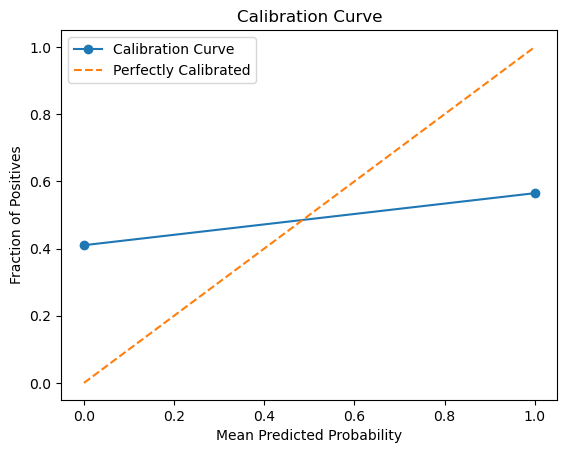

Brier Score: 0.4255555555555556


In [32]:
from sklearn.calibration import calibration_curve
from sklearn.metrics import brier_score_loss
import matplotlib.pyplot as plt

# Assuming y_true is true labels and y_prob is predicted probabilities for one class
prob_true, prob_pred = calibration_curve(perf_y_col, perf_y_eval, n_bins=10)
plt.plot(prob_pred, prob_true, marker='o', label='Calibration Curve')
plt.plot([0, 1], [0, 1], linestyle='--', label='Perfectly Calibrated')
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.title('Calibration Curve')
plt.legend()
plt.show()
print("Brier Score:", brier_score_loss(perf_y_col, perf_y_eval))